#Pre-entrega 3: Modelos Predictivos Supervisados

### 🧭 OBJETIVO GENERAL

Desarrollar y entrenar modelos predictivos para entender la evolución y proyección futura de la producción de gas natural en Argentina, haciendo foco en el crecimiento de los recursos no convencionales (shale y tight).

In [3]:
!pip install numpy==1.24.3 pmdarima==2.0.3 --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 155.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 133.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 131.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.8/129.8 kB 167.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66

In [2]:
#Importamos librerías a utilizar
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
# Importar funciones para validación cruzada de Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import warnings
# Importar product para iterar sobre combinaciones de parámetros
from itertools import product

# Importar para ARIMA y SARIMA
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

## Dataset1

#### 🔍 Carga e inspección del Dataset1

Se cargó el archivo `dataset1_editado`, que contiene la información a analizar y modelar ya filtrada y transformada. Se revisaron columnas, tipos de datos y valores nulos. Se creó una columna fecha y se visualizó la evolución de la producción de gas.

In [ ]:
df1 = pd.read_csv('/content/dataset1_editado.csv')

In [ ]:
df1.head()

,indice_tiempo,produccion_gas_natural_cuenca_austral,produccion_gas_natural_cuenca_gsj,produccion_gas_natural_cuenca_neuquina,produccion_gas_natural_cuenca_noroeste,produccion_gas_natural_cuenca_cuyana,produccion_gas_natural_total,produccion_shale_gas,produccion_tight_gas,anio,produccion_no_convencional,produccion_convencional,mes
0,2014-01-01,885167.3714,442014.6605,1.944920e+06,263495.3680,4599.6114,3.540197e+06,23465.959800,314046.25217,2014,337512.211970,3.202685e+06,1
1,2014-02-01,793800.6656,403246.2098,1.756761e+06,233504.3885,4352.7275,3.191665e+06,22807.990191,284537.62290,2014,307345.613091,2.884319e+06,2
2,2014-03-01,879715.0346,453502.3597,1.885451e+06,254380.6826,4891.7040,3.477941e+06,24844.175160,311893.06300,2014,336737.238160,3.141204e+06,3
3,2014-04-01,740749.0121,438266.3703,1.833150e+06,239112.5697,4763.2185,3.256041e+06,30990.912010,313487.91707,2014,344478.829080,2.911563e+06,4
4,2014-05-01,880061.9141,445484.1645,1.966218e+06,247344.8389,4877.9888,3.543987e+06,39014.194660,357115.97376,2014,396130.168420,3.147856e+06,5


In [ ]:
df1.shape

(132, 13)

In [ ]:
df1.dtypes

,0
indice_tiempo,object
produccion_gas_natural_cuenca_austral,float64
produccion_gas_natural_cuenca_gsj,float64
produccion_gas_natural_cuenca_neuquina,float64
produccion_gas_natural_cuenca_noroeste,float64
produccion_gas_natural_cuenca_cuyana,float64
produccion_gas_natural_total,float64
produccion_shale_gas,float64
produccion_tight_gas,float64
anio,int64


In [ ]:
df1.isna().sum()

,0
indice_tiempo,0
produccion_gas_natural_cuenca_austral,0
produccion_gas_natural_cuenca_gsj,0
produccion_gas_natural_cuenca_neuquina,0
produccion_gas_natural_cuenca_noroeste,0
produccion_gas_natural_cuenca_cuyana,0
produccion_gas_natural_total,0
produccion_shale_gas,0
produccion_tight_gas,0
anio,0


#### 📊 Visualización del Dataset1

Se analizo la evolución mensual y anual de la producción de gas en Argentina desde 2014-2024. Se visualizó la correlación de las variables con la producción total de gas natural.

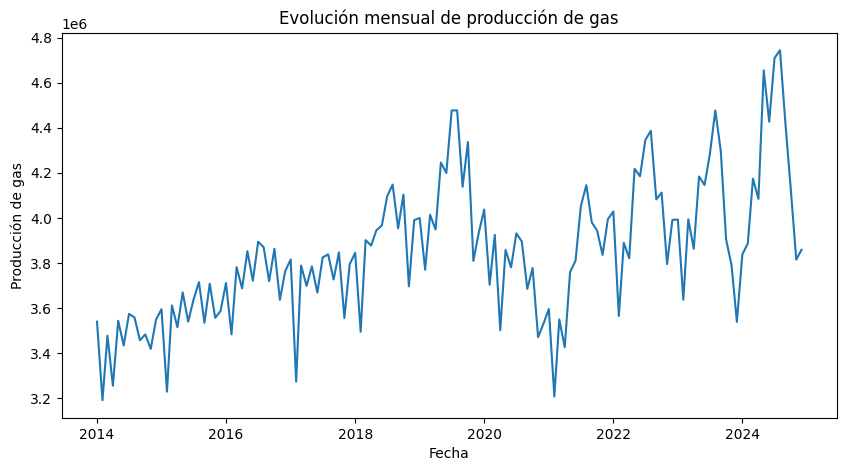

In [ ]:
# Ver evolución temporal(Mensual)
# Crear columna de fecha solo para visualización
df1['fecha'] = pd.to_datetime(df1.rename(columns={'anio': 'year', 'mes': 'month'})[['year', 'month']].assign(day=1))

plt.figure(figsize=(10, 5))
sns.lineplot(data=df1, x='fecha', y='produccion_gas_natural_total')  # asegúrate que 'prod_gas' sea el nombre correcto
plt.title("Evolución mensual de producción de gas")
plt.xlabel("Fecha")
plt.ylabel("Producción de gas")
plt.show()

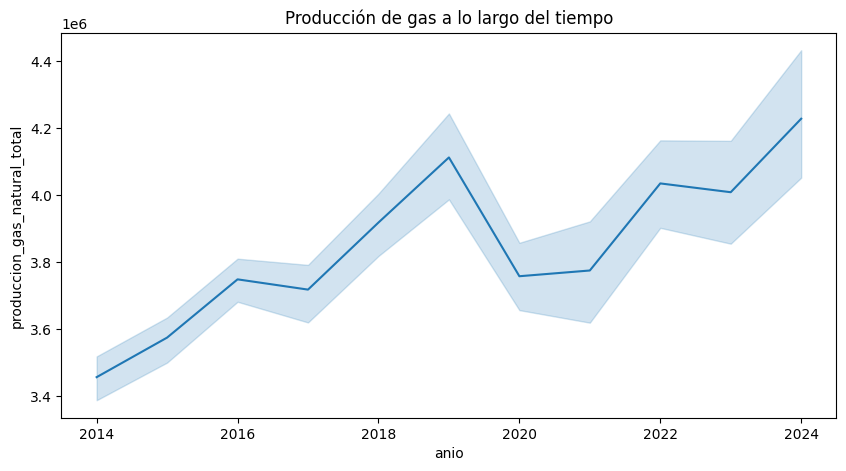

In [ ]:
# Ver evolución temporal(Anual)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df1, x='anio', y='produccion_gas_natural_total')
plt.title("Producción de gas a lo largo del tiempo")
plt.show()

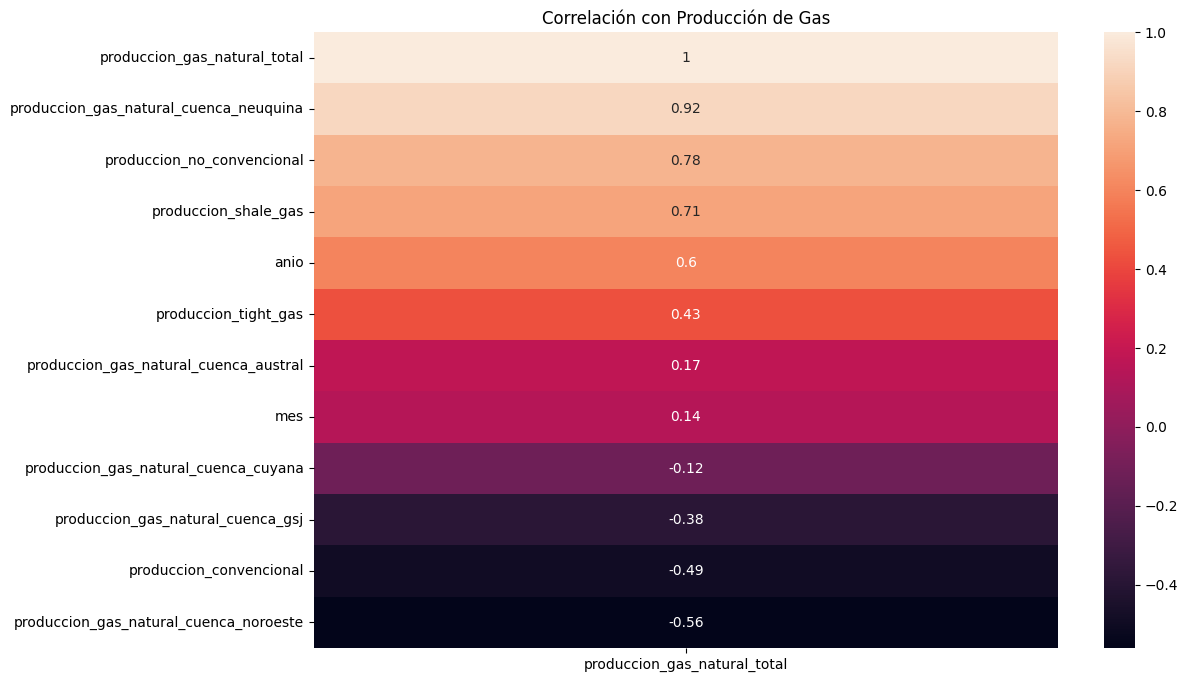

In [ ]:
#Correlación de variables
corr = df1.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['produccion_gas_natural_total']].sort_values(by='produccion_gas_natural_total', ascending=False), annot=True)
plt.title("Correlación con Producción de Gas")
plt.show()

El **gráfico de Correlación de Variables** nos muestra que hay  variables con *alta correlación positiva* con la producción total.

🔹 Estas variables aportan valor predictivo fuerte.

🔹 También implican que la cuenca neuquina y el no convencional (en particular shale) dominan la tendencia nacional.

Variables con *correlación negativa o baja*:

🔸 Estas aportan poco o distorsionan, especialmente en modelos lineales.

🔸 produccion_convencional y el noroeste tienen una relación inversa porque pierden participación frente al shale.

✅ **Variables relevantes a conservar**

Nuestra variable objetivo esta relacionada con la produccion de gas `'produccion_gas_natural_total'`

Usaremos como features aquellas con mayor correlación positiva con la producción total y que tienen sentido desde el punto de vista de la producción a lo largo del tiempo:

* Características temporales: mes, anio_característica, trimestre.

* Indicadores de estacionalidad: estacionalidad_verano, estacionalidad_otono, estacionalidad_invierno, estacionalidad_primavera.

* Variable objetivo retardada. Estos son vitales para el pronóstico de series de tiempo, ya que aprovechan valores pasados de la variable objetivo para predecir los futuros, y son los siguientes: produccion_total_lag_1, produccion_total_lag_2,
produccion_total_lag_3.


📌 Estas variables son cruciales para la previsión de series temporales, ya que aprovechan los valores pasados de la variable objetivo para predecir los futuros..


❌ **Variables a descartar**

Quitamos las variables que tienen correlaciones directa con nuestro target, como:

    'produccion_gas_natural_cuenca_austral',
    'produccion_gas_natural_cuenca_gsj',
    'produccion_gas_natural_cuenca_neuquina',
    'produccion_gas_natural_cuenca_noroeste',
    'produccion_gas_natural_cuenca_cuyana',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'produccion_no_convencional',
    'produccion_convencional',    
    'indice_tiempo' # Esta columna es una fecha, no numérica y ya tenemos el índice.

📌 Si bien representan zonas productivas, las excluimos para evitar Data Leakage. Estas son variables que directamente contribuyen a 'produccion_gas_natural_total' y cuya inclusión como predictores causaría un "leakage" o fuga de datos que ajusta de manera irrealista.

*La fuga de datos ocurre cuando tu modelo tiene acceso a información durante el entrenamiento que legítimamente no tendría durante la predicción, lo que lleva a estimaciones de rendimiento demasiado optimistas en tu conjunto de prueba que no se mantendrán en un escenario del mundo real.*

### 1. Desarrollo y Evaluación de Modelos Predictivos de Producción (Regresión)

**Objetivo:** Crear, entrenar y evaluar modelos predictivos de producción que compare las predicciones con los datos históricos reales.

**Tareas:**

- Generar series temporales agregadas (mensuales o anuales) de la producción total a nivel nacional.
- Crear variables temporales predictoras relevantes: tendencia, estacionalidad, rezagos, entre otras.
- Entrenar y testear modelos clásicos de regresión como Regresión lineal, Árboles de decisión, Random Forest y SVR (Support Vector Regressor).
- Realizar validación temporal: entrenar los modelos con un conjunto de datos históricos y evaluar su rendimiento con los datos más recientes disponibles.
- Comparar visualmente las predicciones del modelo con los datos de producción reales para evaluar su precisión.

#### 📊 1. 1. Preparación para Modelado

En esta sección se crearon las características temporales y se dividieron los datos en conjuntos de entrenamiento y de prueba, manteniendo el orden temporal.

In [ ]:
# --- Funciones Auxiliares (se mantienen igual) ---
def evaluate_model(y_true, y_pred, model_name=""):
    """
    Evalúa un modelo de regresión y devuelve un diccionario de métricas.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # R2 para manejar casos donde y_true son constantes o muy pequeños
    r2 = r2_score(y_true, y_pred)
    # Manejar el caso de división por cero en MAPE si y_true contiene ceros
    y_true_no_zero = y_true.copy()
    y_true_no_zero[y_true_no_zero == 0] = np.nan # Reemplazar 0 por NaN para evitar divisiones por cero

    if y_true_no_zero.dropna().empty: # Si todas son NaN después de eliminar los 0s
        mape = np.nan
    else:
        # Calcular MAPE solo en los puntos donde y_true no es cero
        mape = np.mean(np.abs((y_true_no_zero - y_pred) / y_true_no_zero).dropna()) * 100
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE (%)': mape
    }
    print(f"\nMétricas para {model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    return metrics

def plot_predictions(y_true, y_pred, title, model_name, ax=None):
    """
    Grafica las predicciones vs los datos reales.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_true.index, y_true, label='Producción Real', color='blue')
    ax.plot(y_true.index, y_pred, label='Predicción', color='red', linestyle='--')
    ax.set_title(f'Predicciones vs Datos Reales - {title} ({model_name})')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Producción de Gas Natural')
    ax.legend()
    ax.grid(True)
    return ax

def plot_residuals(y_true, y_pred, title, model_name, ax=None):
    """
    Grafica los residuos de un modelo.
    """
    residuals = y_true - y_pred
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(y_pred, residuals, alpha=0.5, color='purple')
    ax.axhline(y=0, color='red', linestyle='--')
    ax.set_title(f'Análisis de Residuos - {title} ({model_name})')
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Residuos')
    ax.grid(True)
    return ax

def plot_feature_importance(model, feature_names, model_name, ax=None):
    """
    Visualiza la importancia de las características para modelos basados en árboles o lineales.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        if len(importances) != len(feature_names):
            print(f"Advertencia: El número de importancias ({len(importances)}) no coincide con el número de características ({len(feature_names)}) para {model_name}. Skipping plot.")
            return None

        indices = np.argsort(importances)[::-1]
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], ax=ax, palette='viridis')
        ax.set_title(f'Importancia de Características - {model_name}')
        ax.set_xlabel('Importancia')
        ax.set_ylabel('Característica')
        return ax
    elif hasattr(model, 'coef_'): # Para modelos lineales
        coefs = model.coef_
        if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
            coefs = coefs.flatten()

        if len(coefs) != len(feature_names):
            print(f"Advertencia: El número de coeficientes ({len(coefs)}) no coincide con el número de características ({len(feature_names)}) para {model_name}. Skipping plot.")
            return None

        abs_coefs = np.abs(coefs)
        indices = np.argsort(abs_coefs)[::-1]
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
        sns.barplot(x=abs_coefs[indices], y=[feature_names[i] for i in indices], ax=ax, palette='viridis')
        ax.set_title(f'Importancia de Características (Abs. Coef.) - {model_name}')
        ax.set_xlabel('Magnitud del Coeficiente')
        ax.set_ylabel('Característica')
        return ax
    else:
        print(f"El modelo {model_name} no tiene un atributo de importancia de características o coeficientes directos.")
        return None

In [ ]:
# --- PARTE 1: Modelo Predictivo Nacional de Producción (Regresión) ---

# Depuración: Ver el rango de fechas del DataFrame original
print(f"\nDataFrame original - Filas: {df1.shape[0]}, Columnas: {df1.shape[1]}")
print(f"Rango de fechas original (anio, mes): {df1['anio'].min()}-{df1['mes'].min()} a {df1['anio'].max()}-{df1['mes'].max()}")

# Generar una columna de fecha para la serie temporal
df1['fecha'] = pd.to_datetime(df1['anio'].astype(str) + '-' + df1['mes'].astype(str) + '-01')
df1.set_index('fecha', inplace=True)
df1.sort_index(inplace=True)

print(f"DataFrame con índice de fecha - Primeras fechas: {df1.index.min()}, Últimas fechas: {df1.index.max()}")
print(f"Filas después de establecer índice y ordenar: {df1.shape[0]}")


DataFrame original - Filas: 132, Columnas: 14
Rango de fechas original (anio, mes): 2014-1 a 2024-12
DataFrame con índice de fecha - Primeras fechas: 2014-01-01 00:00:00, Últimas fechas: 2024-12-01 00:00:00
Filas después de establecer índice y ordenar: 132


In [ ]:
# 2. Generar una serie temporal mensual de la variable produccion_gas_natural_total
ts_total_produccion = df1['produccion_gas_natural_total']
print("\nSerie temporal de 'produccion_gas_natural_total' generada.")


Serie temporal de 'produccion_gas_natural_total' generada.


In [ ]:
# 3. Crear variables predictoras temporales
def create_time_features(df1_input):
    df1_output = df1_input.copy()
    if not isinstance(df1_output.index, pd.DatetimeIndex):
        df1_output['fecha'] = pd.to_datetime(df1_output['anio'].astype(str) + '-' + df1_output['mes'].astype(str) + '-01')
        df1_output.set_index('fecha', inplace=True)
        df1_output.sort_index(inplace=True)

    df1_output['mes'] = df1_output.index.month
    df1_output['anio_feature'] = df1_output.index.year
    df1_output['trimestre'] = df1_output.index.quarter

    # Estacionalidad
    df1_output['estacionalidad_verano'] = ((df1_output['mes'] == 12) | (df1_output['mes'] == 1) | (df1_output['mes'] == 2)).astype(int)
    df1_output['estacionalidad_otono'] = ((df1_output['mes'] == 3) | (df1_output['mes'] == 4) | (df1_output['mes'] == 5)).astype(int)
    df1_output['estacionalidad_invierno'] = ((df1_output['mes'] == 6) | (df1_output['mes'] == 7) | (df1_output['mes'] == 8)).astype(int)
    df1_output['estacionalidad_primavera'] = ((df1_output['mes'] == 9) | (df1_output['mes'] == 10) | (df1_output['mes'] == 11)).astype(int)

    if 'produccion_gas_natural_total' not in df1_output.columns:
        raise ValueError("La columna 'produccion_gas_natural_total' no se encontró en el DataFrame de entrada para lags.")

    for i in range(1, 4): # Lags de la variable objetivo
        df1_output[f'produccion_total_lag_{i}'] = df1_output['produccion_gas_natural_total'].shift(i)

    # Manejar otras columnas numéricas que pudieran tener comas como decimales
    cols_to_convert = [col for col in df1_output.columns if df1_output[col].dtype == 'object' and df1_output[col].astype(str).str.contains(',').any()]
    for col in cols_to_convert:
        df1_output[col] = df1_output[col].astype(str).str.replace(',', '.', regex=False)
        df1_output[col] = pd.to_numeric(df1_output[col], errors='coerce')

    initial_rows = df1_output.shape[0]
    df1_output.dropna(subset=[f'produccion_total_lag_{i}' for i in range(1,4)], inplace=True)
    print(f"Filas después de eliminar NaNs de lags: {df1_output.shape[0]} (eliminadas: {initial_rows - df1_output.shape[0]})")

    initial_rows_after_lags = df1_output.shape[0]
    # Eliminar NaNs restantes que puedan haber surgido de la conversión a numérico
    df1_output.dropna(inplace=True)
    print(f"Filas después de convertir a numérico y eliminar NaNs: {df1_output.shape[0]} (eliminadas: {initial_rows_after_lags - df1_output.shape[0]})")

    return df1_output

df1_features = create_time_features(df1)
print("\nVariables predictoras temporales y lags creadas.")
print(f"DataFrame con features creado - Filas: {df1_features.shape[0]}, Columnas: {df1_features.shape[1]}")
if not df1_features.empty:
    print(f"Primeras 5 filas de df1_features:\n{df1_features.head()}")
    print(f"Últimas 5 filas de df1_features:\n{df1_features.tail()}")
    print(f"Rango de fechas en df1_features: {df1_features.index.min()} a {df1_features.index.max()}")
else:
    print("¡Advertencia: df1_features está vacío después de la creación de características y dropna!")
    exit()

target = 'produccion_gas_natural_total'

# ---  Exclusión de características para evitar Data Leakage ---
cols_to_exclude_from_X = [
    target, # Obviamente, no es una característica
    'produccion_gas_natural_cuenca_austral',
    'produccion_gas_natural_cuenca_gsj',
    'produccion_gas_natural_cuenca_neuquina',
    'produccion_gas_natural_cuenca_noroeste',
    'produccion_gas_natural_cuenca_cuyana',
    'produccion_shale_gas',
    'produccion_tight_gas',
    'produccion_no_convencional',
    'produccion_convencional',
    'indice_tiempo'
]

# Seleccionar X e y
X = df1_features.drop(columns=cols_to_exclude_from_X, errors='ignore').select_dtypes(include=np.number)
y = df1_features[target]

print(f"\nCaracterísticas (X) después de excluir posibles 'data leakages' y select_dtypes(include=np.number): {X.columns.tolist()}")
print(f"Tamaño de X: {X.shape}, Tamaño de y: {y.shape}")

if X.empty or y.empty:
    print("¡Error: X o y están vacíos antes de la división train/test! Revisa la creación de features y limpieza de NaNs.")
    exit()

Filas después de eliminar NaNs de lags: 129 (eliminadas: 3)
Filas después de convertir a numérico y eliminar NaNs: 129 (eliminadas: 0)

Variables predictoras temporales y lags creadas.
DataFrame con features creado - Filas: 129, Columnas: 22
Primeras 5 filas de df1_features:
           indice_tiempo  produccion_gas_natural_cuenca_austral  \
fecha                                                             
2014-04-01    2014-04-01                            740749.0121   
2014-05-01    2014-05-01                            880061.9141   
2014-06-01    2014-06-01                            848265.7895   
2014-07-01    2014-07-01                            882226.6256   
2014-08-01    2014-08-01                            859558.3476   

            produccion_gas_natural_cuenca_gsj  \
fecha                                           
2014-04-01                        438266.3703   
2014-05-01                        445484.1645   
2014-06-01                        432434.9751   
2014-07-0

In [ ]:
# ---  Lógica de División de Datos ---
horizonte_prediccion_meses = 24 # Los últimos 2 años

# Calcular la fecha de inicio del conjunto de prueba
split_date = df1_features.index.max() - pd.DateOffset(months=horizonte_prediccion_meses - 1)

# Dividir los datos
X_train = X[X.index < split_date]
y_train = y[y.index < split_date]

X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

print(f"\nVerificando tamaños de sets de entrenamiento y prueba:")
if X_train.empty or y_train.empty:
    print(f"Error: Los sets de entrenamiento están vacíos. X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Fechas en X (todos los datos): {X.index.min()} a {X.index.max()}")
    print(f"Split date: {split_date}")
    exit()
if X_test.empty or y_test.empty:
    print(f"Error: Los sets de prueba están vacíos. X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    print(f"Fechas en X (todos los datos): {X.index.min()} a {X.index.max()}")
    print(f"Split date: {split_date}")
    exit()

print(f"\nDatos de entrenamiento: {X_train.index.min()} a {X_train.index.max()}")
print(f"Datos de prueba: {X_test.index.min()} a {X_test.index.max()}")
print(f"Tamaño de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}, y_test: {y_test.shape}")


Verificando tamaños de sets de entrenamiento y prueba:

Datos de entrenamiento: 2014-04-01 00:00:00 a 2022-12-01 00:00:00
Datos de prueba: 2023-01-01 00:00:00 a 2024-12-01 00:00:00
Tamaño de X_train: (105, 11), y_train: (105,)
Tamaño de X_test: (24, 11), y_test: (24,)


In [ ]:
# --- Escalado de características ---
scaler = StandardScaler()

# Ajustar el escalador solo en los datos de entrenamiento y transformar ambos
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de nuevo a DataFrame para mantener los nombres de las columnas e índices
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nCaracterísticas escaladas usando StandardScaler.")
print(f"Ejemplo de X_train_scaled (primeras filas):\n{X_train_scaled.head()}")


Características escaladas usando StandardScaler.
Ejemplo de X_train_scaled (primeras filas):
                anio       mes  anio_feature  trimestre  \
fecha                                                     
2014-04-01 -1.627976 -0.770349     -1.627976  -0.491562   
2014-05-01 -1.627976 -0.477281     -1.627976  -0.491562   
2014-06-01 -1.627976 -0.184214     -1.627976  -0.491562   
2014-07-01 -1.627976  0.108854     -1.627976   0.413947   
2014-08-01 -1.627976  0.401921     -1.627976   0.413947   

            estacionalidad_verano  estacionalidad_otono  \
fecha                                                     
2014-04-01              -0.559017              1.743118   
2014-05-01              -0.559017              1.743118   
2014-06-01              -0.559017             -0.573685   
2014-07-01              -0.559017             -0.573685   
2014-08-01              -0.559017             -0.573685   

            estacionalidad_invierno  estacionalidad_primavera  \
fecha        

#### 📊 1. 2. Modelado y Evaluación

Este es el núcleo de nuestro análisis, en el que se entrenan y se evalúan diferentes modelos, tanto con la configuración predeterminada como con la optimización de los hiperparámetros.

**Modelos Base**
Se inicializan y entrenan los modelos de regresión elegidos con sus parámetros por defecto, y luego se evalúa su rendimiento.

In [ ]:
# ---  Entrenar y Evaluar Modelos de Regresión ---
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'XGBoost': xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
}

prophet_model_results = {}
base_model_results = {}
optimized_model_results = {}
base_model_predictions = {}
optimized_model_predictions = {}
base_model_residuals = {}
optimized_model_residuals = {}
base_model_feature_importance = {}
optimized_model_feature_importance = {}


print("\n--- ENTRENANDO Y EVALUANDO MODELOS BASE ---")
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    # Usar datos escalados para SVR y Linear Regression, y no escalados para otros
    if name in ['SVR', 'Linear Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    base_model_predictions[name] = pd.Series(y_pred, index=y_test.index)
    metrics = evaluate_model(y_test, y_pred, name)
    base_model_results[name] = metrics
    base_model_residuals[name] = y_test - y_pred
    if hasattr(model, 'feature_importances_'):
        base_model_feature_importance[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):
        if hasattr(model.coef_, '__len__') and len(model.coef_) == X_train.shape[1]:
            base_model_feature_importance[name] = model.coef_
        else:
            base_model_feature_importance[name] = None
            print(f"Advertencia: Coeficientes de {name} no coinciden con el número de características o no son válidos.")
    else:
        base_model_feature_importance[name] = None


--- ENTRENANDO Y EVALUANDO MODELOS BASE ---

Entrenando Linear Regression...

Métricas para Linear Regression:
  MAE: 191968.6396
  MSE: 53928016514.3040
  RMSE: 232224.0653
  R2: 0.4857
  MAPE (%): 4.7593

Entrenando Decision Tree...

Métricas para Decision Tree:
  MAE: 182227.6590
  MSE: 47685240921.7302
  RMSE: 218369.5055
  R2: 0.5452
  MAPE (%): 4.4287

Entrenando Random Forest...

Métricas para Random Forest:
  MAE: 189579.7265
  MSE: 56326300809.8512
  RMSE: 237331.6262
  R2: 0.4628
  MAPE (%): 4.5590

Entrenando SVR...

Métricas para SVR:
  MAE: 358671.3715
  MSE: 209689723808.8369
  RMSE: 457918.9053
  R2: -0.9998
  MAPE (%): 8.2739

Entrenando XGBoost...

Métricas para XGBoost:
  MAE: 178650.0575
  MSE: 50006494561.8211
  RMSE: 223621.3196
  R2: 0.5231
  MAPE (%): 4.2690


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)

# --- Prophet (Modelo Base) ---

print("\nEntrenando Prophet (Base)...")
prophet_df1_full = df1_features.reset_index().rename(columns={'fecha': 'ds', 'produccion_gas_natural_total': 'y'})

prophet_regressors = [col for col in X.columns if col in df1_features.columns]
prophet_cols = ['ds', 'y'] + prophet_regressors

prophet_df1_full = prophet_df1_full[prophet_cols]

prophet_train = prophet_df1_full[prophet_df1_full['ds'] < split_date]
prophet_test = prophet_df1_full[prophet_df1_full['ds'] >= split_date]


if prophet_train.empty or prophet_test.empty:
    print("Error: Los datasets de Prophet (train/test) están vacíos. Revisa el rango de fechas o la split_date.")
    exit()

m = Prophet(seasonality_mode='multiplicative',
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False)

for feature in prophet_regressors:
    m.add_regressor(feature)

m.fit(prophet_train)
future = prophet_test.drop(columns=['y'])
forecast = m.predict(future)

y_pred_prophet = pd.Series(forecast['yhat'].values, index=pd.to_datetime(forecast['ds']))
base_model_predictions['Prophet'] = y_pred_prophet
metrics_prophet = evaluate_model(y_test, y_pred_prophet, "Prophet")
base_model_results['Prophet'] = metrics_prophet
base_model_residuals['Prophet'] = y_test - y_pred_prophet
base_model_feature_importance['Prophet'] = None


Entrenando Prophet (Base)...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mnljwdhk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1f0fglkg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75060', 'data', 'file=/tmp/tmpky5uev4_/mnljwdhk.json', 'init=/tmp/tmpky5uev4_/1f0fglkg.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model5_iftnk3/prophet_model-20250618183948.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Métricas para Prophet:
  MAE: 155195.5279
  MSE: 44487932594.0914
  RMSE: 210921.6267
  R2: 0.5757
  MAPE (%): 3.8536


In [ ]:
# --- ARIMA (Modelo Base) ---
print("\nEntrenando ARIMA (Base)...")
try:
    arima_model = pm.auto_arima(y_train, seasonal=False, suppress_warnings=True,
                                 stepwise=True, trace=False, error_action="ignore",
                                 n_fits=20)

    print(f"Mejores parámetros ARIMA (Base): {arima_model.order}")

    arima_predictions_array = arima_model.predict(n_periods=len(y_test))
    y_pred_arima = pd.Series(arima_predictions_array, index=y_test.index)

    base_model_predictions['ARIMA'] = y_pred_arima
    metrics_arima = evaluate_model(y_test, y_pred_arima, "ARIMA")
    base_model_results['ARIMA'] = metrics_arima
    base_model_residuals['ARIMA'] = y_test - y_pred_arima
    base_model_feature_importance['ARIMA'] = None
except Exception as e:
    print(f"Error al entrenar o predecir con ARIMA: {e}. Este modelo no será evaluado.")
    base_model_predictions['ARIMA'] = pd.Series([], dtype=float)
    base_model_results['ARIMA'] = {}
    base_model_residuals['ARIMA'] = pd.Series([], dtype=float)
    base_model_feature_importance['ARIMA'] = None


Entrenando ARIMA (Base)...
Mejores parámetros ARIMA (Base): (0, 1, 0)

Métricas para ARIMA:
  MAE: 276219.3166
  MSE: 121036055773.7613
  RMSE: 347902.3653
  R2: -0.1543
  MAPE (%): 6.5032


In [ ]:
# --- SARIMA (Modelo Base) ---
print("\nEntrenando SARIMA (Base)...")
try:
    sarima_model = pm.auto_arima(y_train, seasonal=True, m=12, suppress_warnings=True,
                                 stepwise=True, trace=False, error_action="ignore",
                                 n_fits=20)

    print(f"Mejores parámetros SARIMA (Base): {sarima_model.order}, estacional: {sarima_model.seasonal_order}")

    sarima_predictions_array = sarima_model.predict(n_periods=len(y_test))
    y_pred_sarima = pd.Series(sarima_predictions_array, index=y_test.index)

    base_model_predictions['SARIMA'] = y_pred_sarima
    metrics_sarima = evaluate_model(y_test, y_pred_sarima, "SARIMA")
    base_model_results['SARIMA'] = metrics_sarima
    base_model_residuals['SARIMA'] = y_test - y_pred_sarima
    base_model_feature_importance['SARIMA'] = None
except Exception as e:
    print(f"Error al entrenar o predecir con SARIMA: {e}. Este modelo no será evaluado.")
    base_model_predictions['SARIMA'] = pd.Series([], dtype=float)
    base_model_results['SARIMA'] = {}
    base_model_residuals['SARIMA'] = pd.Series([], dtype=float)
    base_model_feature_importance['SARIMA'] = None


Entrenando SARIMA (Base)...
Mejores parámetros SARIMA (Base): (0, 0, 2), estacional: (0, 1, 0, 12)

Métricas para SARIMA:
  MAE: 161664.4799
  MSE: 38971593975.1836
  RMSE: 197412.2437
  R2: 0.6283
  MAPE (%): 3.9557


**Modelos Optimizados**

Se realiza un ajuste fino de los hiperparámetros de sus modelos de regresión utilizando `GridSearchCV` o `RandomizedSearchCV` con `TimeSeriesSplit` para una evaluación robusta.

In [ ]:
# --- Ajustar hiperparámetros para mejorar los índices de predicciones ---
print("\n--- AJUSTANDO HIPERPARÁMETROS DE MODELOS ---")

# Rangos de parámetros ajustados para SVR y otros
param_grids = {
    'Linear Regression': {}, # No se optimiza para LR
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20, None], # Ampliado
        'min_samples_split': [2, 5, 10, 20], # Ampliado
        'min_samples_leaf': [1, 2, 4, 8], # Ampliado
        'max_features': ['sqrt', 'log2', 0.8, 1.0], # Añadido
        'ccp_alpha': [0.0, 0.001, 0.01, 0.05] # Añadido
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'C': [1, 10, 100, 1000],
        'gamma': ['scale', 'auto', 0.001, 0.01],
        'kernel': ['rbf', 'poly']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 400],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 6]
    }
}

best_models = {}

for name, model in models.items():
    print(f"\nOptimizando {name}...")
    params = param_grids[name]

    # Decide qué datos de entrenamiento usar para la optimización (escalados o no)
    if name in ['SVR', 'Linear Regression']:
        current_X_train = X_train_scaled
    else:
        current_X_train = X_train
    current_y_train = y_train

    if not params:
        best_models[name] = model.fit(current_X_train, current_y_train)
        if name in ['SVR', 'Linear Regression']:
            y_pred_opt = best_models[name].predict(X_test_scaled)
        else:
            y_pred_opt = best_models[name].predict(X_test)
    else:
        total_combinations = 1
        for key in params:
            total_combinations *= len(params[key])

        if current_X_train.empty or current_y_train.empty:
            print(f"Saltando optimización para {name}: Datos de entrenamiento vacíos.")
            best_models[name] = model # Usa el modelo base si no se puede optimizar
            if name in ['SVR', 'Linear Regression']:
                y_pred_opt = model.predict(X_test_scaled)
            else:
                y_pred_opt = model.predict(X_test)
        else:
            # Usar TimeSeriesSplit para la validación cruzada
            tscv = TimeSeriesSplit(n_splits=5)

            if total_combinations > 10: # Usa RandomizedSearchCV para muchas combinaciones
                n_iter_search = min(30, total_combinations)
                if name == 'SVR':
                    if current_X_train.shape[0] < 2:
                        X_train_tuning = current_X_train
                        y_train_tuning = current_y_train
                        print(f"  No hay suficientes datos para muestrear para SVR tuning. Usando todo el conjunto de entrenamiento.")
                    else:
                        X_train_tuning, _, y_train_tuning, _ = train_test_split(
                            current_X_train, current_y_train, train_size=0.7, random_state=42
                        )
                        print(f"  Usando un subconjunto de entrenamiento ({X_train_tuning.shape[0]} muestras) para SVR tuning.")
                    random_search = RandomizedSearchCV(model, params, n_iter=n_iter_search, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=0)
                    random_search.fit(X_train_tuning, y_train_tuning)
                else:
                    random_search = RandomizedSearchCV(model, params, n_iter=n_iter_search, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42, verbose=0)
                    random_search.fit(current_X_train, current_y_train)

                best_estimator = random_search.best_estimator_
                print(f"Mejores parámetros con RandomizedSearchCV para {name}: {random_search.best_params_}")
            else: # Pocas combinaciones, usa GridSearchCV
                grid_search = GridSearchCV(model, params, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
                grid_search.fit(current_X_train, current_y_train)
                best_estimator = grid_search.best_estimator_
                print(f"Mejores parámetros con GridSearchCV para {name}: {grid_search.best_params_}")

            best_models[name] = best_estimator
            if name in ['SVR', 'Linear Regression']:
                y_pred_opt = best_models[name].predict(X_test_scaled)
            else:
                y_pred_opt = best_models[name].predict(X_test)

    optimized_model_predictions[name] = pd.Series(y_pred_opt, index=y_test.index)
    metrics_opt = evaluate_model(y_test, y_pred_opt, f"{name} (Optimizado)")
    optimized_model_results[name] = metrics_opt
    optimized_model_residuals[name] = y_test - y_pred_opt
    if hasattr(best_models[name], 'feature_importances_'):
        optimized_model_feature_importance[name] = best_models[name].feature_importances_
    elif hasattr(best_models[name], 'coef_'):
        if hasattr(best_models[name].coef_, '__len__') and len(best_models[name].coef_) == X_train.shape[1]:
            optimized_model_feature_importance[name] = best_models[name].coef_
        else:
            optimized_model_feature_importance[name] = None
            print(f"Advertencia: Coeficientes optimizados de {name} no coinciden con el número de características o no son válidos.")
    else:
        optimized_model_feature_importance[name] = None


--- AJUSTANDO HIPERPARÁMETROS DE MODELOS ---

Optimizando Linear Regression...

Métricas para Linear Regression (Optimizado):
  MAE: 191968.6396
  MSE: 53928016514.3040
  RMSE: 232224.0653
  R2: 0.4857
  MAPE (%): 4.7593

Optimizando Decision Tree...
Mejores parámetros con RandomizedSearchCV para Decision Tree: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'ccp_alpha': 0.001}

Métricas para Decision Tree (Optimizado):
  MAE: 264947.6660
  MSE: 94741238218.3866
  RMSE: 307800.6469
  R2: 0.0965
  MAPE (%): 6.4583

Optimizando Random Forest...
Mejores parámetros con RandomizedSearchCV para Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}

Métricas para Random Forest (Optimizado):
  MAE: 186227.4013
  MSE: 55111457877.3818
  RMSE: 234758.2967
  R2: 0.4744
  MAPE (%): 4.4758

Optimizando SVR...
  Usando un subconjunto de entrenamiento (73 muestras) para SVR tuning.
Mejores parámetros con Randomiz

**Modelos de Series Temporales Puros (Prophet, ARIMA, SARIMA)**

Se implementa y optimiza Prophet, y confirma el manejo de ARIMA y SARIMA.

In [ ]:
# --- Prophet Model (Optimización con Cross-Validation - Primera Pasada) ---
print("\n--- OPTIMIZANDO PROPHET CON CROSS-VALIDATION (PRIMERA PASADA) ---")

prophet_params_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

best_prophet_model_cv = None
best_prophet_mape = float('inf')
best_prophet_params = {}

# Convertir horizonte de meses a días para Prophet cross_validation
horizon_days = int(horizonte_prediccion_meses * (365.25 / 12))
horizon_str = f"{horizon_days} days"

# Asegurarse de que 'initial' sea suficiente para entrenar el modelo antes del primer corte
initial_days = (prophet_train['ds'].iloc[-1] - prophet_train['ds'].iloc[0]).days + 1
initial_str = f"{initial_days} days"

# Advertencia si initial es muy corto en relación al horizonte
if initial_days < 2 * horizon_days:
    print(f"Advertencia: 'initial' ({initial_days} days) es menor que 2 veces el 'horizon' ({horizon_days} days).")
    print(f"Esto podría afectar la validez de la validación cruzada de Prophet. Considera extender tu conjunto de entrenamiento o reducir el horizonte de predicción.")


for s_mode, cp_scale, s_scale in product(prophet_params_grid['seasonality_mode'],
                                         prophet_params_grid['changepoint_prior_scale'],
                                         prophet_params_grid['seasonality_prior_scale']):
    print(f"\nProbando Prophet con: seasonality_mode={s_mode}, changepoint_prior_scale={cp_scale}, seasonality_prior_scale={s_scale}")
    m_tuned = Prophet(seasonality_mode=s_mode,
                      changepoint_prior_scale=cp_scale,
                      seasonality_prior_scale=s_scale,
                      yearly_seasonality=True,
                      weekly_seasonality=False,
                      daily_seasonality=False)

    for feature in prophet_regressors:
        m_tuned.add_regressor(feature)

    # Ajusta el modelo con TODOS los datos disponibles para Prophet (prophet_df1_full)
    m_tuned.fit(prophet_df1_full) # Fit on full data for CV

    try:
        df1_cv = cross_validation(m_tuned,
                                 initial=initial_str,
                                 period='180 days',
                                 horizon=horizon_str,
                                 parallel='processes'
                                 )

        if not df1_cv.empty:
            df1_p = performance_metrics(df1_cv)
            current_mape = df1_p['mape'].mean()
            print(f"MAPE promedio para esta configuración de Prophet: {current_mape:.4f}%")

            if current_mape < best_prophet_mape:
                best_prophet_mape = current_mape
                best_prophet_model_cv = m_tuned
                best_prophet_params = {
                    'seasonality_mode': s_mode,
                    'changepoint_prior_scale': cp_scale,
                    'seasonality_prior_scale': s_scale
                }
        else:
            print("df1_cv está vacío, no se pudieron calcular las métricas para esta configuración de Prophet.")
    except Exception as e:
        print(f"Error durante la validación cruzada para esta configuración de Prophet: {e}")
        continue

if best_prophet_model_cv:
    print(f"\nMejor configuración de Prophet encontrada por CV (primera pasada): {best_prophet_params}")

    # Re-entrenar el mejor modelo de Prophet en el conjunto de entrenamiento (prophet_train)
    # para asegurar la consistencia con las predicciones de los otros modelos.
    m_best_final_prophet_pass1 = Prophet(seasonality_mode=best_prophet_params['seasonality_mode'],
                                         changepoint_prior_scale=best_prophet_params['changepoint_prior_scale'],
                                         seasonality_prior_scale=best_prophet_params['seasonality_prior_scale'],
                                         yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

    for feature in prophet_regressors:
        m_best_final_prophet_pass1.add_regressor(feature)

    m_best_final_prophet_pass1.fit(prophet_train)
    future_best_prophet_pass1 = prophet_test.drop(columns=['y'])
    forecast_best_prophet_pass1 = m_best_final_prophet_pass1.predict(future_best_prophet_pass1)

    y_pred_prophet_optimized = pd.Series(forecast_best_prophet_pass1['yhat'].values, index=pd.to_datetime(forecast_best_prophet_pass1['ds']))
    # Guardamos este resultado como "Prophet" optimizado inicial
    optimized_model_predictions['Prophet'] = y_pred_prophet_optimized
    metrics_prophet_opt = evaluate_model(y_test, y_pred_prophet_optimized, "Prophet (Optimizado CV - Pass 1)")
    optimized_model_results['Prophet'] = metrics_prophet_opt
    optimized_model_residuals['Prophet'] = y_test - y_pred_prophet_optimized
    optimized_model_feature_importance['Prophet'] = None # Prophet no tiene feature_importance directa para graficar
else:
    print("No se encontró una mejor configuración para Prophet en la primera pasada de validación cruzada.")
    # Si no se encontró un modelo optimizado, usar los resultados del modelo base
    optimized_model_predictions['Prophet'] = base_model_predictions['Prophet']
    optimized_model_results['Prophet'] = base_model_results['Prophet']
    optimized_model_residuals['Prophet'] = base_model_residuals['Prophet']
    optimized_model_feature_importance['Prophet'] = None

DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3n8a1yxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/q4cngpvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93550', 'data', 'file=/tmp/tmpky5uev4_/3n8a1yxf.json', 'init=/tmp/tmpky5uev4_/q4cngpvk.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model7camir_f/prophet_model-20250618184117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:41:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3r4leddt.json
DE


--- OPTIMIZANDO PROPHET CON CROSS-VALIDATION (PRIMERA PASADA) ---

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.001, seasonality_prior_scale=0.01


18:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2mmx0_e9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7qs7icae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22912', 'data', 'file=/tmp/tmpky5uev4_/2mmx0_e9.json', 'init=/tmp/tmpky5uev4_/7qs7icae.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model8utjd9b5/prophet_model-20250618184118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ht_1kve2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/by3timnv.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0413%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1


18:41:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ykjxfftt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0ok4fs4s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60264', 'data', 'file=/tmp/tmpky5uev4_/ykjxfftt.json', 'init=/tmp/tmpky5uev4_/0ok4fs4s.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelg_wtatfr/prophet_model-20250618184119.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/53x2e4v1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0b0yqfqh.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0859%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.001, seasonality_prior_scale=1.0


18:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gbr5ftgm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dmgee4uz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63280', 'data', 'file=/tmp/tmpky5uev4_/gbr5ftgm.json', 'init=/tmp/tmpky5uev4_/dmgee4uz.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeln8_ufhsv/prophet_model-20250618184120.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6ta27q5z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/p9aml0qr.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0878%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.001, seasonality_prior_scale=10.0


18:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/w1u43_11.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4rx4bfah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45894', 'data', 'file=/tmp/tmpky5uev4_/w1u43_11.json', 'init=/tmp/tmpky5uev4_/4rx4bfah.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelqnysttz9/prophet_model-20250618184121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/q6h2sptz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pqgk62la.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0878%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.01, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/y_vmp9vc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rjyqfd__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80541', 'data', 'file=/tmp/tmpky5uev4_/y_vmp9vc.json', 'init=/tmp/tmpky5uev4_/rjyqfd__.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelrt1ww5dl/prophet_model-20250618184122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/n6uidg8a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1nl9mvjh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0339%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.01, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qdps8knl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/m8rfzg4a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82515', 'data', 'file=/tmp/tmpky5uev4_/qdps8knl.json', 'init=/tmp/tmpky5uev4_/m8rfzg4a.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeld_qsbtye/prophet_model-20250618184122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tv_alxcf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/eqlemi69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0336%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hu8db0ek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8vp_ifrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42287', 'data', 'file=/tmp/tmpky5uev4_/hu8db0ek.json', 'init=/tmp/tmpky5uev4_/8vp_ifrb.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelwbcvs0t0/prophet_model-20250618184123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/n0ue1pi3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gxfe5gcc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0337%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kubs2tmm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zwga9j5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47759', 'data', 'file=/tmp/tmpky5uev4_/kubs2tmm.json', 'init=/tmp/tmpky5uev4_/zwga9j5q.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modely_ma518p/prophet_model-20250618184123.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/976p9rj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0ezo6y2h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0337%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.05, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ub7awi47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/08j8wen1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45172', 'data', 'file=/tmp/tmpky5uev4_/ub7awi47.json', 'init=/tmp/tmpky5uev4_/08j8wen1.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelh2sefh1h/prophet_model-20250618184124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/s048dwr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/681qi220.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0334%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.05, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b5w0_ra4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/g4dl71bf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35607', 'data', 'file=/tmp/tmpky5uev4_/b5w0_ra4.json', 'init=/tmp/tmpky5uev4_/g4dl71bf.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelunfbsb_a/prophet_model-20250618184124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/n6ahxpgk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/o3wcypqq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0354%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.05, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/11tgtrrw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yo8gvms4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87165', 'data', 'file=/tmp/tmpky5uev4_/11tgtrrw.json', 'init=/tmp/tmpky5uev4_/yo8gvms4.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model1c4k0ffz/prophet_model-20250618184124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/epn4vita.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9_taecfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0359%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.05, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/20qoc6g3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/htujasd1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45131', 'data', 'file=/tmp/tmpky5uev4_/20qoc6g3.json', 'init=/tmp/tmpky5uev4_/htujasd1.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeljo9sznu5/prophet_model-20250618184125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lhwclyp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/otlra9hi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0367%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zfxn__2r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/73ds07aq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41994', 'data', 'file=/tmp/tmpky5uev4_/zfxn__2r.json', 'init=/tmp/tmpky5uev4_/73ds07aq.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelj2521jui/prophet_model-20250618184125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_nadf3e4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/j8lj2nub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0342%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.1, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/j4toc_50.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9ik4tpi0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97107', 'data', 'file=/tmp/tmpky5uev4_/j4toc_50.json', 'init=/tmp/tmpky5uev4_/9ik4tpi0.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelbf5xtps1/prophet_model-20250618184125.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xqxfj3f6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5423xr5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0356%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6jw6krr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7e__5sr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19718', 'data', 'file=/tmp/tmpky5uev4_/6jw6krr2.json', 'init=/tmp/tmpky5uev4_/7e__5sr0.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelldj0evj9/prophet_model-20250618184126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pup7tj3r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_0k1z578.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0355%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/z94nsuoa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8k1ze9a2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23170', 'data', 'file=/tmp/tmpky5uev4_/z94nsuoa.json', 'init=/tmp/tmpky5uev4_/8k1ze9a2.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelbzw8zdvy/prophet_model-20250618184126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mi7cdywg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9tv6ep_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0366%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/r6h3te6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dk9hdanu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26371', 'data', 'file=/tmp/tmpky5uev4_/r6h3te6v.json', 'init=/tmp/tmpky5uev4_/dk9hdanu.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelz92tfuyv/prophet_model-20250618184127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/fmchiyym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/so2f4ovn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0550%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.5, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yzg_6kbm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/t7gsf2m9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89575', 'data', 'file=/tmp/tmpky5uev4_/yzg_6kbm.json', 'init=/tmp/tmpky5uev4_/t7gsf2m9.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelxk241rrj/prophet_model-20250618184127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xg9amtgu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/sjb0qo_7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0548%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lcclnktg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ucp1ylip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90348', 'data', 'file=/tmp/tmpky5uev4_/lcclnktg.json', 'init=/tmp/tmpky5uev4_/ucp1ylip.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelui78v2gr/prophet_model-20250618184128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/by1t8xp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/m5w6k0vv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0557%

Probando Prophet con: seasonality_mode=additive, changepoint_prior_scale=0.5, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cenw8fri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nwx7f_bq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89225', 'data', 'file=/tmp/tmpky5uev4_/cenw8fri.json', 'init=/tmp/tmpky5uev4_/nwx7f_bq.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modele0sdjb_t/prophet_model-20250618184128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/u6xh0bel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9p1tijmr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0558%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.001, seasonality_prior_scale=0.01


18:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rm9effte.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dy5646da.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60160', 'data', 'file=/tmp/tmpky5uev4_/rm9effte.json', 'init=/tmp/tmpky5uev4_/dy5646da.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model3q8_uio5/prophet_model-20250618184129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zajleprs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6c__omfd.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0857%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.001, seasonality_prior_scale=0.1


18:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kotvqc7l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ijywae6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38808', 'data', 'file=/tmp/tmpky5uev4_/kotvqc7l.json', 'init=/tmp/tmpky5uev4_/ijywae6e.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeladljiyhd/prophet_model-20250618184130.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hnk37jbd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/a55dma_8.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0887%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.001, seasonality_prior_scale=1.0


18:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/j1fkrycy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/22jziket.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51911', 'data', 'file=/tmp/tmpky5uev4_/j1fkrycy.json', 'init=/tmp/tmpky5uev4_/22jziket.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model6dn8l5dj/prophet_model-20250618184131.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4setw4hl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1udremjv.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0875%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.001, seasonality_prior_scale=10.0


18:41:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4kucjhzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ejgai4qq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69422', 'data', 'file=/tmp/tmpky5uev4_/4kucjhzq.json', 'init=/tmp/tmpky5uev4_/ejgai4qq.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeloiby159x/prophet_model-20250618184132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0a0a9ymq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mjiw3ign.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0433%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.01, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/d98g9rul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/fsyra1rn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55995', 'data', 'file=/tmp/tmpky5uev4_/d98g9rul.json', 'init=/tmp/tmpky5uev4_/fsyra1rn.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model8e8kufud/prophet_model-20250618184132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qi5a5osz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h_a6um46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0352%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.01, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/w3met50l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zg2re68q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35989', 'data', 'file=/tmp/tmpky5uev4_/w3met50l.json', 'init=/tmp/tmpky5uev4_/zg2re68q.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelywcz0yzb/prophet_model-20250618184132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5lwjcbzt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wd1uteou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0353%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/no3ukco1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/di2m5c5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14098', 'data', 'file=/tmp/tmpky5uev4_/no3ukco1.json', 'init=/tmp/tmpky5uev4_/di2m5c5j.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelny6msgmk/prophet_model-20250618184133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/y3r400ll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/40nk7ojw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0353%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rjwhoxn_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xxri3efx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44484', 'data', 'file=/tmp/tmpky5uev4_/rjwhoxn_.json', 'init=/tmp/tmpky5uev4_/xxri3efx.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelbvm4vl14/prophet_model-20250618184133.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/p2x3gb4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/llt2bwt3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0352%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.05, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/__9ed6no.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/c258ap2q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64652', 'data', 'file=/tmp/tmpky5uev4_/__9ed6no.json', 'init=/tmp/tmpky5uev4_/c258ap2q.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model97nyr3_w/prophet_model-20250618184134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tb3a6wj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7rfx2k2w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0372%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.05, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8lgimg5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3lg5o2_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39176', 'data', 'file=/tmp/tmpky5uev4_/8lgimg5o.json', 'init=/tmp/tmpky5uev4_/3lg5o2_1.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelxiywgto9/prophet_model-20250618184134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9jy4wsox.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9w19o_1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0392%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.05, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/f78vaiz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/iocldjmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85336', 'data', 'file=/tmp/tmpky5uev4_/f78vaiz5.json', 'init=/tmp/tmpky5uev4_/iocldjmm.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelm249cdsk/prophet_model-20250618184135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5cfdfewj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wojl40da.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0395%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.05, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rai4614b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ja8_2o2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30709', 'data', 'file=/tmp/tmpky5uev4_/rai4614b.json', 'init=/tmp/tmpky5uev4_/ja8_2o2y.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelrisxh07p/prophet_model-20250618184135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mllcyyv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qo8hztsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0399%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.1, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4hake3ih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/msj0adff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92902', 'data', 'file=/tmp/tmpky5uev4_/4hake3ih.json', 'init=/tmp/tmpky5uev4_/msj0adff.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelbnspmpr_/prophet_model-20250618184136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/u2u7nbz1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0q5rd5qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0373%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.1, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lbtb6xn1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lv70nwxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4470', 'data', 'file=/tmp/tmpky5uev4_/lbtb6xn1.json', 'init=/tmp/tmpky5uev4_/lv70nwxp.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelqtm8k9nr/prophet_model-20250618184137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/o1fuuyjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qm6n5a3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MAPE promedio para esta configuración de Prophet: 0.0365%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9sd4azs0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9cb88d6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93552', 'data', 'file=/tmp/tmpky5uev4_/9sd4azs0.json', 'init=/tmp/tmpky5uev4_/9cb88d6q.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelcon6txcl/prophet_model-20250618184137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vb6v9uuq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/x11tqhi0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0350%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7ug30tmo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ux80zvn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19488', 'data', 'file=/tmp/tmpky5uev4_/7ug30tmo.json', 'init=/tmp/tmpky5uev4_/ux80zvn0.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeltbsbu9r7/prophet_model-20250618184138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9vpqt87j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vo6r3bto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0344%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wl6zu15u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v_ph664n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8463', 'data', 'file=/tmp/tmpky5uev4_/wl6zu15u.json', 'init=/tmp/tmpky5uev4_/v_ph664n.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeldu2gdql1/prophet_model-20250618184138.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mad1ja05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ik41cfsw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

MAPE promedio para esta configuración de Prophet: 0.0479%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.5, seasonality_prior_scale=0.1


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4cfe4pq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dtjviso2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68838', 'data', 'file=/tmp/tmpky5uev4_/4cfe4pq2.json', 'init=/tmp/tmpky5uev4_/dtjviso2.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelhwcljcmg/prophet_model-20250618184139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4gv5t6lh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/987ewun5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

MAPE promedio para esta configuración de Prophet: 0.0472%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0


18:41:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jlrdctoi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ntxd9rrs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73408', 'data', 'file=/tmp/tmpky5uev4_/jlrdctoi.json', 'init=/tmp/tmpky5uev4_/ntxd9rrs.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model274ikbpc/prophet_model-20250618184139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zo_s4l8h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/k6st22kc.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0499%

Probando Prophet con: seasonality_mode=multiplicative, changepoint_prior_scale=0.5, seasonality_prior_scale=10.0


18:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/k7o9ktmo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/a9hlr3m0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36021', 'data', 'file=/tmp/tmpky5uev4_/k7o9ktmo.json', 'init=/tmp/tmpky5uev4_/a9hlr3m0.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelt62nnfa0/prophet_model-20250618184140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:41:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:41:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ylp62pym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pszcowsb.json
DEBUG:cmdstanpy:idx

MAPE promedio para esta configuración de Prophet: 0.0473%

Mejor configuración de Prophet encontrada por CV (primera pasada): {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01}

Métricas para Prophet (Optimizado CV - Pass 1):
  MAE: 133465.5942
  MSE: 37713147350.1445
  RMSE: 194198.7316
  R2: 0.6403
  MAPE (%): 3.2850


In [ ]:
# --- Prophet Model (Optimización Extendida con Cross-Validation - Segunda Pasada) ---
print("\n--- OPTIMIZANDO PROPHET CON CROSS-VALIDATION (EXTENDIDO - SEGUNDA PASADA) ---")
print("ADVERTENCIA: Esta etapa de optimización de Prophet puede ser muy lenta y computacionalmente intensiva.")

prophet_params_grid_extended = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': np.logspace(-3, 0, 3).tolist(),
    'seasonality_prior_scale': np.logspace(-2, 1, 3).tolist(),
    'n_changepoints': [20, 30],
    'changepoint_range': [0.8, 0.9],
    'yearly_seasonality_fourier_order': [True, 15]
}

best_prophet_model_extended_cv = None
best_prophet_mape_extended = float('inf')
best_prophet_params_extended = {}

# Generar todas las combinaciones de parámetros
keys_extended = prophet_params_grid_extended.keys()
combinations_extended = list(product(*prophet_params_grid_extended.values()))

print(f"Total de combinaciones de Prophet a probar (extendido): {len(combinations_extended)}")

for i, combo in enumerate(combinations_extended):
    current_params = dict(zip(keys_extended, combo))
    print(f"\nProbando combinación {i+1}/{len(combinations_extended)} de Prophet extendido: {current_params}")

    # Manejar yearly_seasonality_fourier_order
    yearly_seasonality_val = current_params.pop('yearly_seasonality_fourier_order')

    # Crear la instancia de Prophet con los parámetros actuales
    m_tuned_extended = Prophet(
        seasonality_mode=current_params['seasonality_mode'],
        changepoint_prior_scale=current_params['changepoint_prior_scale'],
        seasonality_prior_scale=current_params['seasonality_prior_scale'],
        n_changepoints=current_params['n_changepoints'],
        changepoint_range=current_params['changepoint_range'],
        # Otras estacionalidades desactivadas para datos mensuales
        weekly_seasonality=False,
        daily_seasonality=False
    )

    if isinstance(yearly_seasonality_val, bool):
        m_tuned_extended.yearly_seasonality = yearly_seasonality_val
    else:
        m_tuned_extended.yearly_seasonality = False
        m_tuned_extended.add_seasonality(name='yearly', period=365.25, fourier_order=yearly_seasonality_val)

    # Añadir los regresores a Prophet
    for feature in prophet_regressors:
        m_tuned_extended.add_regressor(feature)

    # Ajustar el modelo con TODOS los datos disponibles para Prophet (prophet_df1_full)
    m_tuned_extended.fit(prophet_df1_full)

    try:
        df1_cv_extended = cross_validation(m_tuned_extended,
                                         initial=initial_str,
                                         period='180 days',
                                         horizon=horizon_str,
                                         parallel='processes'
                                         )

        if not df1_cv_extended.empty:
            df1_p_extended = performance_metrics(df1_cv_extended)
            current_mape_extended = df1_p_extended['mape'].mean()
            print(f"  MAPE promedio para esta configuración de Prophet extendida: {current_mape_extended:.4f}%")

            if current_mape_extended < best_prophet_mape_extended:
                best_prophet_mape_extended = current_mape_extended
                best_prophet_params_extended = current_params
                best_prophet_params_extended['yearly_seasonality_fourier_order'] = yearly_seasonality_val
                print(f"  --> ¡Nueva mejor MAPE encontrada! {best_prophet_mape_extended:.4f}% con parámetros: {best_prophet_params_extended}")
        else:
            print("  df1_cv_extended está vacío, no se pudieron calcular las métricas para esta configuración de Prophet extendida.")
    except Exception as e:
        print(f"  Error durante la validación cruzada para esta configuración de Prophet extendida: {e}. Saltando a la siguiente combinación.")
        continue

if best_prophet_params_extended:
    print(f"\nMejor configuración final de Prophet encontrada por CV extendido: {best_prophet_params_extended}")

    # Re-entrenar el mejor modelo de Prophet en el conjunto de entrenamiento (prophet_train)
    m_best_final_prophet_extended = Prophet(
        seasonality_mode=best_prophet_params_extended['seasonality_mode'],
        changepoint_prior_scale=best_prophet_params_extended['changepoint_prior_scale'],
        seasonality_prior_scale=best_prophet_params_extended['seasonality_prior_scale'],
        n_changepoints=best_prophet_params_extended['n_changepoints'],
        changepoint_range=best_prophet_params_extended['changepoint_range'],
        weekly_seasonality=False,
        daily_seasonality=False
    )

    yearly_seasonality_final_val = best_prophet_params_extended['yearly_seasonality_fourier_order']
    if isinstance(yearly_seasonality_final_val, bool):
        m_best_final_prophet_extended.yearly_seasonality = yearly_seasonality_final_val
    else:
        m_best_final_prophet_extended.yearly_seasonality = False
        m_best_final_prophet_extended.add_seasonality(name='yearly', period=365.25, fourier_order=yearly_seasonality_final_val)

    for feature in prophet_regressors:
        m_best_final_prophet_extended.add_regressor(feature)

    m_best_final_prophet_extended.fit(prophet_train)
    future_best_prophet_extended = prophet_test.drop(columns=['y'])
    forecast_best_prophet_extended = m_best_final_prophet_extended.predict(future_best_prophet_extended)

    y_pred_prophet_optimized_extended = pd.Series(forecast_best_prophet_extended['yhat'].values, index=pd.to_datetime(forecast_best_prophet_extended['ds']))
    optimized_model_predictions['Prophet_Extended'] = y_pred_prophet_optimized_extended
    metrics_prophet_opt_extended = evaluate_model(y_test, y_pred_prophet_optimized_extended, "Prophet (Optimizado CV - EXTENDED)")
    optimized_model_results['Prophet_Extended'] = metrics_prophet_opt_extended
    optimized_model_residuals['Prophet_Extended'] = y_test - y_pred_prophet_optimized_extended
    optimized_model_feature_importance['Prophet_Extended'] = None
else:
    print("No se encontró una mejor configuración en la pasada de optimización extendida para Prophet.")
    if 'Prophet' in optimized_model_predictions:
        optimized_model_predictions['Prophet_Extended'] = optimized_model_predictions['Prophet']
        optimized_model_results['Prophet_Extended'] = optimized_model_results['Prophet']
        optimized_model_residuals['Prophet_Extended'] = optimized_model_residuals['Prophet']
        optimized_model_feature_importance['Prophet_Extended'] = optimized_model_feature_importance['Prophet']
    else:
        optimized_model_predictions['Prophet_Extended'] = base_model_predictions['Prophet']
        optimized_model_results['Prophet_Extended'] = base_model_results['Prophet']
        optimized_model_residuals['Prophet_Extended'] = base_model_residuals['Prophet']
        optimized_model_feature_importance['Prophet_Extended'] = base_model_feature_importance['Prophet']

DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/528wrvfx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mib75fjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18927', 'data', 'file=/tmp/tmpky5uev4_/528wrvfx.json', 'init=/tmp/tmpky5uev4_/mib75fjx.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelnem493lx/prophet_model-20250618184235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lh7_yy19.json
DE


--- OPTIMIZANDO PROPHET CON CROSS-VALIDATION (EXTENDIDO - SEGUNDA PASADA) ---
ADVERTENCIA: Esta etapa de optimización de Prophet puede ser muy lenta y computacionalmente intensiva.
Total de combinaciones de Prophet a probar (extendido): 144

Probando combinación 1/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:42:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7szg7soi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b4vlqa4z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35227', 'data', 'file=/tmp/tmpky5uev4_/7szg7soi.json', 'init=/tmp/tmpky5uev4_/b4vlqa4z.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modell48jhgkb/prophet_model-20250618184236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


  MAPE promedio para esta configuración de Prophet extendida: 0.0843%
  --> ¡Nueva mejor MAPE encontrada! 0.0843% con parámetros: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}

Probando combinación 2/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gulzxs76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/f81vt05w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14512', 'data', 'file=/tmp/tmpky5uev4_/gulzxs76.json', 'init=/tmp/tmpky5uev4_/f81vt05w.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelt377rjed/prophet_model-20250618184237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5fd0v4rr.json
DE

  MAPE promedio para esta configuración de Prophet extendida: 0.1070%

Probando combinación 3/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:42:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/c50ycews.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/o4u2v794.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49433', 'data', 'file=/tmp/tmpky5uev4_/c50ycews.json', 'init=/tmp/tmpky5uev4_/o4u2v794.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelyllfs974/prophet_model-20250618184238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wxf5vwqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/288o31jx.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0405%
  --> ¡Nueva mejor MAPE encontrada! 0.0405% con parámetros: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}

Probando combinación 4/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:42:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vq7v10yc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vxxpj_ad.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59224', 'data', 'file=/tmp/tmpky5uev4_/vq7v10yc.json', 'init=/tmp/tmpky5uev4_/vxxpj_ad.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelkrx6hinv/prophet_model-20250618184239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_bbwdb_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/w7juj7lz.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0500%

Probando combinación 5/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:42:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mlk6kw3w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6k52fx76.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86277', 'data', 'file=/tmp/tmpky5uev4_/mlk6kw3w.json', 'init=/tmp/tmpky5uev4_/6k52fx76.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model0agr_hi9/prophet_model-20250618184240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0334%
  --> ¡Nueva mejor MAPE encontrada! 0.0334% con parámetros: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}

Probando combinación 6/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pkcxawd7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2o3qm0gu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90266', 'data', 'file=/tmp/tmpky5uev4_/pkcxawd7.json', 'init=/tmp/tmpky5uev4_/2o3qm0gu.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelrt0lttn2/prophet_model-20250618184241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0335%

Probando combinación 7/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:42:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jnd_h3im.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/uq9r6zu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23505', 'data', 'file=/tmp/tmpky5uev4_/jnd_h3im.json', 'init=/tmp/tmpky5uev4_/uq9r6zu1.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model99fq3oq3/prophet_model-20250618184243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0335%

Probando combinación 8/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lb5hq065.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h41tppok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49240', 'data', 'file=/tmp/tmpky5uev4_/lb5hq065.json', 'init=/tmp/tmpky5uev4_/h41tppok.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeldthtjl45/prophet_model-20250618184244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/z1qilwy4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3haxjpn7.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0546%

Probando combinación 9/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:42:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qdhf6vbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2sd_5l2_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46022', 'data', 'file=/tmp/tmpky5uev4_/qdhf6vbl.json', 'init=/tmp/tmpky5uev4_/2sd_5l2_.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modellyfpyj67/prophet_model-20250618184245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/75rekiu3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/c203nqfq.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0835%

Probando combinación 10/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:42:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/csjvc0q8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4wzdso8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70135', 'data', 'file=/tmp/tmpky5uev4_/csjvc0q8.json', 'init=/tmp/tmpky5uev4_/4wzdso8s.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelvr9c86ao/prophet_model-20250618184246.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jl6n6ehq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/uhh0p_f8.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1218%

Probando combinación 11/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:42:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/t_64glyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tvls57b3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37452', 'data', 'file=/tmp/tmpky5uev4_/t_64glyf.json', 'init=/tmp/tmpky5uev4_/tvls57b3.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model1xdovymi/prophet_model-20250618184247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8ifjb3mo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nu21uv03.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0814%

Probando combinación 12/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:42:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/fj2k55we.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/o4k5isyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45021', 'data', 'file=/tmp/tmpky5uev4_/fj2k55we.json', 'init=/tmp/tmpky5uev4_/o4k5isyb.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelq3rbllox/prophet_model-20250618184248.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/l5sgb66a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/knbu1rne.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1223%

Probando combinación 13/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:42:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_4rz5rba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dwzn0htd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54233', 'data', 'file=/tmp/tmpky5uev4_/_4rz5rba.json', 'init=/tmp/tmpky5uev4_/dwzn0htd.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model96mdfpdl/prophet_model-20250618184249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0363%

Probando combinación 14/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:42:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8lormtvp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9f5luwg6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83871', 'data', 'file=/tmp/tmpky5uev4_/8lormtvp.json', 'init=/tmp/tmpky5uev4_/9f5luwg6.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelgbnx6ozj/prophet_model-20250618184250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0345%

Probando combinación 15/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:42:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/azsowtdw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/o0qbaax6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52697', 'data', 'file=/tmp/tmpky5uev4_/azsowtdw.json', 'init=/tmp/tmpky5uev4_/o0qbaax6.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model4t0kgy6l/prophet_model-20250618184252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0363%

Probando combinación 16/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:42:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/oxmp0f6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kz8it7ec.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1', 'data', 'file=/tmp/tmpky5uev4_/oxmp0f6f.json', 'init=/tmp/tmpky5uev4_/kz8it7ec.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model60_mykn_/prophet_model-20250618184254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gvgt4pd7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nrldlgd5.json
DEBUG:cmdstanpy:idx 0
D

  MAPE promedio para esta configuración de Prophet extendida: 0.1237%

Probando combinación 17/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1ipatr9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dn064fac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28679', 'data', 'file=/tmp/tmpky5uev4_/1ipatr9v.json', 'init=/tmp/tmpky5uev4_/dn064fac.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelumi1m44b/prophet_model-20250618184255.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/z41hu3qn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kcl0enc5.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0337%

Probando combinación 18/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:42:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/t3dvb587.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7lsjixzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71358', 'data', 'file=/tmp/tmpky5uev4_/t3dvb587.json', 'init=/tmp/tmpky5uev4_/7lsjixzk.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model708ix0tf/prophet_model-20250618184257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lw1socny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nqua13gu.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1201%

Probando combinación 19/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5c3bpwv4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pev9aq5m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10984', 'data', 'file=/tmp/tmpky5uev4_/5c3bpwv4.json', 'init=/tmp/tmpky5uev4_/pev9aq5m.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model42siblg6/prophet_model-20250618184257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/sm9h4vph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/x2fenyv9.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0816%

Probando combinación 20/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:42:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/c7_lk79e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/07tupw_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94319', 'data', 'file=/tmp/tmpky5uev4_/c7_lk79e.json', 'init=/tmp/tmpky5uev4_/07tupw_i.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelkfh_p6dg/prophet_model-20250618184258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_w8zyeh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yc611o_t.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1222%

Probando combinación 21/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:42:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pxxgi2ey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/20k6113p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31712', 'data', 'file=/tmp/tmpky5uev4_/pxxgi2ey.json', 'init=/tmp/tmpky5uev4_/20k6113p.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modellysy30d9/prophet_model-20250618184259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:42:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:42:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:42:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0358%

Probando combinación 22/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vrorw67m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/p1s6sown.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11903', 'data', 'file=/tmp/tmpky5uev4_/vrorw67m.json', 'init=/tmp/tmpky5uev4_/p1s6sown.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeltp4v7g3k/prophet_model-20250618184300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:43:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0351%

Probando combinación 23/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:43:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3ide52ue.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/s19te6x9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23875', 'data', 'file=/tmp/tmpky5uev4_/3ide52ue.json', 'init=/tmp/tmpky5uev4_/s19te6x9.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeljm1ohvmw/prophet_model-20250618184301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:43:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0358%

Probando combinación 24/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:43:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ttk52nqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pwcy2kef.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79260', 'data', 'file=/tmp/tmpky5uev4_/ttk52nqk.json', 'init=/tmp/tmpky5uev4_/pwcy2kef.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelroxuwzlr/prophet_model-20250618184303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/c9_rgyi6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nhqm6jvw.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1235%

Probando combinación 25/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/q5bty8o9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gfl7uxes.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53692', 'data', 'file=/tmp/tmpky5uev4_/q5bty8o9.json', 'init=/tmp/tmpky5uev4_/gfl7uxes.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model52fo3bw8/prophet_model-20250618184303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3faj4z6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4a_kf_5a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0338%

Probando combinación 26/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/y_zp95c3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/bxdtjg1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69744', 'data', 'file=/tmp/tmpky5uev4_/y_zp95c3.json', 'init=/tmp/tmpky5uev4_/bxdtjg1o.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelg909afmf/prophet_model-20250618184304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/fnadxf05.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2ix4nci0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0336%

Probando combinación 27/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cn_phprw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/r_0mnp6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54276', 'data', 'file=/tmp/tmpky5uev4_/cn_phprw.json', 'init=/tmp/tmpky5uev4_/r_0mnp6e.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelwwf7gjh7/prophet_model-20250618184304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0__9ceg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0w013j7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0337%

Probando combinación 28/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gcn9c00q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wdoakh8m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56388', 'data', 'file=/tmp/tmpky5uev4_/gcn9c00q.json', 'init=/tmp/tmpky5uev4_/wdoakh8m.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model0kjpjr3s/prophet_model-20250618184304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/s6dv79yn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v74z0oyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0336%

Probando combinación 29/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/01lbuwsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7uduo3qf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27507', 'data', 'file=/tmp/tmpky5uev4_/01lbuwsk.json', 'init=/tmp/tmpky5uev4_/7uduo3qf.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeloafw9fh_/prophet_model-20250618184305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/m8ju15cv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/e61ltb2d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0339%

Probando combinación 30/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v3f6nwhq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/29yoqzls.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24455', 'data', 'file=/tmp/tmpky5uev4_/v3f6nwhq.json', 'init=/tmp/tmpky5uev4_/29yoqzls.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelqdkobz2y/prophet_model-20250618184305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gse835_m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/akceko6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0336%

Probando combinación 31/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/l4rrp2ez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/sd_459y3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15751', 'data', 'file=/tmp/tmpky5uev4_/l4rrp2ez.json', 'init=/tmp/tmpky5uev4_/sd_459y3.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model50nmjuta/prophet_model-20250618184306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/r3rqg12w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pyzx2bs2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0337%

Probando combinación 32/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/p90sm4uv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cfc2v_fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96820', 'data', 'file=/tmp/tmpky5uev4_/p90sm4uv.json', 'init=/tmp/tmpky5uev4_/cfc2v_fo.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modells_c8uk2/prophet_model-20250618184306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h73pgt6i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/59hki040.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0336%

Probando combinación 33/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9mfpsua4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/92ea1igy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71617', 'data', 'file=/tmp/tmpky5uev4_/9mfpsua4.json', 'init=/tmp/tmpky5uev4_/92ea1igy.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model_j3qm_z4/prophet_model-20250618184306.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9k0z6kib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6vli5coa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0363%

Probando combinación 34/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/uhiwelqa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/643sj3ce.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82225', 'data', 'file=/tmp/tmpky5uev4_/uhiwelqa.json', 'init=/tmp/tmpky5uev4_/643sj3ce.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modellxg60xdu/prophet_model-20250618184307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/axiotq2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tt207cth.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0338%

Probando combinación 35/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ixc7gfph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_g6pmwi6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52441', 'data', 'file=/tmp/tmpky5uev4_/ixc7gfph.json', 'init=/tmp/tmpky5uev4_/_g6pmwi6.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelyellz__7/prophet_model-20250618184307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/np9hlhfi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/scvvws64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0364%

Probando combinación 36/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h5quk9j4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vkgjeeqk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80474', 'data', 'file=/tmp/tmpky5uev4_/h5quk9j4.json', 'init=/tmp/tmpky5uev4_/vkgjeeqk.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelcq_s_2rz/prophet_model-20250618184308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/45ec4wel.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/bbs16um5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0337%

Probando combinación 37/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5ah7rx9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/fk28go6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57354', 'data', 'file=/tmp/tmpky5uev4_/5ah7rx9z.json', 'init=/tmp/tmpky5uev4_/fk28go6e.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelph9wz_a7/prophet_model-20250618184309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dkmpsckz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/58lp3thh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0361%

Probando combinación 38/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kee6wzws.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qgmk4i7x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43748', 'data', 'file=/tmp/tmpky5uev4_/kee6wzws.json', 'init=/tmp/tmpky5uev4_/qgmk4i7x.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelsxrez_yr/prophet_model-20250618184309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/i1ka8hj8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/16dppu82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0336%

Probando combinación 39/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/uofr8dew.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dxe1_ur0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46496', 'data', 'file=/tmp/tmpky5uev4_/uofr8dew.json', 'init=/tmp/tmpky5uev4_/dxe1_ur0.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelv5n4x93_/prophet_model-20250618184310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cxp7za9i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/e2qj0zk1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0362%

Probando combinación 40/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/79mmujhy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/846qxbo_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29705', 'data', 'file=/tmp/tmpky5uev4_/79mmujhy.json', 'init=/tmp/tmpky5uev4_/846qxbo_.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model4niwq2hy/prophet_model-20250618184311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wxttd2rz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1q9d60rp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0339%

Probando combinación 41/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8wmvg8qn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nfcwpe1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74793', 'data', 'file=/tmp/tmpky5uev4_/8wmvg8qn.json', 'init=/tmp/tmpky5uev4_/nfcwpe1b.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelbve058t3/prophet_model-20250618184311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gfuozikm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5_d9zd7_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0370%

Probando combinación 42/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/bw4fsv_4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hb3_777l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31931', 'data', 'file=/tmp/tmpky5uev4_/bw4fsv_4.json', 'init=/tmp/tmpky5uev4_/hb3_777l.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modellb43h8sz/prophet_model-20250618184312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ho4zfnib.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8w80in2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0339%

Probando combinación 43/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dao_vynt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hsfqxh8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89273', 'data', 'file=/tmp/tmpky5uev4_/dao_vynt.json', 'init=/tmp/tmpky5uev4_/hsfqxh8k.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelzaco3fiu/prophet_model-20250618184312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_y8nc1o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/90ovajyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0364%

Probando combinación 44/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/k_nm_se9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ux5uawsh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31308', 'data', 'file=/tmp/tmpky5uev4_/k_nm_se9.json', 'init=/tmp/tmpky5uev4_/ux5uawsh.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelpn_6b3th/prophet_model-20250618184313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mh6cu7h1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/19usbjmk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0338%

Probando combinación 45/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nz5f3ks8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/t19jhk9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59869', 'data', 'file=/tmp/tmpky5uev4_/nz5f3ks8.json', 'init=/tmp/tmpky5uev4_/t19jhk9r.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelyyn2nz6f/prophet_model-20250618184313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wmlr40js.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/07bbayle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0361%

Probando combinación 46/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h7q7i623.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2dmp6w4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10181', 'data', 'file=/tmp/tmpky5uev4_/h7q7i623.json', 'init=/tmp/tmpky5uev4_/2dmp6w4x.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeliga2mtgk/prophet_model-20250618184314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8im1zqz7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/d3h6ze3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0336%

Probando combinación 47/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/10d3947f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6i87q402.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24482', 'data', 'file=/tmp/tmpky5uev4_/10d3947f.json', 'init=/tmp/tmpky5uev4_/6i87q402.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelk0n5kuzt/prophet_model-20250618184314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6u06js44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ckx_odx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0361%

Probando combinación 48/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rtrew3gn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6tpn7aoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12213', 'data', 'file=/tmp/tmpky5uev4_/rtrew3gn.json', 'init=/tmp/tmpky5uev4_/6tpn7aoq.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model_0arl9n5/prophet_model-20250618184314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3fq9im83.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0lizcm8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0340%

Probando combinación 49/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/t0x6n53z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vsjzkwh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57790', 'data', 'file=/tmp/tmpky5uev4_/t0x6n53z.json', 'init=/tmp/tmpky5uev4_/vsjzkwh_.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelxmli_j_5/prophet_model-20250618184315.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vuvuf2ij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5wrtjgfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0559%

Probando combinación 50/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/utj3oc_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/me03t2p4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81739', 'data', 'file=/tmp/tmpky5uev4_/utj3oc_c.json', 'init=/tmp/tmpky5uev4_/me03t2p4.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeloqq93mfe/prophet_model-20250618184316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kzgnjykg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ohp8bctu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0565%

Probando combinación 51/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3c428m34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/fqbbois8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91009', 'data', 'file=/tmp/tmpky5uev4_/3c428m34.json', 'init=/tmp/tmpky5uev4_/fqbbois8.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelxwnsq0py/prophet_model-20250618184316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/z4tcj54q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/28sg1o02.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0455%

Probando combinación 52/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/whx15zz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9u0yf_z3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89816', 'data', 'file=/tmp/tmpky5uev4_/whx15zz4.json', 'init=/tmp/tmpky5uev4_/9u0yf_z3.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model84681o6s/prophet_model-20250618184317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gkayzwd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/oim7adry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0462%

Probando combinación 53/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/piqqyrk1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7hart21c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1431', 'data', 'file=/tmp/tmpky5uev4_/piqqyrk1.json', 'init=/tmp/tmpky5uev4_/7hart21c.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelmv0kmxym/prophet_model-20250618184317.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/09o_hpvg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9u6t9wle.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  MAPE promedio para esta configuración de Prophet extendida: 0.0614%

Probando combinación 54/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/r3y2kr3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/edt134q4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32579', 'data', 'file=/tmp/tmpky5uev4_/r3y2kr3e.json', 'init=/tmp/tmpky5uev4_/edt134q4.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelvnx3evns/prophet_model-20250618184318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3eiisv9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3hl3evs3.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0595%

Probando combinación 55/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ijiwscmu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ou3jo5fs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18109', 'data', 'file=/tmp/tmpky5uev4_/ijiwscmu.json', 'init=/tmp/tmpky5uev4_/ou3jo5fs.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model4v11nz94/prophet_model-20250618184318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2ga7b3na.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qpwc061a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0473%

Probando combinación 56/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:43:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5bz0pg8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4jaxxgy2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77778', 'data', 'file=/tmp/tmpky5uev4_/5bz0pg8x.json', 'init=/tmp/tmpky5uev4_/4jaxxgy2.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model6c73p7ni/prophet_model-20250618184319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b_c1qzlo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/u8gtu9_z.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0487%

Probando combinación 57/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/uz14swoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_p2j5yn8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45817', 'data', 'file=/tmp/tmpky5uev4_/uz14swoh.json', 'init=/tmp/tmpky5uev4_/_p2j5yn8.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modellsefcv_s/prophet_model-20250618184320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mqz6qx0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/we2zug7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0579%

Probando combinación 58/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yn1io9co.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/s1aeqke_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76925', 'data', 'file=/tmp/tmpky5uev4_/yn1io9co.json', 'init=/tmp/tmpky5uev4_/s1aeqke_.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeld6o9l5t6/prophet_model-20250618184320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yzy5f2xn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pur1_vf0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0540%

Probando combinación 59/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vfi6youe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/n4owdt_t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54592', 'data', 'file=/tmp/tmpky5uev4_/vfi6youe.json', 'init=/tmp/tmpky5uev4_/n4owdt_t.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model4bi67292/prophet_model-20250618184321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ic9p5ad_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0r91inos.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0464%

Probando combinación 60/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lgrwwcfc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/o4w5_74q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64636', 'data', 'file=/tmp/tmpky5uev4_/lgrwwcfc.json', 'init=/tmp/tmpky5uev4_/o4w5_74q.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeluyx9pus0/prophet_model-20250618184321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kjefbmku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/azwewd85.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0460%

Probando combinación 61/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/071oq9fu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/77dgtohz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52683', 'data', 'file=/tmp/tmpky5uev4_/071oq9fu.json', 'init=/tmp/tmpky5uev4_/77dgtohz.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modell6zcd4cd/prophet_model-20250618184322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xbmaz6hq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mxs53r9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0588%

Probando combinación 62/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rmhf7v76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3vsi3bzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56728', 'data', 'file=/tmp/tmpky5uev4_/rmhf7v76.json', 'init=/tmp/tmpky5uev4_/3vsi3bzp.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelujwsqs2z/prophet_model-20250618184323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/282bys4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/arp_aq_m.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0536%

Probando combinación 63/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:43:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/an4jnicq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ptd3qkbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97313', 'data', 'file=/tmp/tmpky5uev4_/an4jnicq.json', 'init=/tmp/tmpky5uev4_/ptd3qkbn.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model7svvqodm/prophet_model-20250618184324.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0qt3xbpm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tks1uz22.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0476%

Probando combinación 64/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:43:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/f1vlb7d7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rhd0cy1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95239', 'data', 'file=/tmp/tmpky5uev4_/f1vlb7d7.json', 'init=/tmp/tmpky5uev4_/rhd0cy1o.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modele9rl3h4g/prophet_model-20250618184325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/m9aqy93l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ys6tdlt0.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0502%

Probando combinación 65/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:43:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ywmopt6c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jvf0tine.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13843', 'data', 'file=/tmp/tmpky5uev4_/ywmopt6c.json', 'init=/tmp/tmpky5uev4_/jvf0tine.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelw3h8qj4o/prophet_model-20250618184326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/s2d05jnr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/aenux778.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0588%

Probando combinación 66/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dj9u3wd6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jqgoaroh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76851', 'data', 'file=/tmp/tmpky5uev4_/dj9u3wd6.json', 'init=/tmp/tmpky5uev4_/jqgoaroh.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeligjumfvz/prophet_model-20250618184327.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ynmd47vd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/r6ul_a1y.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0501%

Probando combinación 67/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:43:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1d3e3loj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vm57tu3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3822', 'data', 'file=/tmp/tmpky5uev4_/1d3e3loj.json', 'init=/tmp/tmpky5uev4_/vm57tu3j.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model5iz8_n9x/prophet_model-20250618184328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hqxrt8_c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/o6u22wqx.json
DEBUG:cmdstanpy:idx 

  MAPE promedio para esta configuración de Prophet extendida: 0.0479%

Probando combinación 68/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:43:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/g4ysyh4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/i2rrjpe4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32351', 'data', 'file=/tmp/tmpky5uev4_/g4ysyh4p.json', 'init=/tmp/tmpky5uev4_/i2rrjpe4.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelbrn1loun/prophet_model-20250618184329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ql8_ozcp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wuji80n2.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0456%

Probando combinación 69/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/oqboppey.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/96uhhubt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85571', 'data', 'file=/tmp/tmpky5uev4_/oqboppey.json', 'init=/tmp/tmpky5uev4_/96uhhubt.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelnmx6vqws/prophet_model-20250618184329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cbx77s42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ca35a3bi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0576%

Probando combinación 70/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9gkmmpuu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3z7lo678.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33301', 'data', 'file=/tmp/tmpky5uev4_/9gkmmpuu.json', 'init=/tmp/tmpky5uev4_/3z7lo678.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelmbqigzif/prophet_model-20250618184330.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/i8ojfxom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/74v2yz7e.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0521%

Probando combinación 71/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/k3xx7iwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/322zfz4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52290', 'data', 'file=/tmp/tmpky5uev4_/k3xx7iwn.json', 'init=/tmp/tmpky5uev4_/322zfz4w.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model8jzo79xg/prophet_model-20250618184331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jjaoa0nc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b6b71v0x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0491%

Probando combinación 72/144 de Prophet extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:43:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kggqgofo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3ae30tlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86986', 'data', 'file=/tmp/tmpky5uev4_/kggqgofo.json', 'init=/tmp/tmpky5uev4_/3ae30tlt.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model1yfj0eld/prophet_model-20250618184332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cbh48ynn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ux4z16wy.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0512%

Probando combinación 73/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:43:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/theq9mvo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v5hjjtjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21075', 'data', 'file=/tmp/tmpky5uev4_/theq9mvo.json', 'init=/tmp/tmpky5uev4_/v5hjjtjv.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelgdlgcyt1/prophet_model-20250618184333.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9nl_cfyu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/za3kmlnd.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0434%

Probando combinación 74/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ny_krb4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vdnc58g0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22360', 'data', 'file=/tmp/tmpky5uev4_/ny_krb4_.json', 'init=/tmp/tmpky5uev4_/vdnc58g0.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelxbbg83j8/prophet_model-20250618184334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/67401mjt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zwt58b00.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0440%

Probando combinación 75/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:43:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kokpp258.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rkda70hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10708', 'data', 'file=/tmp/tmpky5uev4_/kokpp258.json', 'init=/tmp/tmpky5uev4_/rkda70hd.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model0wnq8s66/prophet_model-20250618184336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/02slieu4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rabqoshj.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0506%

Probando combinación 76/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:43:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7bfdnpzk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xtvinfdz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86291', 'data', 'file=/tmp/tmpky5uev4_/7bfdnpzk.json', 'init=/tmp/tmpky5uev4_/xtvinfdz.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelb5d8z4g2/prophet_model-20250618184337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/laipypyy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vbqjq4ik.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0479%

Probando combinación 77/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5epcukcs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v50je9iz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95737', 'data', 'file=/tmp/tmpky5uev4_/5epcukcs.json', 'init=/tmp/tmpky5uev4_/v50je9iz.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelen215rg_/prophet_model-20250618184338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:43:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0371%

Probando combinación 78/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/y2ng8xg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4vbclms_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23946', 'data', 'file=/tmp/tmpky5uev4_/y2ng8xg3.json', 'init=/tmp/tmpky5uev4_/4vbclms_.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelmove1zfm/prophet_model-20250618184341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:43:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0370%

Probando combinación 79/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:43:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2wix_e68.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/f9k_uqf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20829', 'data', 'file=/tmp/tmpky5uev4_/2wix_e68.json', 'init=/tmp/tmpky5uev4_/f9k_uqf6.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelgmp6xbac/prophet_model-20250618184345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:43:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0372%

Probando combinación 80/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:43:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lpvkv5n_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/eth986ho.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56065', 'data', 'file=/tmp/tmpky5uev4_/lpvkv5n_.json', 'init=/tmp/tmpky5uev4_/eth986ho.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelp9ktzbs0/prophet_model-20250618184348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:43:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0371%

Probando combinación 81/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:43:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6qcdncd2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lrz_2j5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1012', 'data', 'file=/tmp/tmpky5uev4_/6qcdncd2.json', 'init=/tmp/tmpky5uev4_/lrz_2j5j.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model0uxi5x96/prophet_model-20250618184350.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pcezmbo4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/oq8hhb8c.json
DEBUG:cmdstanpy:idx 

  MAPE promedio para esta configuración de Prophet extendida: 0.0413%

Probando combinación 82/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wtgnz_si.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yskjb1t8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37192', 'data', 'file=/tmp/tmpky5uev4_/wtgnz_si.json', 'init=/tmp/tmpky5uev4_/yskjb1t8.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelu7eq_6fx/prophet_model-20250618184351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1ef_ak06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2wxd9amr.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0723%

Probando combinación 83/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/20uud12e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/l0grpkyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89201', 'data', 'file=/tmp/tmpky5uev4_/20uud12e.json', 'init=/tmp/tmpky5uev4_/l0grpkyo.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeldfdhkrwa/prophet_model-20250618184351.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/n_ay5n7q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8fnw4g7r.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0394%

Probando combinación 84/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:43:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/isqxdabw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/e1qu7pqf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50995', 'data', 'file=/tmp/tmpky5uev4_/isqxdabw.json', 'init=/tmp/tmpky5uev4_/e1qu7pqf.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model465zpzau/prophet_model-20250618184352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/l5y77eyn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9g_abe6d.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1278%

Probando combinación 85/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:43:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/avyw7gb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/t8wa6e92.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75457', 'data', 'file=/tmp/tmpky5uev4_/avyw7gb0.json', 'init=/tmp/tmpky5uev4_/t8wa6e92.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelfsjn1pni/prophet_model-20250618184353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:43:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0389%

Probando combinación 86/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:43:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7mjckz1s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3ylgcntj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93698', 'data', 'file=/tmp/tmpky5uev4_/7mjckz1s.json', 'init=/tmp/tmpky5uev4_/3ylgcntj.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model34oemlkl/prophet_model-20250618184358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:43:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:43:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:43:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0408%

Probando combinación 87/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:44:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5kepi797.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/l1nhz_lq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79175', 'data', 'file=/tmp/tmpky5uev4_/5kepi797.json', 'init=/tmp/tmpky5uev4_/l1nhz_lq.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelis4p7z3u/prophet_model-20250618184400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:44:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0392%

Probando combinación 88/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:44:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5z24cu5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/isuk2unv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19911', 'data', 'file=/tmp/tmpky5uev4_/5z24cu5d.json', 'init=/tmp/tmpky5uev4_/isuk2unv.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelphbf7t41/prophet_model-20250618184403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:44:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0424%

Probando combinación 89/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:44:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5mqg1uiz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/bx5b_1ne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77676', 'data', 'file=/tmp/tmpky5uev4_/5mqg1uiz.json', 'init=/tmp/tmpky5uev4_/bx5b_1ne.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelsq1zpkl7/prophet_model-20250618184405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5gzs28br.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/soog_lpa.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0403%

Probando combinación 90/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:44:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/saa3txjj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/13ebnlt6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41386', 'data', 'file=/tmp/tmpky5uev4_/saa3txjj.json', 'init=/tmp/tmpky5uev4_/13ebnlt6.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeluow3ajl_/prophet_model-20250618184405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ojbw7vz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/on0s6czl.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1199%

Probando combinación 91/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7yape_dg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kq0f2nj5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70040', 'data', 'file=/tmp/tmpky5uev4_/7yape_dg.json', 'init=/tmp/tmpky5uev4_/kq0f2nj5.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelr7eylt5d/prophet_model-20250618184406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zk2fm5a9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v2jze89l.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0408%

Probando combinación 92/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:44:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jge_brnt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pp0x7hgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52349', 'data', 'file=/tmp/tmpky5uev4_/jge_brnt.json', 'init=/tmp/tmpky5uev4_/pp0x7hgw.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelse39lfiq/prophet_model-20250618184407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/j_jwc9j2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/16o9zf3a.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1279%

Probando combinación 93/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yf77hdsj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/sinratlr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88377', 'data', 'file=/tmp/tmpky5uev4_/yf77hdsj.json', 'init=/tmp/tmpky5uev4_/sinratlr.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model8q260sk0/prophet_model-20250618184408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:44:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0392%

Probando combinación 94/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:44:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/840vb_md.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xlfekhev.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56960', 'data', 'file=/tmp/tmpky5uev4_/840vb_md.json', 'init=/tmp/tmpky5uev4_/xlfekhev.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelth084m5a/prophet_model-20250618184409.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:44:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0458%

Probando combinación 95/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:44:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/w9fa2sgm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/i67kvlqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73851', 'data', 'file=/tmp/tmpky5uev4_/w9fa2sgm.json', 'init=/tmp/tmpky5uev4_/i67kvlqa.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelut8ziwjt/prophet_model-20250618184411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:44:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0395%

Probando combinación 96/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:44:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2kesmu7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/keap0ljn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80817', 'data', 'file=/tmp/tmpky5uev4_/2kesmu7k.json', 'init=/tmp/tmpky5uev4_/keap0ljn.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model8gcs20ku/prophet_model-20250618184412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
18:44:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during pro

  MAPE promedio para esta configuración de Prophet extendida: 0.0457%

Probando combinación 97/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/urw_vn1v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/s9nvdppu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49899', 'data', 'file=/tmp/tmpky5uev4_/urw_vn1v.json', 'init=/tmp/tmpky5uev4_/s9nvdppu.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelkjm_w0qz/prophet_model-20250618184414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wyso0biq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hcgk1mm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0376%

Probando combinación 98/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0qq2ewzl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ozksocfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66000', 'data', 'file=/tmp/tmpky5uev4_/0qq2ewzl.json', 'init=/tmp/tmpky5uev4_/ozksocfd.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelkgko111c/prophet_model-20250618184414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b2tk75m8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/bx1cqs2i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0379%

Probando combinación 99/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b4mxmif7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dd5s9iv3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35598', 'data', 'file=/tmp/tmpky5uev4_/b4mxmif7.json', 'init=/tmp/tmpky5uev4_/dd5s9iv3.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelrkz87qe2/prophet_model-20250618184415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pk7q_bql.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/au_114ok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0377%

Probando combinación 100/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9o7xu9e6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/g0rx2yot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5438', 'data', 'file=/tmp/tmpky5uev4_/9o7xu9e6.json', 'init=/tmp/tmpky5uev4_/g0rx2yot.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelm4_ctv7a/prophet_model-20250618184416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/d_bw61mj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v6y317pf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  MAPE promedio para esta configuración de Prophet extendida: 0.0376%

Probando combinación 101/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/d8ks1rjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rkv2qpu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79487', 'data', 'file=/tmp/tmpky5uev4_/d8ks1rjm.json', 'init=/tmp/tmpky5uev4_/rkv2qpu_.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelrseqlwvl/prophet_model-20250618184416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hieomruu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tv_9apkd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0370%

Probando combinación 102/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ivvop1jv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1oben0ih.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30213', 'data', 'file=/tmp/tmpky5uev4_/ivvop1jv.json', 'init=/tmp/tmpky5uev4_/1oben0ih.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelahbsfn1h/prophet_model-20250618184417.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9kweg9a8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3hxiqn8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0366%

Probando combinación 103/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zr6ys54c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h6tn3ewa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11347', 'data', 'file=/tmp/tmpky5uev4_/zr6ys54c.json', 'init=/tmp/tmpky5uev4_/h6tn3ewa.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_models5_ach5b/prophet_model-20250618184418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cf4xie1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1b5oce8a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0389%

Probando combinación 104/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dwkwc5sv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hd4wfj8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28822', 'data', 'file=/tmp/tmpky5uev4_/dwkwc5sv.json', 'init=/tmp/tmpky5uev4_/hd4wfj8k.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model8r59mphf/prophet_model-20250618184418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b5n8yksj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7ixshcmn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0367%

Probando combinación 105/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wq1ereu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/npqu1g12.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79610', 'data', 'file=/tmp/tmpky5uev4_/wq1ereu1.json', 'init=/tmp/tmpky5uev4_/npqu1g12.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelu91vsnme/prophet_model-20250618184418.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/70x581v3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/inhhq0ld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0396%

Probando combinación 106/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/q2jti3ma.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dmj910ny.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82581', 'data', 'file=/tmp/tmpky5uev4_/q2jti3ma.json', 'init=/tmp/tmpky5uev4_/dmj910ny.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model1ov5bm9h/prophet_model-20250618184419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v0322xvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/d4eu5jq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0393%

Probando combinación 107/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vcbnhoku.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/a0x5ecnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92691', 'data', 'file=/tmp/tmpky5uev4_/vcbnhoku.json', 'init=/tmp/tmpky5uev4_/a0x5ecnt.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelzf40atrr/prophet_model-20250618184419.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gj04azok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/t6e1rhq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0385%

Probando combinación 108/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nlcrz527.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7cmmb3s3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59154', 'data', 'file=/tmp/tmpky5uev4_/nlcrz527.json', 'init=/tmp/tmpky5uev4_/7cmmb3s3.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelsp43c668/prophet_model-20250618184420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/bp8t5nuc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/j_cyiisn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0399%

Probando combinación 109/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qj4thfwn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/k4niplii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96861', 'data', 'file=/tmp/tmpky5uev4_/qj4thfwn.json', 'init=/tmp/tmpky5uev4_/k4niplii.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model3p8grkay/prophet_model-20250618184420.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/gd39gwck.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mdbee78n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0388%

Probando combinación 110/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ankjpj7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2k663a7w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78369', 'data', 'file=/tmp/tmpky5uev4_/ankjpj7j.json', 'init=/tmp/tmpky5uev4_/2k663a7w.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model2ax3cl4s/prophet_model-20250618184421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3qs7d1bc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lzg3uhcy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0384%

Probando combinación 111/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/izm5hjn1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/nhphujrc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13809', 'data', 'file=/tmp/tmpky5uev4_/izm5hjn1.json', 'init=/tmp/tmpky5uev4_/nhphujrc.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model2k4dh9jf/prophet_model-20250618184421.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ilrwflc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/aupult_9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0398%

Probando combinación 112/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cul8ljfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2vemrii3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29052', 'data', 'file=/tmp/tmpky5uev4_/cul8ljfw.json', 'init=/tmp/tmpky5uev4_/2vemrii3.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelbvkiyfgx/prophet_model-20250618184422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pqx7jbc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tbzmpmca.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0380%

Probando combinación 113/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ash1krkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h4i_37tb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73203', 'data', 'file=/tmp/tmpky5uev4_/ash1krkw.json', 'init=/tmp/tmpky5uev4_/h4i_37tb.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelv5_rpga7/prophet_model-20250618184422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/e82mdpty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ldr1091r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0401%

Probando combinación 114/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ssny3p07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/g5c38inz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29547', 'data', 'file=/tmp/tmpky5uev4_/ssny3p07.json', 'init=/tmp/tmpky5uev4_/g5c38inz.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelhxik1_ih/prophet_model-20250618184422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ou4pyi9l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/pkkj1nia.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0403%

Probando combinación 115/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cy6z9cnu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/s8zq4l69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30724', 'data', 'file=/tmp/tmpky5uev4_/cy6z9cnu.json', 'init=/tmp/tmpky5uev4_/s8zq4l69.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeleffkq105/prophet_model-20250618184423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tfhb54o9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lycppggx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0402%

Probando combinación 116/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2a2y3vse.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/un9x_oua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4221', 'data', 'file=/tmp/tmpky5uev4_/2a2y3vse.json', 'init=/tmp/tmpky5uev4_/un9x_oua.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelsn_7w5me/prophet_model-20250618184423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/7kzm99ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h87utd4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  MAPE promedio para esta configuración de Prophet extendida: 0.0401%

Probando combinación 117/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lavu1rkm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/lvcg5qlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79122', 'data', 'file=/tmp/tmpky5uev4_/lavu1rkm.json', 'init=/tmp/tmpky5uev4_/lvcg5qlf.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeljouv4oa3/prophet_model-20250618184424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/n3v7r_1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/eplkleu0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0393%

Probando combinación 118/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/y4b9g2yz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/npz6_cpn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57993', 'data', 'file=/tmp/tmpky5uev4_/y4b9g2yz.json', 'init=/tmp/tmpky5uev4_/npz6_cpn.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model44ttdvvi/prophet_model-20250618184424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/s3shsqiu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xyy2akxj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0388%

Probando combinación 119/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hza5d9ja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/diio91vy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18678', 'data', 'file=/tmp/tmpky5uev4_/hza5d9ja.json', 'init=/tmp/tmpky5uev4_/diio91vy.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeldrdiqwd6/prophet_model-20250618184425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/i_f7c6mc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9jwacuis.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0382%

Probando combinación 120/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.03162277660168379, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qosl0urm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/l5mdisyq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84429', 'data', 'file=/tmp/tmpky5uev4_/qosl0urm.json', 'init=/tmp/tmpky5uev4_/l5mdisyq.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model0fz1hlrc/prophet_model-20250618184425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/n15wuc23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/bi8990m3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0390%

Probando combinación 121/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wrqosfbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b2anbynx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27571', 'data', 'file=/tmp/tmpky5uev4_/wrqosfbf.json', 'init=/tmp/tmpky5uev4_/b2anbynx.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model8dgndxvb/prophet_model-20250618184426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/6wef3r01.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0iqy52vy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0463%

Probando combinación 122/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/51tyspp8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hkqis75j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66877', 'data', 'file=/tmp/tmpky5uev4_/51tyspp8.json', 'init=/tmp/tmpky5uev4_/hkqis75j.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelu8hzy88v/prophet_model-20250618184426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/e_otgsxs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/72drpk34.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0459%

Probando combinación 123/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/u6pzt5v_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/z9a128e1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62620', 'data', 'file=/tmp/tmpky5uev4_/u6pzt5v_.json', 'init=/tmp/tmpky5uev4_/z9a128e1.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modela9o01_td/prophet_model-20250618184427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jbdh43ke.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/cs8xmyex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0464%

Probando combinación 124/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9b384qqv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/so8mynsq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30653', 'data', 'file=/tmp/tmpky5uev4_/9b384qqv.json', 'init=/tmp/tmpky5uev4_/so8mynsq.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelsiu23v2t/prophet_model-20250618184427.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3flkwp8k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4da9hd86.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  MAPE promedio para esta configuración de Prophet extendida: 0.0465%

Probando combinación 125/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:44:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0bdbary6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ckpi2dub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62878', 'data', 'file=/tmp/tmpky5uev4_/0bdbary6.json', 'init=/tmp/tmpky5uev4_/ckpi2dub.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model01k3gbak/prophet_model-20250618184428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/p6d0vu41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/p70a63da.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0549%

Probando combinación 126/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:44:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/e_c89m90.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/at3fr867.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4285', 'data', 'file=/tmp/tmpky5uev4_/e_c89m90.json', 'init=/tmp/tmpky5uev4_/at3fr867.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelhkg_9anz/prophet_model-20250618184429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/846lh8f_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xe24yywv.json
DEBUG:cmdstanpy:idx 

  MAPE promedio para esta configuración de Prophet extendida: 0.0519%

Probando combinación 127/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:44:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/h16nays2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/kfnt6gn0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22080', 'data', 'file=/tmp/tmpky5uev4_/h16nays2.json', 'init=/tmp/tmpky5uev4_/kfnt6gn0.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model9bfrryzn/prophet_model-20250618184430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yrlnyijq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ebdk3_az.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0459%

Probando combinación 128/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:44:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/x3fxvnyd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/sbb3l2if.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42316', 'data', 'file=/tmp/tmpky5uev4_/x3fxvnyd.json', 'init=/tmp/tmpky5uev4_/sbb3l2if.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelquk2fb7p/prophet_model-20250618184431.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ufjjk6em.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rgue8arf.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0463%

Probando combinación 129/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:44:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/o7a4sl_v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/8sqteogy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28578', 'data', 'file=/tmp/tmpky5uev4_/o7a4sl_v.json', 'init=/tmp/tmpky5uev4_/8sqteogy.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelq1k9js57/prophet_model-20250618184432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/35h79b59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/j44832wp.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0825%

Probando combinación 130/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:44:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/vtmp1ij6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3cujffxp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39656', 'data', 'file=/tmp/tmpky5uev4_/vtmp1ij6.json', 'init=/tmp/tmpky5uev4_/3cujffxp.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelrohxyubb/prophet_model-20250618184433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b_c8x_ht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1ldx8z2n.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0561%

Probando combinación 131/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:44:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jx7x5olh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4venhpfl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75253', 'data', 'file=/tmp/tmpky5uev4_/jx7x5olh.json', 'init=/tmp/tmpky5uev4_/4venhpfl.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeladzud4v_/prophet_model-20250618184434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/38dfwvbf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/l0ne8luw.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0465%

Probando combinación 132/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:44:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/sfrs1yvl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/n5_voymo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49145', 'data', 'file=/tmp/tmpky5uev4_/sfrs1yvl.json', 'init=/tmp/tmpky5uev4_/n5_voymo.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model4f_aluhi/prophet_model-20250618184435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xm1xrjs3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/al92j5i3.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0463%

Probando combinación 133/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0j_bsyud.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/647cimyh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4050', 'data', 'file=/tmp/tmpky5uev4_/0j_bsyud.json', 'init=/tmp/tmpky5uev4_/647cimyh.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model_h_nhfgr/prophet_model-20250618184436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jn9_zj3z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4y_vxd8j.json
DEBUG:cmdstanpy:idx 

  MAPE promedio para esta configuración de Prophet extendida: 0.0680%

Probando combinación 134/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:44:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/bghn30tu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yjtm5k_e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19870', 'data', 'file=/tmp/tmpky5uev4_/bghn30tu.json', 'init=/tmp/tmpky5uev4_/yjtm5k_e.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model2nnq_eba/prophet_model-20250618184437.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xyuk4om0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dpivsaqf.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0672%

Probando combinación 135/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:44:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xq68eqvb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/4wxn_eua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62758', 'data', 'file=/tmp/tmpky5uev4_/xq68eqvb.json', 'init=/tmp/tmpky5uev4_/4wxn_eua.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model2om2ulro/prophet_model-20250618184438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/wo9ck7gw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/71r4n52k.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0539%

Probando combinación 136/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.31622776601683794, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/f1wk4k4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3_456p4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36352', 'data', 'file=/tmp/tmpky5uev4_/f1wk4k4l.json', 'init=/tmp/tmpky5uev4_/3_456p4h.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modeln8zmvkub/prophet_model-20250618184439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/rnp9tjiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/fyhjbb1w.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0587%

Probando combinación 137/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:44:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/f1sqigwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/zdm40gk8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42704', 'data', 'file=/tmp/tmpky5uev4_/f1sqigwu.json', 'init=/tmp/tmpky5uev4_/zdm40gk8.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelnanyglzd/prophet_model-20250618184440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/xq_pjat8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/mafhf1m6.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0634%

Probando combinación 138/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:44:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/53dxdyxf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qnpp0usz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74415', 'data', 'file=/tmp/tmpky5uev4_/53dxdyxf.json', 'init=/tmp/tmpky5uev4_/qnpp0usz.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelflxuyxbf/prophet_model-20250618184440.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/dluwh4v9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qzfs0mb5.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0583%

Probando combinación 139/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:44:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yys239se.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/idz7pic_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82949', 'data', 'file=/tmp/tmpky5uev4_/yys239se.json', 'init=/tmp/tmpky5uev4_/idz7pic_.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model3f4abxu0/prophet_model-20250618184441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/b39v4sw3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/5lfv83f_.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0438%

Probando combinación 140/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 20, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:44:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/3lktcyi_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/yea2f9u5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5964', 'data', 'file=/tmp/tmpky5uev4_/3lktcyi_.json', 'init=/tmp/tmpky5uev4_/yea2f9u5.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modely09xs1tw/prophet_model-20250618184442.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/jl2rdjhj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/_an0ixgu.json
DEBUG:cmdstanpy:idx 

  MAPE promedio para esta configuración de Prophet extendida: 0.0464%

Probando combinación 141/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/v166c6to.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/2ps3kcb6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16809', 'data', 'file=/tmp/tmpky5uev4_/v166c6to.json', 'init=/tmp/tmpky5uev4_/2ps3kcb6.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelpu59x9ua/prophet_model-20250618184443.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/716vjbe0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/tblvog4i.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0499%

Probando combinación 142/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': 15}


18:44:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/0c3_l4sb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/m2t9qjzb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54610', 'data', 'file=/tmp/tmpky5uev4_/0c3_l4sb.json', 'init=/tmp/tmpky5uev4_/m2t9qjzb.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model5zrzz05_/prophet_model-20250618184444.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qmvetr2p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/9ju16bxz.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.1001%

Probando combinación 143/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': True}


18:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/1o_m_ath.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/ra_ad374.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61829', 'data', 'file=/tmp/tmpky5uev4_/1o_m_ath.json', 'init=/tmp/tmpky5uev4_/ra_ad374.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_modelntm32w2z/prophet_model-20250618184446.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/qflg9eur.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/de3zeyig.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0531%

Probando combinación 144/144 de Prophet extendido: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 10.0, 'n_changepoints': 30, 'changepoint_range': 0.9, 'yearly_seasonality_fourier_order': 15}


18:44:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/hyc5jlrk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/va25py1b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21886', 'data', 'file=/tmp/tmpky5uev4_/hyc5jlrk.json', 'init=/tmp/tmpky5uev4_/va25py1b.json', 'output', 'file=/tmp/tmpky5uev4_/prophet_model9u74abcu/prophet_model-20250618184447.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:44:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:44:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/fnsz4c9s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpky5uev4_/f5ghwpgf.json
DEBUG:cmdstanpy:idx

  MAPE promedio para esta configuración de Prophet extendida: 0.0775%

Mejor configuración final de Prophet encontrada por CV extendido: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'n_changepoints': 30, 'changepoint_range': 0.8, 'yearly_seasonality_fourier_order': True}


18:44:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Métricas para Prophet (Optimizado CV - EXTENDED):
  MAE: 133252.9480
  MSE: 37888967534.6696
  RMSE: 194650.8863
  R2: 0.6387
  MAPE (%): 3.2808


In [ ]:
# Para ARIMA y SARIMA, dado que auto_arima ya encuentra los mejores parámetros
# consideramos que la versión "base" ya es la "optimizada".
# Sin embargo, si quieres hacer una re-evaluación, puedes volver a ejecutar auto_arima
# aquí si hubieras ajustado sus parámetros (n_fits, etc.) en un futuro.
# Por ahora, simplemente copiamos los resultados base a los optimizados.

print("\n--- SARIMA (Optimizado) y ARIMA (Optimizado) usan los resultados de auto_arima (Base) ---")
if 'ARIMA' not in optimized_model_predictions:
    optimized_model_predictions['ARIMA'] = base_model_predictions.get('ARIMA', pd.Series([], dtype=float))
    optimized_model_results['ARIMA'] = base_model_results.get('ARIMA', {})
    optimized_model_residuals['ARIMA'] = base_model_residuals.get('ARIMA', pd.Series([], dtype=float))
    optimized_model_feature_importance['ARIMA'] = None

if 'SARIMA' not in optimized_model_predictions:
    optimized_model_predictions['SARIMA'] = base_model_predictions.get('SARIMA', pd.Series([], dtype=float))
    optimized_model_results['SARIMA'] = base_model_results.get('SARIMA', {})
    optimized_model_residuals['SARIMA'] = base_model_residuals.get('SARIMA', pd.Series([], dtype=float))
    optimized_model_feature_importance['SARIMA'] = None


--- SARIMA (Optimizado) y ARIMA (Optimizado) usan los resultados de auto_arima (Base) ---


#### 📊 1. 3.  Visualización de Modelos

 Se eneran gráficos que ayuden a comprender el rendimiento del modelo, los residuos y la importancia de las características.



--- VISUALIZANDO PREDICCIONES EN LÍNEA DE TIEMPO (BASE vs OPTIMIZADO) ---
No hay datos de predicción para Prophet_Extended (Base). Saltando gráfico.


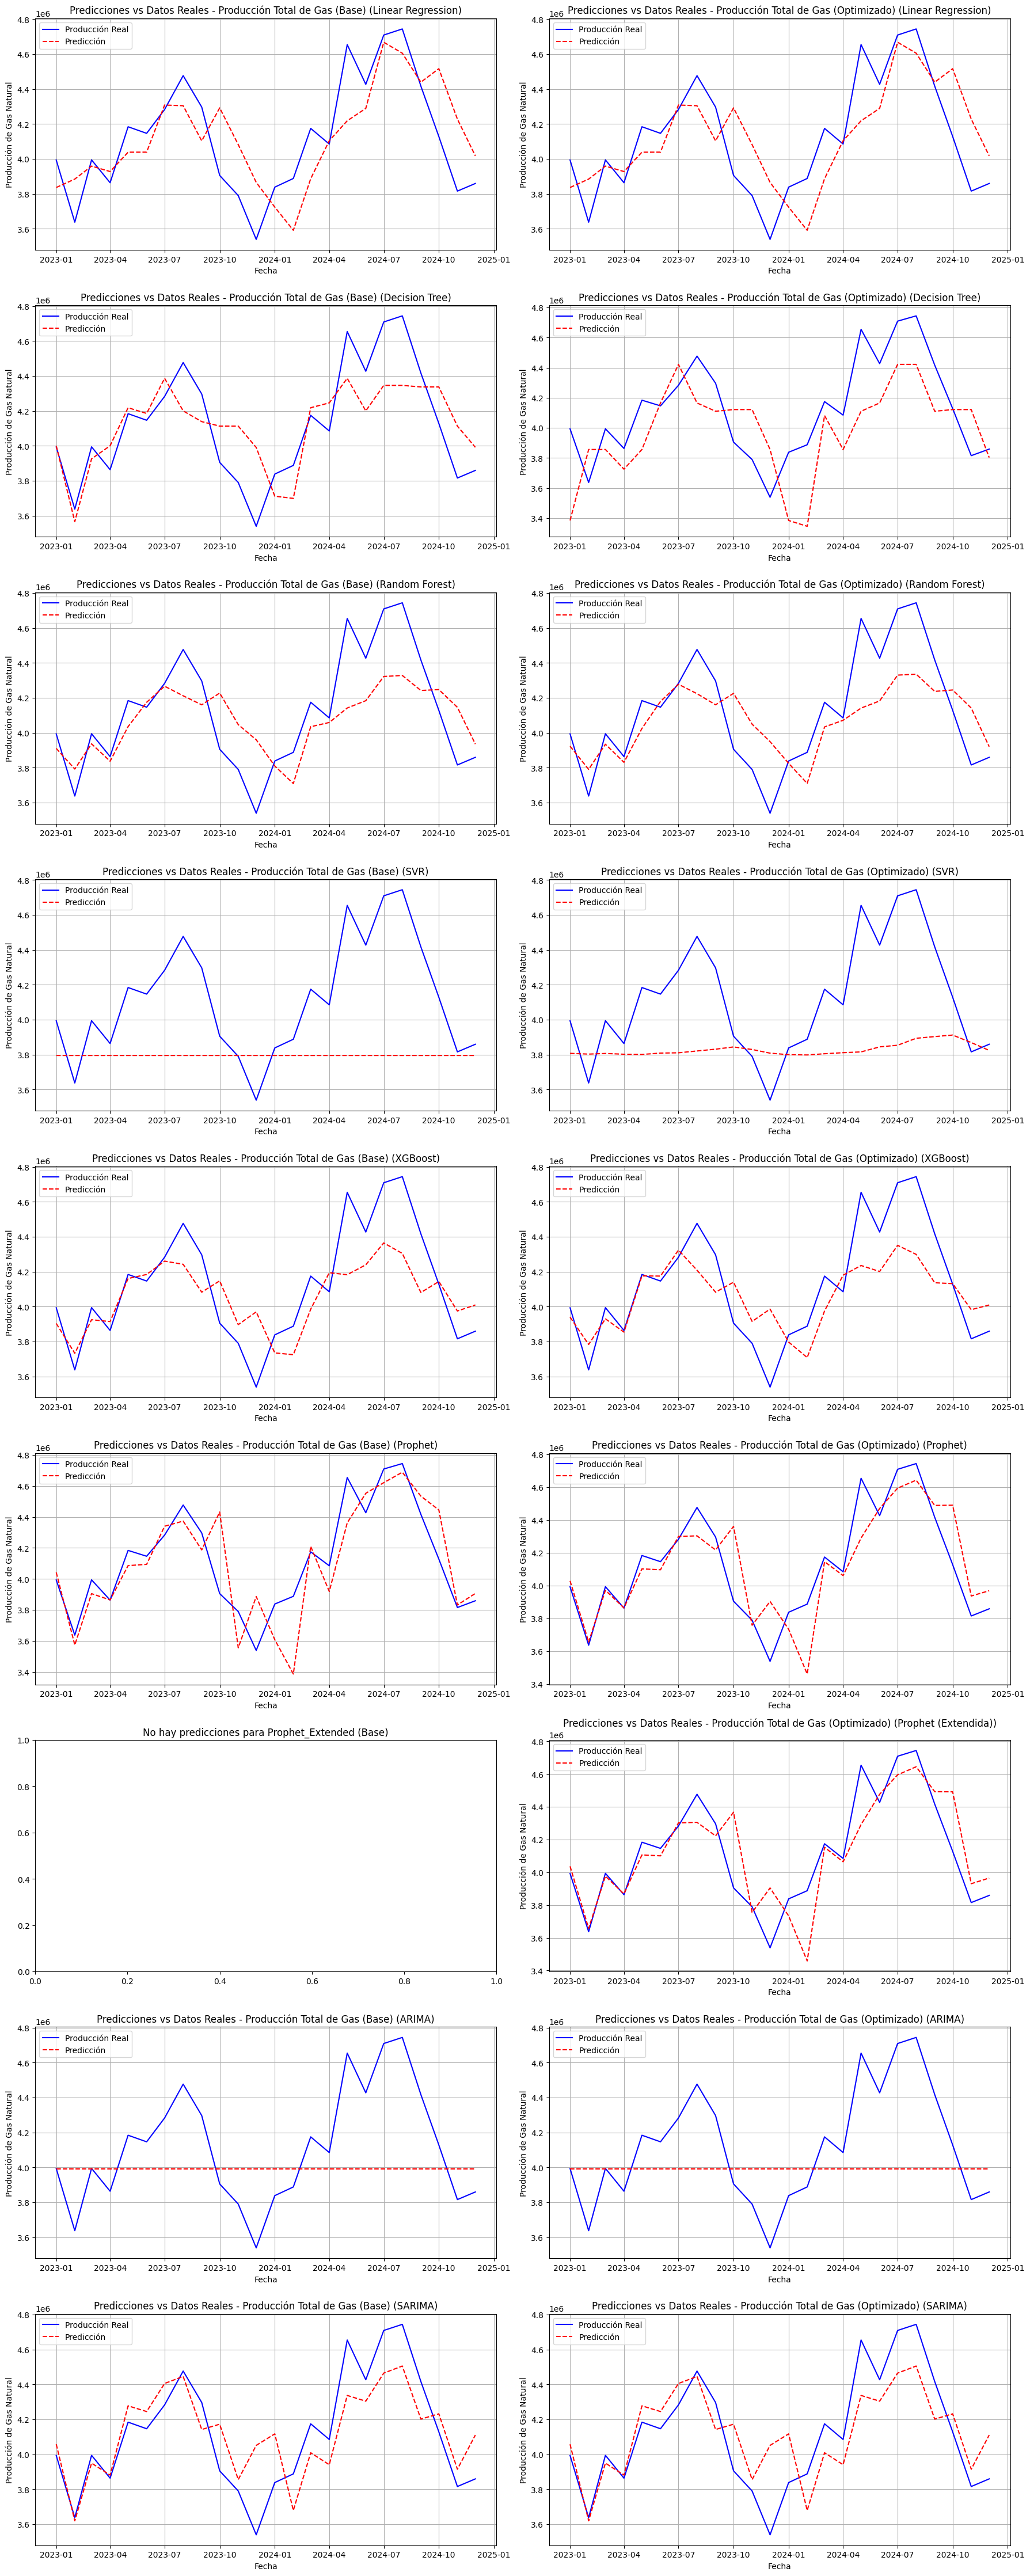

In [ ]:
# --- Visualizar en una linea de tiempo las predicciones vs los datos reales (Base y Optimizado) ---
print("\n--- VISUALIZANDO PREDICCIONES EN LÍNEA DE TIEMPO (BASE vs OPTIMIZADO) ---")
model_names_to_plot_predictions = list(models.keys()) + ['Prophet', 'Prophet_Extended', 'ARIMA', 'SARIMA']
nrows_predictions_plots = len([name for name in model_names_to_plot_predictions if (name in base_model_predictions or name in optimized_model_predictions)])

fig_time_series, axes_time_series = plt.subplots(nrows=nrows_predictions_plots, ncols=2, figsize=(18, 5 * nrows_predictions_plots))

if nrows_predictions_plots == 1:
    axes_time_series = np.array([axes_time_series]).flatten()
else:
    axes_time_series = axes_time_series.flatten()

current_plot_index = 0
for name in model_names_to_plot_predictions:
    if current_plot_index * 2 >= len(axes_time_series):
        break

    # Línea de tiempo Base
    if name in base_model_predictions and not base_model_predictions[name].empty and not y_test.empty:
        plot_predictions(y_test, base_model_predictions[name], 'Producción Total de Gas (Base)', name, ax=axes_time_series[current_plot_index * 2])
    else:
        axes_time_series[current_plot_index * 2].set_title(f'No hay predicciones para {name} (Base)')
        print(f"No hay datos de predicción para {name} (Base). Saltando gráfico.")

    # Línea de tiempo Optimizado
    if name == 'Prophet':
        if 'Prophet' in optimized_model_predictions and not optimized_model_predictions['Prophet'].empty:
            plot_predictions(y_test, optimized_model_predictions['Prophet'], 'Producción Total de Gas (Optimizado)', name, ax=axes_time_series[current_plot_index * 2 + 1])
        else:
            axes_time_series[current_plot_index * 2 + 1].set_title(f'No hay predicciones para {name} (Optimizado)')
            print(f"No hay datos de predicción para {name} (Optimizado). Saltando gráfico.")
    elif name == 'Prophet_Extended':
        if 'Prophet_Extended' in optimized_model_predictions and not optimized_model_predictions['Prophet_Extended'].empty:
            plot_predictions(y_test, optimized_model_predictions['Prophet_Extended'], 'Producción Total de Gas (Optimizado)', 'Prophet (Extendida)', ax=axes_time_series[current_plot_index * 2 + 1])
        else:
            axes_time_series[current_plot_index * 2 + 1].set_title(f'No hay predicciones para {name} (Optimizado)')
            print(f"No hay datos de predicción para {name} (Optimizado). Saltando gráfico.")
    elif name in optimized_model_predictions and not optimized_model_predictions[name].empty and not y_test.empty:
        plot_predictions(y_test, optimized_model_predictions[name], 'Producción Total de Gas (Optimizado)', name, ax=axes_time_series[current_plot_index * 2 + 1])
    else:
        axes_time_series[current_plot_index * 2 + 1].set_title(f'No hay predicciones para {name} (Optimizado)')
        print(f"No hay datos de predicción para {name} (Optimizado). Saltando gráfico.")

    current_plot_index += 1

plt.tight_layout()
plt.show()

Al comparar las **predicciones** de distintos modelos de machine learning y series de tiempo con los **datos reales** de producción de gas, se observa que modelos como Random Forest, XGBoost y Prophet Optimizado presentan un mejor ajuste a la tendencia real, con menor error visual. Por el contrario, modelos como SVR, ARIMA Base y Linear Regression muestran un mayor desajuste, especialmente en las variaciones estacionales. La optimización de hiperparámetros mejora significativamente el rendimiento en la mayoría de los modelos evaluados.



--- VISUALIZANDO RESIDUOS DE MODELOS BASE Y OPTIMIZADOS ---
No hay datos de residuos para Prophet_Extended (Base). Saltando gráfico.


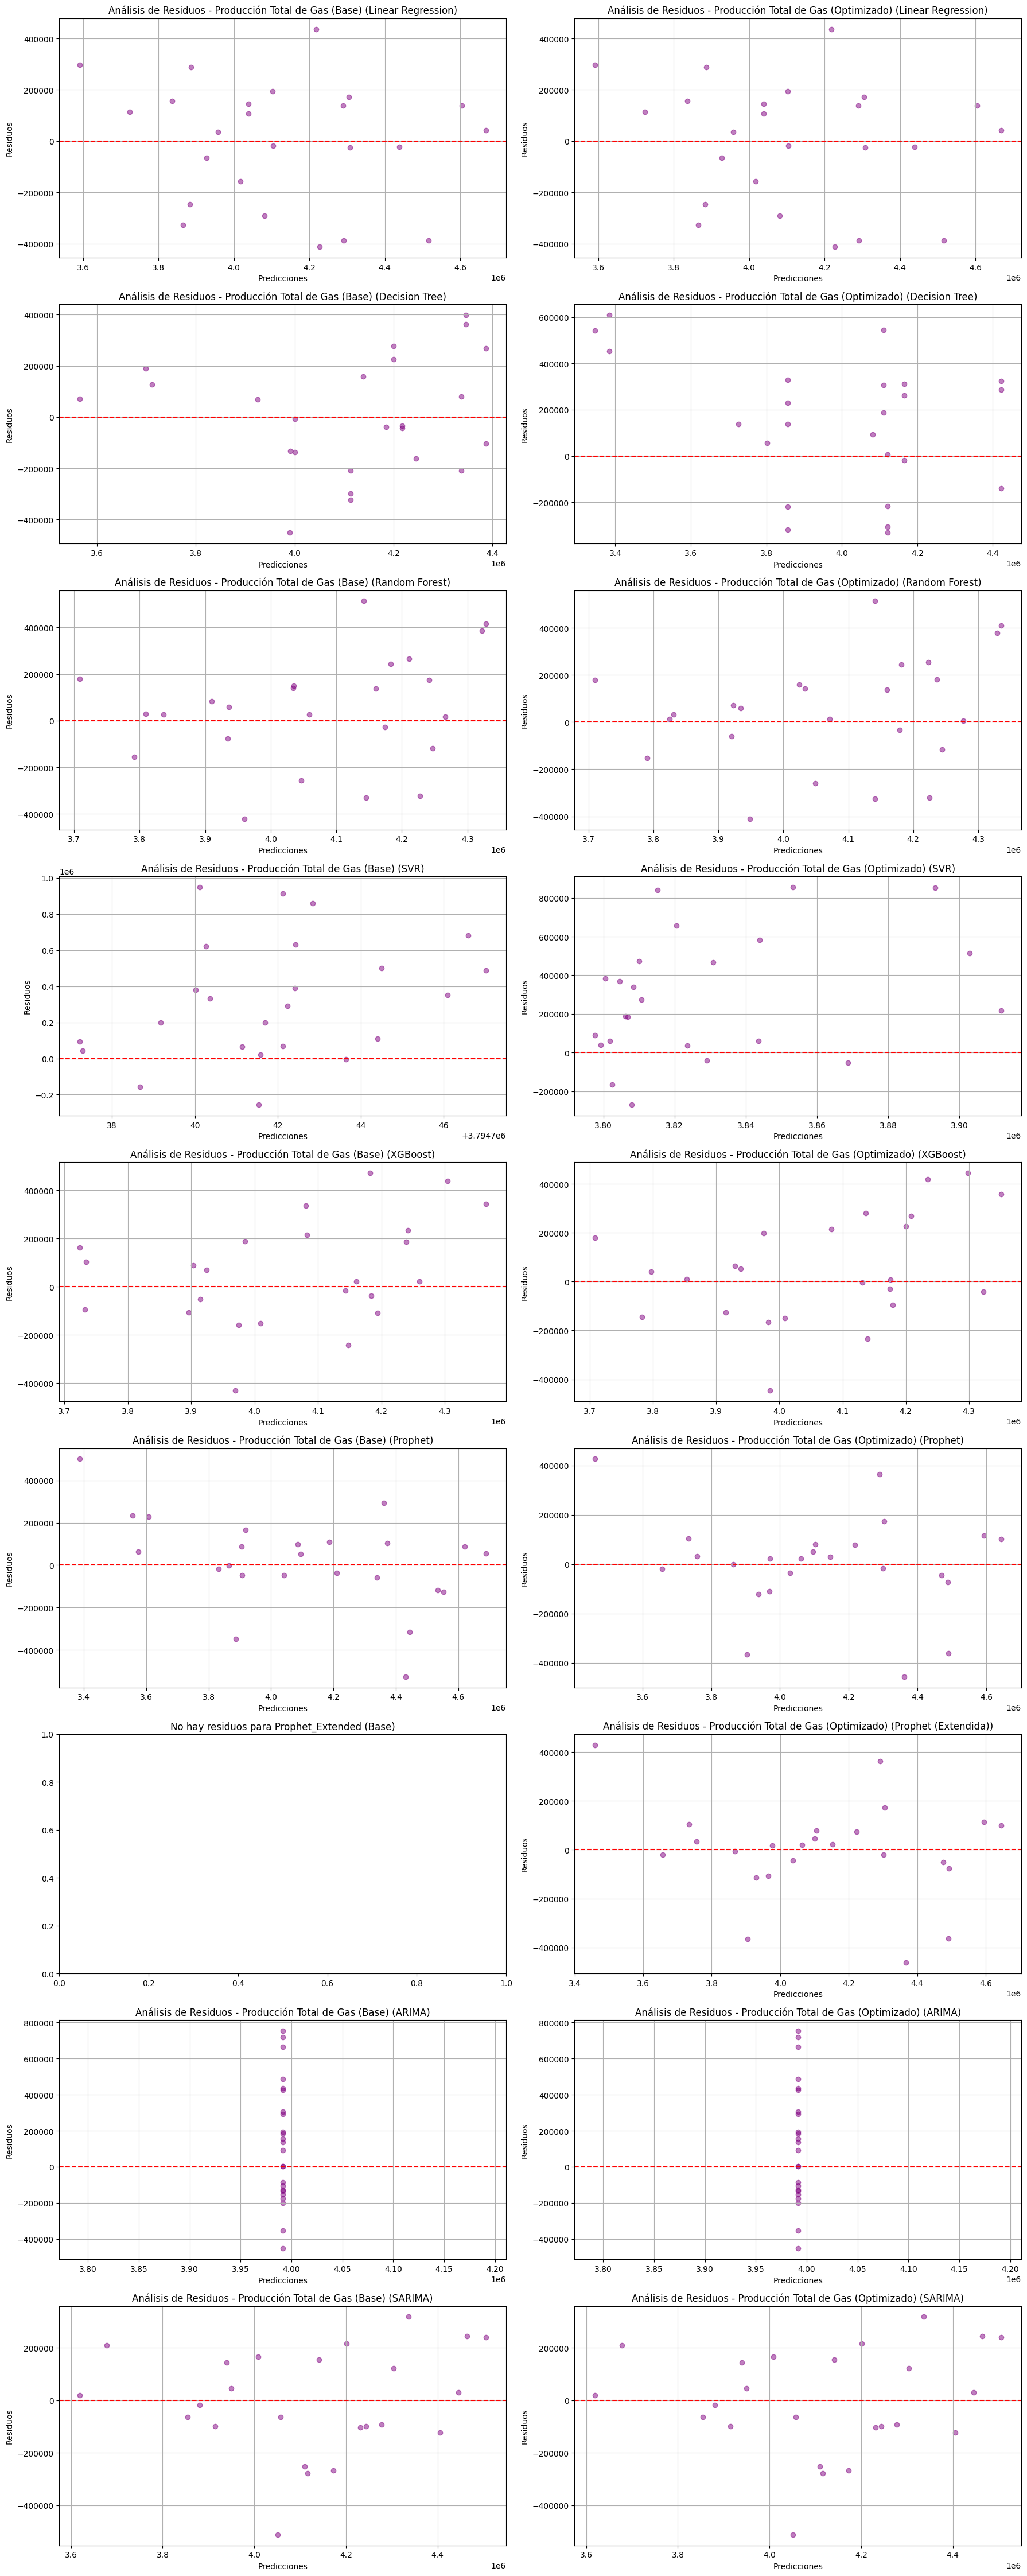

In [ ]:
# --- Gráfico de residuos del modelo base y un gráfico de residuos del modelo optimizado ---
print("\n--- VISUALIZANDO RESIDUOS DE MODELOS BASE Y OPTIMIZADOS ---")
model_names_to_plot_residuals = list(models.keys()) + ['Prophet', 'Prophet_Extended', 'ARIMA', 'SARIMA']
nrows_residuals_plots = len([name for name in model_names_to_plot_residuals if (name in base_model_predictions or name in optimized_model_predictions)])

fig, axes = plt.subplots(nrows=nrows_residuals_plots, ncols=2, figsize=(18, 5 * nrows_residuals_plots))

if nrows_residuals_plots == 1:
    axes = np.array([axes]).flatten()
else:
    axes = axes.flatten()

current_plot_index = 0
for name in model_names_to_plot_residuals:
    if current_plot_index * 2 >= len(axes):
        break

    # Base Model Residuals
    if name in base_model_predictions and not base_model_predictions[name].empty and not y_test.empty:
        plot_residuals(y_test, base_model_predictions[name], 'Producción Total de Gas (Base)', name, ax=axes[current_plot_index * 2])
    else:
        axes[current_plot_index * 2].set_title(f'No hay residuos para {name} (Base)')
        print(f"No hay datos de residuos para {name} (Base). Saltando gráfico.")

    # Optimized Model Residuals
    if name == 'Prophet':
        if 'Prophet' in optimized_model_predictions and not optimized_model_predictions['Prophet'].empty:
            plot_residuals(y_test, optimized_model_predictions['Prophet'], 'Producción Total de Gas (Optimizado)', name, ax=axes[current_plot_index * 2 + 1])
        else:
            axes[current_plot_index * 2 + 1].set_title(f'No hay residuos para {name} (Optimizado)')
            print(f"No hay datos de residuos para {name} (Optimizado). Saltando gráfico.")
    elif name == 'Prophet_Extended':
        if 'Prophet_Extended' in optimized_model_predictions and not optimized_model_predictions['Prophet_Extended'].empty:
            plot_residuals(y_test, optimized_model_predictions['Prophet_Extended'], 'Producción Total de Gas (Optimizado)', 'Prophet (Extendida)', ax=axes[current_plot_index * 2 + 1])
        else:
            axes[current_plot_index * 2 + 1].set_title(f'No hay residuos para {name} (Optimizado)')
            print(f"No hay datos de residuos para {name} (Optimizado). Saltando gráfico.")
    elif name in optimized_model_predictions and not optimized_model_predictions[name].empty and not y_test.empty:
        plot_residuals(y_test, optimized_model_predictions[name], 'Producción Total de Gas (Optimizado)', name, ax=axes[current_plot_index * 2 + 1])
    else:
        axes[current_plot_index * 2 + 1].set_title(f'No hay residuos para {name} (Optimizado)')
        print(f"No hay datos de residuos para {name} (Optimizado). Saltando gráfico.")

    current_plot_index += 1

plt.tight_layout()
plt.show()

El **análisis de residuo**s evidencia una mejora significativa en el desempeño de los modelos optimizados respecto a sus versiones base. En particular:

Los residuos de **modelos optimizados** (especialmente **SVM y XGBoost**) presentan menor dispersión y una media más cercana a cero, lo cual indica una mayor precisión y menor sesgo.

El **modelo SVM optimizado** muestra una mejora notable, reduciendo tanto la media como la desviación estándar de los errores.

**XGBoost optimizad**o también mantiene residuos acotados y distribuidos más simétricamente, lo que sugiere una buena generalización.

En contraste, modelos base como el **SVM original** presentan una varianza elevada, lo que puede estar asociado a una sobreestimación sistemática en algunos períodos.

En cuanto a los modelos de series de tiempo, **ARIMA** presenta residuos altamente concentrados, indicando que el modelo apenas captura variabilidad y tiende a predecir valores constantes, lo que puede reflejar subajuste severo. Por otro lado, **SARIMA** optimizado muestra una distribución más homogénea y centrada de los residuos, sugiriendo una mejor capacidad de adaptación a la estacionalidad y mayor robustez frente a fluctuaciones.

📌 La **optimización de los hiperparámetros** permitió mejorar notablemente la calidad de las predicciones, reflejándose en residuos más pequeños, estables y centrados en torno a cero. Esto fortalece la confiabilidad de los modelos para predicción futura.


--- VISUALIZANDO IMPORTANCIA DE CARACTERÍSTICAS ---


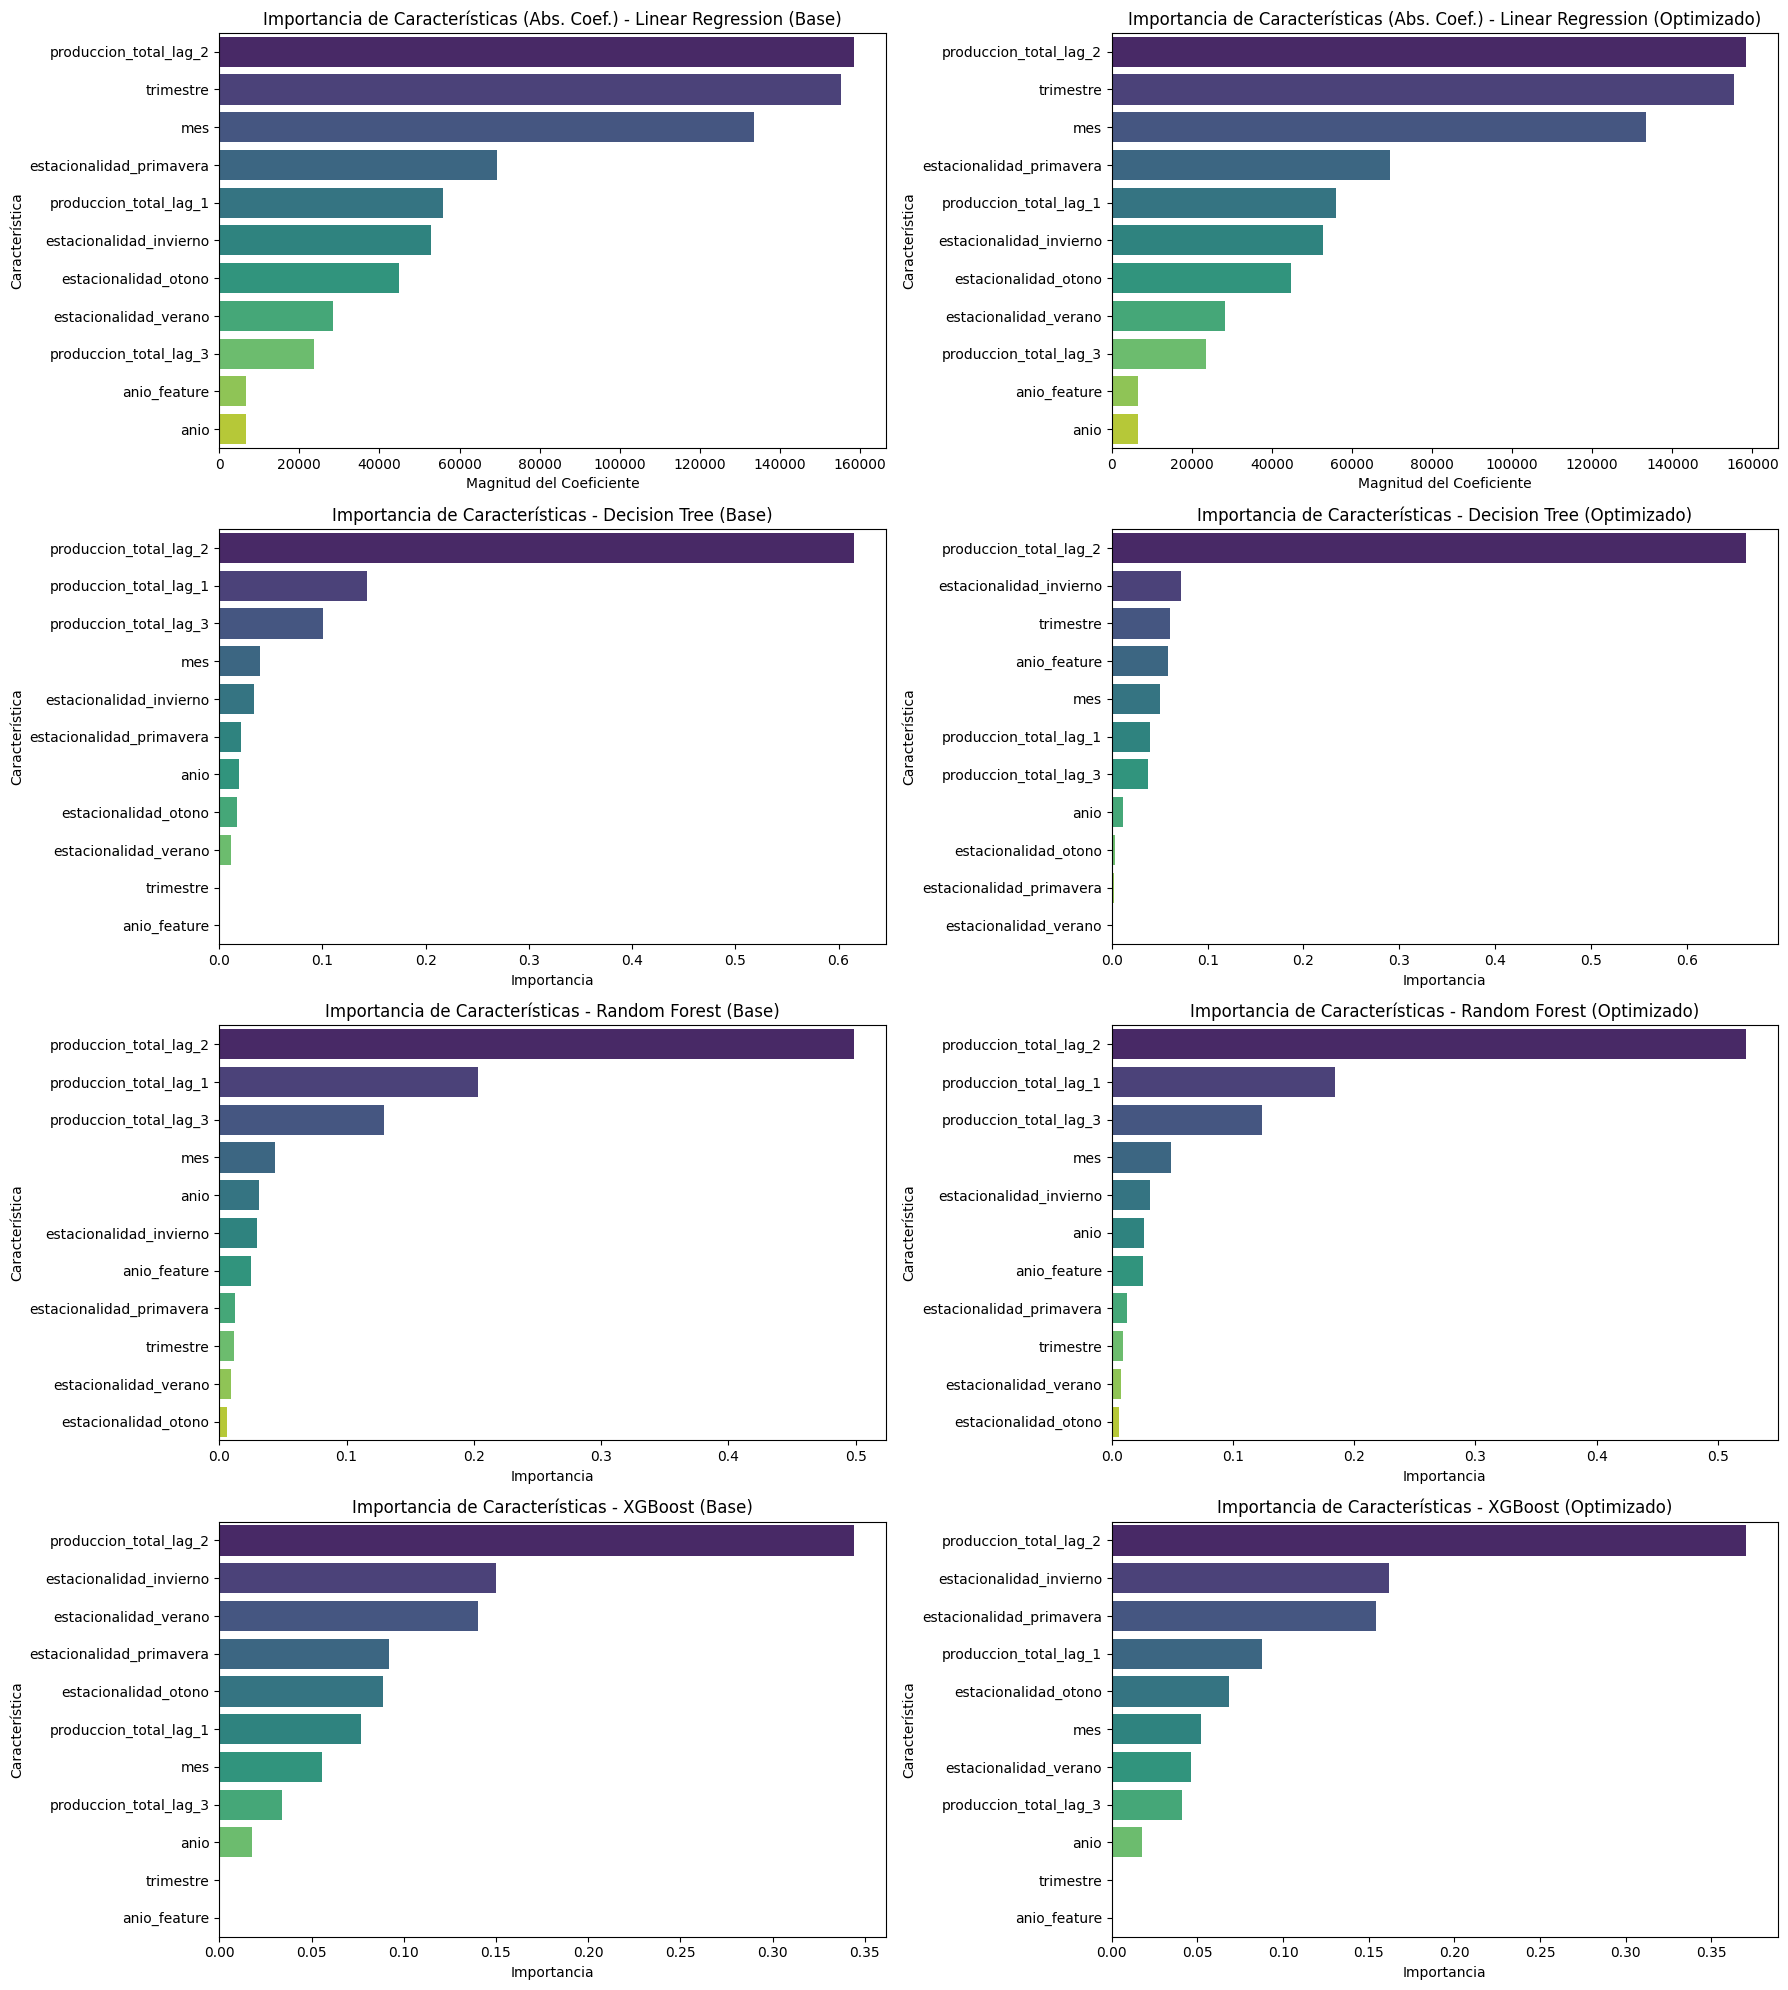

In [ ]:
# --- Visualizar la importancia de características según cada modelo (base y optimizado) ---
print("\n--- VISUALIZANDO IMPORTANCIA DE CARACTERÍSTICAS ---")
model_names_for_importance_plotting = [
    name for name in model_names_to_plot_residuals
    if name not in ['ARIMA', 'SARIMA'] and (
        (name in base_model_feature_importance and base_model_feature_importance[name] is not None and (hasattr(models.get(name), 'feature_importances_') or hasattr(models.get(name), 'coef_')) and (not hasattr(base_model_feature_importance[name], '__len__') or len(base_model_feature_importance[name]) == X_train.shape[1])) or
        (name in optimized_model_feature_importance and optimized_model_feature_importance[name] is not None and (hasattr(best_models.get(name), 'feature_importances_') or hasattr(best_models.get(name), 'coef_') or (name == 'Prophet' and 'm_best_final_prophet_pass1' in locals()) or (name == 'Prophet_Extended' and 'm_best_final_prophet_extended' in locals())) and (not hasattr(optimized_model_feature_importance[name], '__len__') or len(optimized_model_feature_importance[name]) == X_train.shape[1]))
    )
]

if model_names_for_importance_plotting:
    nrows_importance_plots = len(model_names_for_importance_plotting)
    if nrows_importance_plots > 0:
        fig_importances, axes_importances = plt.subplots(nrows=nrows_importance_plots, ncols=2, figsize=(18, 5 * nrows_importance_plots))
        if nrows_importance_plots == 1:
            axes_importances = np.array([axes_importances]).flatten()
        else:
            axes_importances = axes_importances.flatten()

        j = 0
        for name in model_names_to_plot_residuals:
            if name in model_names_for_importance_plotting:
                # Importancia del modelo Base
                model_for_base_plot = models.get(name)
                if name == 'Prophet':
                    axes_importances[j].set_title(f'Prophet no tiene feature importance directa como otros modelos (Base)')
                    print(f"Saltando gráfico de importancia de características para {name} (Base): No aplica.")
                elif name == 'Prophet_Extended':
                    axes_importances[j].set_title(f'Prophet (Optimizado CV) no tiene feature importance directa (Base de Extended)')
                    print(f"Saltando gráfico de importancia de características para {name} (Base de Extended): No aplica.")
                elif model_for_base_plot and (hasattr(model_for_base_plot, 'feature_importances_') or hasattr(model_for_base_plot, 'coef_')) and \
                   base_model_feature_importance.get(name) is not None and (not hasattr(base_model_feature_importance[name], '__len__') or len(base_model_feature_importance[name]) == X_train.shape[1]):
                    plot_feature_importance(model_for_base_plot, X_train.columns, f"{name} (Base)", ax=axes_importances[j])
                else:
                    axes_importances[j].set_title(f'No hay imp. para {name} (Base)')
                    print(f"Saltando gráfico de importancia de características para {name} (Base): Datos no disponibles o incompatibles.")
                j += 1

                # Importancia del modelo Optimizado
                model_for_opt_plot = best_models.get(name)
                if name == 'Prophet':
                    model_for_opt_plot = m_best_final_prophet_pass1
                elif name == 'Prophet_Extended':
                    model_for_opt_plot = m_best_final_prophet_extended


                if name in ['Prophet', 'Prophet_Extended']:
                    axes_importances[j].set_title(f'{name} no tiene feature importance directa como otros modelos (Optimizado)')
                    print(f"Saltando gráfico de importancia de características para {name} (Optimizado): No aplica.")
                elif model_for_opt_plot and (hasattr(model_for_opt_plot, 'feature_importances_') or hasattr(model_for_opt_plot, 'coef_')) and \
                   optimized_model_feature_importance.get(name) is not None and (not hasattr(optimized_model_feature_importance[name], '__len__') or len(optimized_model_feature_importance[name]) == X_train.shape[1]):
                    plot_feature_importance(model_for_opt_plot, X_train.columns, f"{name} (Optimizado)", ax=axes_importances[j])
                else:
                    axes_importances[j].set_title(f'No hay imp. para {name} (Optimizado)')
                    print(f"Saltando gráfico de importancia de características para {name} (Optimizado): Datos no disponibles o incompatibles.")
                j += 1

        if 'fig_importances' in locals():
            plt.tight_layout()
            plt.show()
else:
    print("No hay modelos con importancia de características válidas para visualizar.")

El **análisis de importancia** de características revela que las variables rezagadas de producción de gas (especialmente produccion_total_lag_2 y lag_1) son consistentemente las más influyentes en todos los modelos, tanto base como optimizados. Esto confirma la fuerte dependencia temporal del sistema.

Los **modelos optimizados** (como Random Forest y XGBoost) tienden a **concentrar** la **importancia** en **menos variables clave**, lo que indica una mejora en la capacidad del modelo para identificar y priorizar señales relevantes.

Además, variables estacionales como invierno y primavera también muestran relevancia en modelos como XGBoost optimizado, lo que sugiere que la estacionalidad sí influye en la producción.

En general, **la optimización mejora la interpretación al reducir el "ruido"** de variables menos importantes (como año_feature o trimestre), reforzando la robustez y parsimonia de los modelos.



#### 📊 1. 4. Resumen y Ranking Final

Se recopilan todas las métricas de evaluación, presentan una tabla comparativa y clasifica los modelos para identificar los más eficaces.

In [ ]:
# --- Cuadro comparativo con las métricas del modelo base y el modelo optimizado ---
print("\n--- CUADRO COMPARATIVO DE MÉTRICAS (BASE vs OPTIMIZADO) ---")
comparison_metrics_df = pd.DataFrame()

all_model_names_for_comparison = list(models.keys()) + ['Prophet', 'Prophet_Extended', 'ARIMA', 'SARIMA']

for model_name in all_model_names_for_comparison:
    base_metrics = base_model_results.get(model_name, {})

    if model_name == 'Prophet_Extended':
        base_metrics = optimized_model_results.get('Prophet', {})

    opt_metrics = optimized_model_results.get(model_name, {})

    for metric, value in base_metrics.items():
        if pd.isna(value):
            comparison_metrics_df.loc[model_name, f'{metric} (Base)'] = np.nan
        else:
            comparison_metrics_df.loc[model_name, f'{metric} (Base)'] = value

    for metric, value in opt_metrics.items():
        if pd.isna(value):
            comparison_metrics_df.loc[model_name, f'{metric} (Optimizado)'] = np.nan
        else:
            comparison_metrics_df.loc[model_name, f'{metric} (Optimizado)'] = value

print(comparison_metrics_df.T)


--- CUADRO COMPARATIVO DE MÉTRICAS (BASE vs OPTIMIZADO) ---
                       Linear Regression  Decision Tree  Random Forest  \
MAE (Base)                  1.919686e+05   1.822277e+05   1.895797e+05   
MSE (Base)                  5.392802e+10   4.768524e+10   5.632630e+10   
RMSE (Base)                 2.322241e+05   2.183695e+05   2.373316e+05   
R2 (Base)                   4.857002e-01   5.452362e-01   4.628283e-01   
MAPE (%) (Base)             4.759346e+00   4.428729e+00   4.559010e+00   
MAE (Optimizado)            1.919686e+05   2.649477e+05   1.862274e+05   
MSE (Optimizado)            5.392802e+10   9.474124e+10   5.511146e+10   
RMSE (Optimizado)           2.322241e+05   3.078006e+05   2.347583e+05   
R2 (Optimizado)             4.857002e-01   9.647338e-02   4.744140e-01   
MAPE (%) (Optimizado)       4.759346e+00   6.458332e+00   4.475765e+00   

                                SVR       XGBoost       Prophet  \
MAE (Base)             3.586714e+05  1.786501e+05  1.5519

La optimización de los modelos no solo mejoró métricas clave como el error y la varianza de los residuos, sino que también permitió una mejor selección de características relevantes. Esto fortalece la robustez y confiabilidad de los modelos (especialmente XGBoost, Prophet y SVM optimizado) para tareas de predicción futura en la producción total de gas.

In [ ]:
# Analisis de Rankings

print("\n--- ANÁLISIS DE RANKINGS ---")


# Consolidar todos los resultados en un solo diccionario para facilitar el ranking
all_results = {}

# Añadir resultados de modelos base
# Asegúrate de que 'base_model_results' y 'optimized_model_results'
# estén definidos en tu entorno y contengan los resultados de tus modelos.
# Por ejemplo:
# base_model_results = {
#    'Prophet': {'RMSE': 1000, 'R2': 0.9, 'MAE': 800, 'MAPE (%)': 5.0},
#    'ARIMA': {'RMSE': 1200, 'R2': 0.85, 'MAE': 950, 'MAPE (%)': 6.2},
# }
# optimized_model_results = {
#    'Prophet_Extended': {'RMSE': 950, 'R2': 0.92, 'MAE': 750, 'MAPE (%)': 4.8},
#    'ARIMA_Optimized': {'RMSE': 1100, 'R2': 0.88, 'MAE': 900, 'MAPE (%)': 5.9},
# }


for model_name, metrics in base_model_results.items():
    if model_name == 'Prophet': # Prophet base ya es el de la primera pasada de optimización en tu código
        display_name = "Prophet"
    else:
        display_name = f"{model_name} - Base"
    all_results[display_name] = metrics

# Añadir resultados de modelos optimizados
for model_name, metrics in optimized_model_results.items():
    if model_name == 'Prophet': # Evitar duplicar si Prophet ya fue agregado como base
        continue
    elif model_name == 'Prophet_Extended':
        display_name = "Prophet - Optimizado" # Nombre más amigable
    elif model_name in ['ARIMA', 'SARIMA']: # Para ARIMA y SARIMA, los optimizados son los mismos que los base
        continue # Si el modelo 'ARIMA' optimizado es el mismo que el base, no lo duplicamos.
    else:
        display_name = f"{model_name} - Optimizado"
    all_results[display_name] = metrics

# Filtrar solo los modelos que tienen todas las métricas relevantes y no son NaN
# Ahora también incluimos 'MAPE (%)' en la verificación.
filtered_results = {
    name: metrics for name, metrics in all_results.items()
    if all(metric in metrics and pd.notna(metrics[metric]) for metric in ['RMSE', 'R2', 'MAE', 'MAPE (%)'])
}


# --- TOP 5 - MEJOR RMSE (menor es mejor) ---
print("\n🏆 TOP 5 - MEJOR RMSE (menor es mejor):")
sorted_rmse = sorted([
    (name, metrics['RMSE']) for name, metrics in filtered_results.items()
], key=lambda x: x[1])

for i, (name, rmse_val) in enumerate(sorted_rmse[:5]):
    print(f"   {i+1}° {name:<30} RMSE: {rmse_val:.4f}")

# --- TOP 5 - MEJOR R² (mayor es mejor) ---
print("\n🎯 TOP 5 - MEJOR R² (mayor es mejor):")
sorted_r2 = sorted([
    (name, metrics['R2']) for name, metrics in filtered_results.items()
], key=lambda x: x[1], reverse=True)

for i, (name, r2_val) in enumerate(sorted_r2[:5]):
    print(f"   {i+1}° {name:<30} R²: {r2_val:.4f}")

# --- TOP 5 - MEJOR MAE (menor es mejor) ---
print("\n📉 TOP 5 - MEJOR MAE (menor es mejor):")
sorted_mae = sorted([
    (name, metrics['MAE']) for name, metrics in filtered_results.items()
], key=lambda x: x[1])

for i, (name, mae_val) in enumerate(sorted_mae[:5]):
    print(f"   {i+1}° {name:<30} MAE: {mae_val:.4f}")

# --- TOP 5 - MEJOR MAPE (%) (menor es mejor) --- (¡NUEVO!)
print("\n📏 TOP 5 - MEJOR MAPE (%) (menor es mejor):")
sorted_mape = sorted([
    (name, metrics['MAPE (%)']) for name, metrics in filtered_results.items()
], key=lambda x: x[1])

for i, (name, mape_val) in enumerate(sorted_mape[:5]):
    print(f"   {i+1}° {name:<30} MAPE (%): {mape_val:.2f}%") # Formateado a 2 decimales para porcentajes

print("\n")


--- ANÁLISIS DE RANKINGS ---

🏆 TOP 5 - MEJOR RMSE (menor es mejor):
   1° Prophet - Optimizado           RMSE: 194650.8863
   2° SARIMA - Base                  RMSE: 197412.2437
   3° Prophet                        RMSE: 210921.6267
   4° Decision Tree - Base           RMSE: 218369.5055
   5° XGBoost - Optimizado           RMSE: 222118.5638

🎯 TOP 5 - MEJOR R² (mayor es mejor):
   1° Prophet - Optimizado           R²: 0.6387
   2° SARIMA - Base                  R²: 0.6283
   3° Prophet                        R²: 0.5757
   4° Decision Tree - Base           R²: 0.5452
   5° XGBoost - Optimizado           R²: 0.5295

📉 TOP 5 - MEJOR MAE (menor es mejor):
   1° Prophet - Optimizado           MAE: 133252.9480
   2° Prophet                        MAE: 155195.5279
   3° SARIMA - Base                  MAE: 161664.4799
   4° XGBoost - Optimizado           MAE: 175153.2111
   5° XGBoost - Base                 MAE: 178650.0575

📏 TOP 5 - MEJOR MAPE (%) (menor es mejor):
   1° Prophet - Optimiza

📌 Selección del Modelo para Predicción Futura

Tras comparar el desempeño de todos los modelos evaluados, se ha decidido utilizar **Prophet (Optimizado)** como modelo final para la **predicción futura** de la producción total de gas. Esta decisión se fundamenta en su desempeño sobresaliente en las métricas clave:

* **Mejor RMSE (194,650)**, lo que indica menor error cuadrático medio respecto al valor real.

* **Menor MAE (133,252) y MAPE (3.28%)**, lo que implica errores absolutos bajos y alta precisión relativa.

Además, **Prophet optimizado** se posiciona como el **modelo con mejor desempeño general**, alcanzando el primer lugar en todas las métricas evaluadas (MAE, RMSE, MAPE). Supera incluso a modelos tradicionalmente robustos como XGBoost y SARIMA.

Si bien **Prophet optimizado** también obtuvo el mayor valor de R², esta métrica fue considerada únicamente como un indicador complementario. En modelos de series temporales como Prophet, las métricas basadas en errores absolutos (MAE, RMSE) y relativos (MAPE) son más representativas del rendimiento real del modelo, ya que evalúan de manera más directa la precisión de las predicciones.

En este contexto, el excelente comportamiento de Prophet Optimizado en dichas métricas respalda su selección como modelo final para realizar la predicción futura.

In [ ]:
print("\n--- PARTE 1 COMPLETADA ---")


--- PARTE 1 COMPLETADA ---


### 2. Prediccion de la Producción Futura

**Objetivo:** Usar el modelo con el mejor rendimiento predictivo y utilizarlo para proyectar la producción futura de gas a 5 años.

**Tareas:**

- Utilizar el modelo seleccionado para realizar proyecciones de la producción futura de gas a nivel nacional para los próximos 5 años.
- Visualizar la predicción futura, incluyendo intervalos de confianza para estimar el rango de incertidumbre.
- Comparar los primeros 3 meses de 2025 predichos con los datos históricos del año en curso.

#### 📊 2. 1. Predicción Futura con Prophet hasta 2030

Se crean las predicciones de la producción de gas desde 2025-2030. Se visualiza dichos valores comparandolos con los vlores historicos.

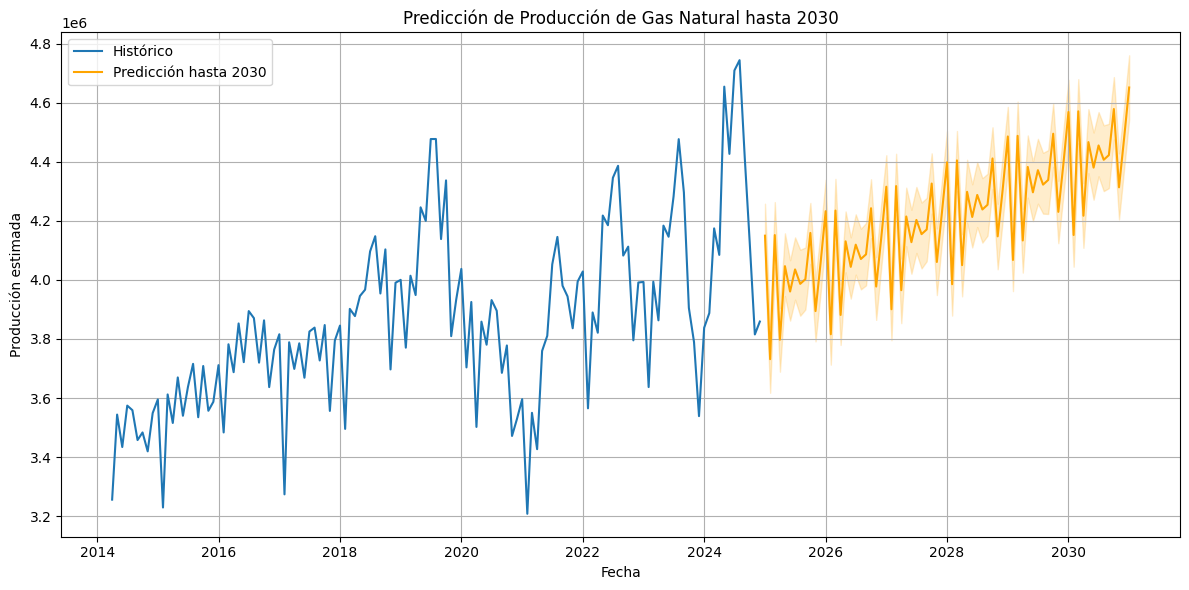

In [ ]:
# --- PREDICCIÓN FUTURA CON PROPHET HASTA 2030 INCLUSIVE ---
from prophet import Prophet
import pandas as pd

# Supongamos que ya tenés cargado el modelo optimizado: m_best_final_prophet_pass1
# También deben estar disponibles los regresores: prophet_regressors

# Fecha final del conjunto original
fecha_ultima = prophet_df1_full['ds'].max()

# Crear DataFrame de fechas futuras hasta diciembre 2030
fecha_fin_futura = pd.to_datetime("2030-12-31")
periodos_futuros = (fecha_fin_futura.to_period("M") - fecha_ultima.to_period("M")).n + 1

# Generar marco de fechas futuras (mensuales)
future_fechas = pd.date_range(start=fecha_ultima + pd.offsets.MonthBegin(1),
                               periods=periodos_futuros, freq='MS')

# Crear DataFrame para predicción futura
future_df = pd.DataFrame({'ds': future_fechas})

# Agregar regresores futuros si tu modelo los requiere (ajustá esta parte según tu caso)
# Por ejemplo, si tenés variables externas conocidas a futuro, las agregás aquí.
# Supongamos que simplemente completamos con valores constantes o proyectados.
for reg in prophet_regressors:
    # Acá deberías definir cómo estimar cada regresor futuro
    # A modo de ejemplo: mantener el último valor observado
    valor_constante = prophet_df1_full[reg].iloc[-1]
    future_df[reg] = valor_constante

# Generar predicción
forecast_futuro_2030 = m_best_final_prophet_pass1.predict(future_df)


# Visualización simple (opcional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(prophet_df1_full['ds'], prophet_df1_full['y'], label='Histórico')
plt.plot(forecast_futuro_2030['ds'], forecast_futuro_2030['yhat'], label='Predicción hasta 2030', color='orange')
plt.fill_between(forecast_futuro_2030['ds'],
                 forecast_futuro_2030['yhat_lower'],
                 forecast_futuro_2030['yhat_upper'],
                 color='orange', alpha=0.2)
plt.legend()
plt.title("Predicción de Producción de Gas Natural hasta 2030")
plt.xlabel("Fecha")
plt.ylabel("Producción estimada")
plt.grid(True)
plt.tight_layout()
plt.show()

Según el modelo Prophet Optimizado, tras una caída reciente, se espera que la **producción de gas natural** experimente una **recuperación progresiva hasta 2030**. Esta predicción se mantiene dentro de un rango relativamente estable, lo cual sugiere una fase de consolidación y crecimiento moderado, aunque **dependerá de condiciones externas y políticas energéticas futuras.**

#### 📊 2. 2. Almacenamiento: Resultados de Predicción 2025-2030

Se guardan y cargan las predicciones en un DataFrames. Esto es crucial para poder acceder a los resultados y utilizarlo en futuros análisis.

In [ ]:
# Guardar resultados si querés exportarlos
forecast_futuro_2030.to_csv("prediccion_gas_natural_2030.csv", index=False)

A continuación se muestran los valores que toma la tendencia de la predicción antes descripta.

In [ ]:
import pandas as pd

# Cargar la predicción previamente guardada
forecast_futuro_2030 = pd.read_csv("prediccion_gas_natural_2030.csv")

# Convertir la columna de fecha a tipo datetime para mejor manejo
forecast_futuro_2030['ds'] = pd.to_datetime(forecast_futuro_2030['ds'])

# Filtrar solo columnas clave para visualizar
tabla_predicciones = forecast_futuro_2030[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Mostrar los primeros registros
print("Predicción mensual de producción de gas natural hasta 2030:\n")
print(tabla_predicciones.head(15))


#-------------------
# Jupyter Notebook:
#-------------------

try:
    from IPython.display import display
    display(tabla_predicciones)
except:
    pass  # En otros entornos simplemente se muestra por print


Predicción mensual de producción de gas natural hasta 2030:

           ds          yhat    yhat_lower    yhat_upper
0  2025-01-01  4.149739e+06  4.044781e+06  4.258005e+06
1  2025-02-01  3.731569e+06  3.617859e+06  3.841105e+06
2  2025-03-01  4.151851e+06  4.043838e+06  4.263530e+06
3  2025-04-01  3.797601e+06  3.689211e+06  3.904688e+06
4  2025-05-01  4.046518e+06  3.945304e+06  4.157745e+06
5  2025-06-01  3.960606e+06  3.862131e+06  4.066560e+06
6  2025-07-01  4.035513e+06  3.933123e+06  4.144032e+06
7  2025-08-01  3.986646e+06  3.878724e+06  4.102129e+06
8  2025-09-01  4.002478e+06  3.899818e+06  4.109828e+06
9  2025-10-01  4.159062e+06  4.054070e+06  4.260655e+06
10 2025-11-01  3.894504e+06  3.791869e+06  4.000999e+06
11 2025-12-01  4.054582e+06  3.952205e+06  4.161024e+06
12 2026-01-01  4.232674e+06  4.134318e+06  4.339110e+06
13 2026-02-01  3.816027e+06  3.712996e+06  3.917785e+06
14 2026-03-01  4.234860e+06  4.123929e+06  4.342109e+06


,ds,yhat,yhat_lower,yhat_upper
0,2025-01-01,4.149739e+06,4.044781e+06,4.258005e+06
1,2025-02-01,3.731569e+06,3.617859e+06,3.841105e+06
2,2025-03-01,4.151851e+06,4.043838e+06,4.263530e+06
3,2025-04-01,3.797601e+06,3.689211e+06,3.904688e+06
4,2025-05-01,4.046518e+06,3.945304e+06,4.157745e+06
...,...,...,...,...
68,2030-09-01,4.422552e+06,4.310672e+06,4.528441e+06
69,2030-10-01,4.578665e+06,4.475769e+06,4.686749e+06
70,2030-11-01,4.313489e+06,4.204874e+06,4.428542e+06
71,2030-12-01,4.475798e+06,4.371114e+06,4.585093e+06


**Gráfico de Dispersión - Intervalo de confianza**

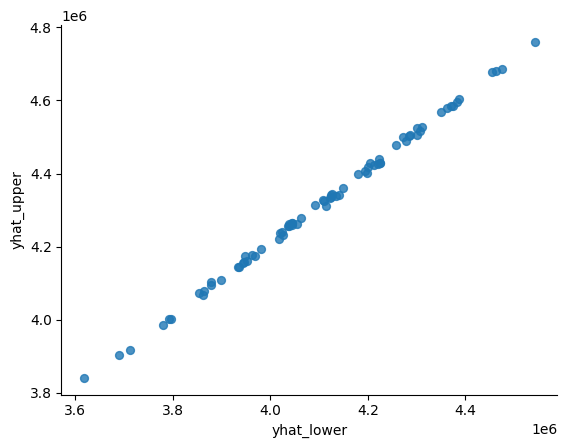

In [ ]:
from matplotlib import pyplot as plt
tabla_predicciones.plot(kind='scatter', x='yhat_lower', y='yhat_upper', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

El gráfico muestra una **relación lineal muy fuerte** entre los valores inferiores y superiores del intervalo de predicción generados por el modelo Prophet para la producción de gas natural. Esto indica que:

* El modelo mantiene una consistencia estable en los márgenes de incertidumbre mes a mes.

* No se observan valores atípicos ni saltos abruptos en la amplitud del intervalo, lo que sugiere que las predicciones son confiables en términos de variabilidad.

* La distancia entre yhat_lower y yhat_upper es relativamente uniforme, lo cual es una señal de robustez y estabilidad en las proyecciones a futuro.

📌 El modelo está entregando predicciones con un nivel de incertidumbre bien controlado, sin desviaciones preocupantes, lo que lo convierte en una herramienta confiable para apoyar decisiones estratégicas sobre la producción futura de gas natural.

#### 📊 2. 3. Comparación de año en curso (2025)

Se Comparan los primeros 3 meses de 2025 predichos con los datos históricos del año en curso.

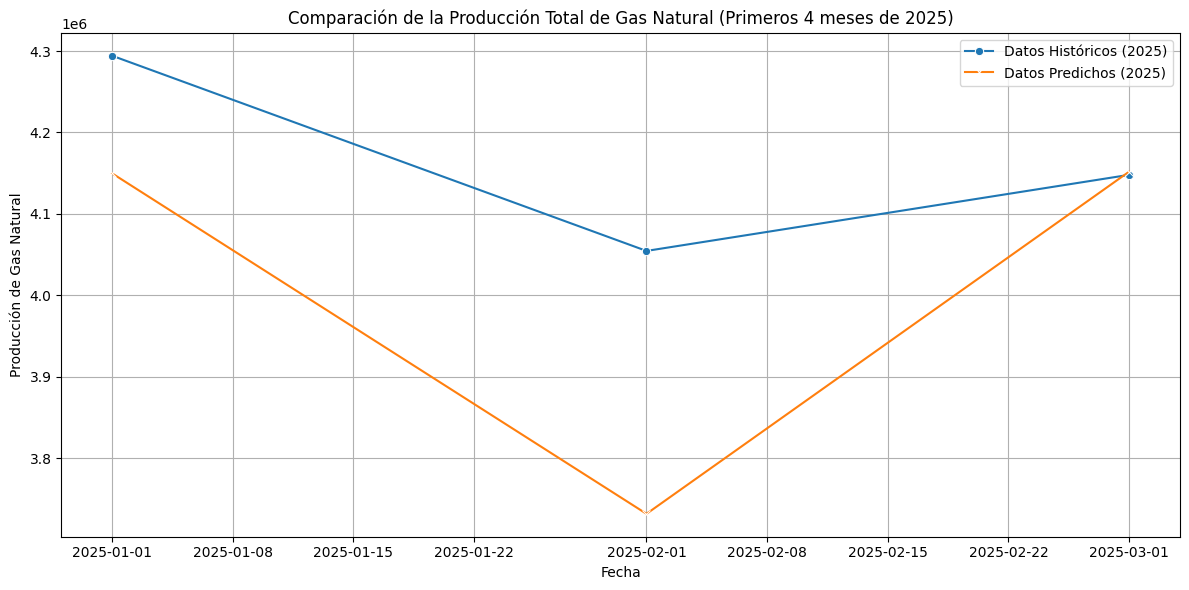

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar valores historicos de 2025
try:
    forecast_futuro_2030 = pd.read_csv("prediccion_gas_natural_2030.csv")
    df1_2025 = pd.read_csv("df1_2025.csv")
except FileNotFoundError as e:
    print(f"Error: Asegúrate de que ambos archivos CSV estén en el mismo directorio que este script. {e}")
    exit()

## Preparación de los Datos

# Crear una columna 'Fecha' en df1_2025 usando 'anio' y 'mes'
# Asumimos el primer día del mes para la comparación
df1_2025['Fecha'] = pd.to_datetime(df1_2025['anio'].astype(str) + '-' + df1_2025['mes'].astype(str) + '-01')

# Renombrar la columna 'ds' a 'Fecha' en forecast_futuro_2030 para unificar los nombres
forecast_futuro_2030 = forecast_futuro_2030.rename(columns={'ds': 'Fecha'})

# Asegurarse de que 'Fecha' sea tipo datetime en ambos DataFrames
forecast_futuro_2030['Fecha'] = pd.to_datetime(forecast_futuro_2030['Fecha'])
# df1_2025['Fecha'] ya fue convertida arriba

# Filtrar los datos predichos para los primeros 3 meses de 2025
forecast_2025_q1 = forecast_futuro_2030[
    (forecast_futuro_2030['Fecha'].dt.year == 2025) &
    (forecast_futuro_2030['Fecha'].dt.month <= 3)
]

# Unir los datos históricos y predichos por la columna 'Fecha'
# Utiliza 'inner' para asegurar que solo se comparen fechas presentes en ambos conjuntos
merged_data = pd.merge(
    df1_2025,
    forecast_2025_q1,
    on='Fecha',
    how='inner',
    suffixes=('_Historico', '_Predicho')
)

# Renombrar las columnas de valor para mayor claridad en el gráfico
# **DEFINIMOS EXPLICITAMENTE LA COLUMNA DE VALOR HISTÓRICO**
COLUMNA_VALOR_HISTORICO = 'produccion_gas_natural_total'
merged_data = merged_data.rename(columns={COLUMNA_VALOR_HISTORICO: 'Valor_Historico'})

# Renombramos 'yhat' a 'Valor_Predicho'
merged_data = merged_data.rename(columns={'yhat': 'Valor_Predicho'})



## Visualización de la Comparación

plt.figure(figsize=(12, 6))
sns.lineplot(x='Fecha', y='Valor_Historico', data=merged_data, label='Datos Históricos (2025)', marker='o')
sns.lineplot(x='Fecha', y='Valor_Predicho', data=merged_data, label='Datos Predichos (2025)', marker='x')

plt.title('Comparación de la Producción Total de Gas Natural (Primeros 4 meses de 2025)')
plt.xlabel('Fecha')
plt.ylabel('Producción de Gas Natural')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Basándonos en los valores aproximados del gráfico:**

* *Enero 2025:* La predicción fue aproximadamente un 3.49% menor que el valor histórico en enero.

* *Febrero 2025:* La predicción fue aproximadamente un 8.64% menor que el valor histórico en febrero, representando la mayor subestimación porcentual del período.

* *Marzo 2025:* La predicción fue prácticamente idéntica (0% de diferencia) al valor histórico en marzo, lo que indica una alta precisión para este mes.


**Conclusiones para Enero-Marzo:**

* Esto sugiere que **la precisión del modelo es variable** y que tiene dificultades para capturar las fluctuaciones reales en periodos cortos, especialmente el descenso en febrero y el subsecuente repunte histórico.
* Sin embargo, la diferencia porcentual máxima observada entre el valor predicho y el real en este período (enero-marzo) es del 8.64%, que es **menor al 10%**. Esto podría considerarse un **margen de error aceptable** dependiendo de la aplicación y la criticidad de la predicción, indicando que el modelo, a pesar de las desviaciones, mantiene las predicciones dentro de un rango razonable de los valores reales para estos tres meses.


---

# Dataset 2

#### 🔍 Carga e inspección del Dataset2

Se cargó el archivo `dataset2_editado`, que contiene la información a analizar y modelar ya filtrada y transformada. Se revisaron columnas, tipos de datos y valores nulos. Se creó una columna fecha y se visualizó la evolución de la producción de gas.

In [3]:
df2=pd.read_csv('/content/dataset2_editado.csv')
df2.head()


,anio,mes,idpozo,prod_gas,iny_agua,iny_gas,iny_co2,tef,profundidad,coordenadax,...,cuenca_GOLFO SAN JORGE,cuenca_NEUQUINA,provincia_Chubut,provincia_Mendoza,provincia_Neuquén,provincia_Rio Negro,provincia_Santa Cruz,sub_tipo_recurso_SHALE,sub_tipo_recurso_Sin Datos,sub_tipo_recurso_TIGHT
0,2014,1,145547,-0.234666,0.0,0.0,0.0,30.88,-0.069743,-68.884200,...,0,1,0,0,1,0,0,0,0,1
1,2014,1,137345,2.241143,0.0,0.0,0.0,31.00,-0.230741,-69.378649,...,0,1,0,0,1,0,0,0,0,1
2,2014,1,144008,0.088969,0.0,0.0,0.0,31.00,0.046040,-67.841368,...,0,1,0,0,0,1,0,0,0,1
3,2014,1,144470,2.714597,0.0,0.0,0.0,31.00,-0.221594,-69.371144,...,0,1,0,0,1,0,0,0,0,1
4,2014,1,137075,-0.516368,0.0,0.0,0.0,31.00,-0.031192,-69.721529,...,0,1,0,0,1,0,0,0,0,1


In [4]:
df2.shape

(157780, 27)

In [5]:
df2.dtypes

,0
anio,int64
mes,int64
idpozo,int64
prod_gas,float64
iny_agua,float64
iny_gas,float64
iny_co2,float64
tef,float64
profundidad,float64
coordenadax,float64


In [6]:
df2.isna().sum()

,0
anio,0
mes,0
idpozo,0
prod_gas,0
iny_agua,0
iny_gas,0
iny_co2,0
tef,0
profundidad,0
coordenadax,0


La inspección de control realizada permitió verificar que las transformaciones aplicadas en la Preentrega 2 fueron almacenadas correctamente. Asimismo, se corroboró la integridad del conjunto de datos, constatando la ausencia de valores nulos.

**Visualizaciones del Dataset2**

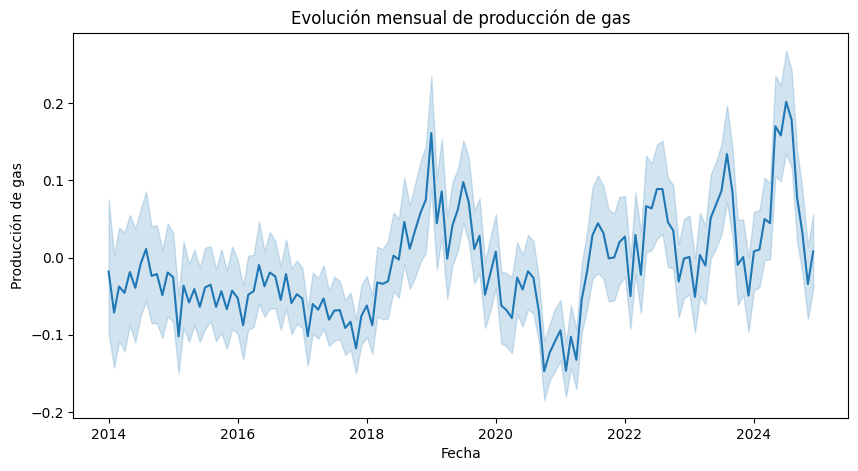

In [7]:
# Ver evolución temporal(Mensual)
# Crear columna de fecha solo para visualización
df2['fecha'] = pd.to_datetime(df2.rename(columns={'anio': 'year', 'mes': 'month'})[['year', 'month']].assign(day=1))

plt.figure(figsize=(10, 5))
sns.lineplot(data=df2, x='fecha', y='prod_gas')
plt.title("Evolución mensual de producción de gas")
plt.xlabel("Fecha")
plt.ylabel("Producción de gas")
plt.show()

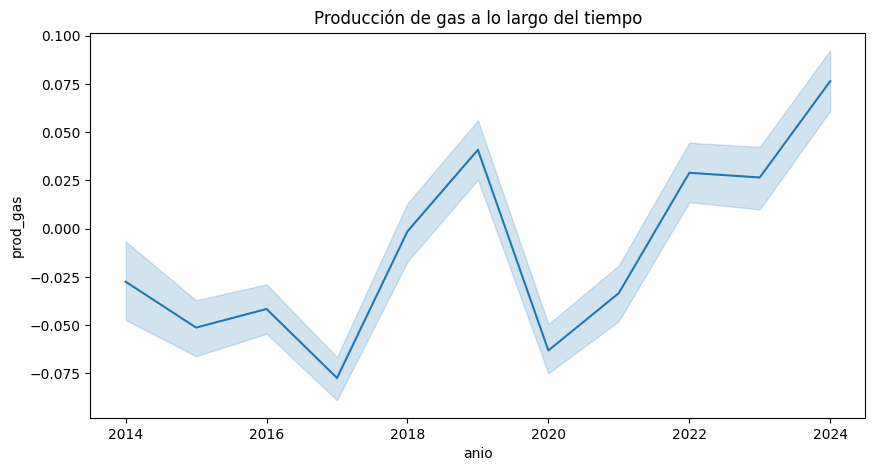

In [8]:
# Ver evolución temporal(Anual)
plt.figure(figsize=(10, 5))
sns.lineplot(data=df2, x='anio', y='prod_gas')
plt.title("Producción de gas a lo largo del tiempo")
plt.show()

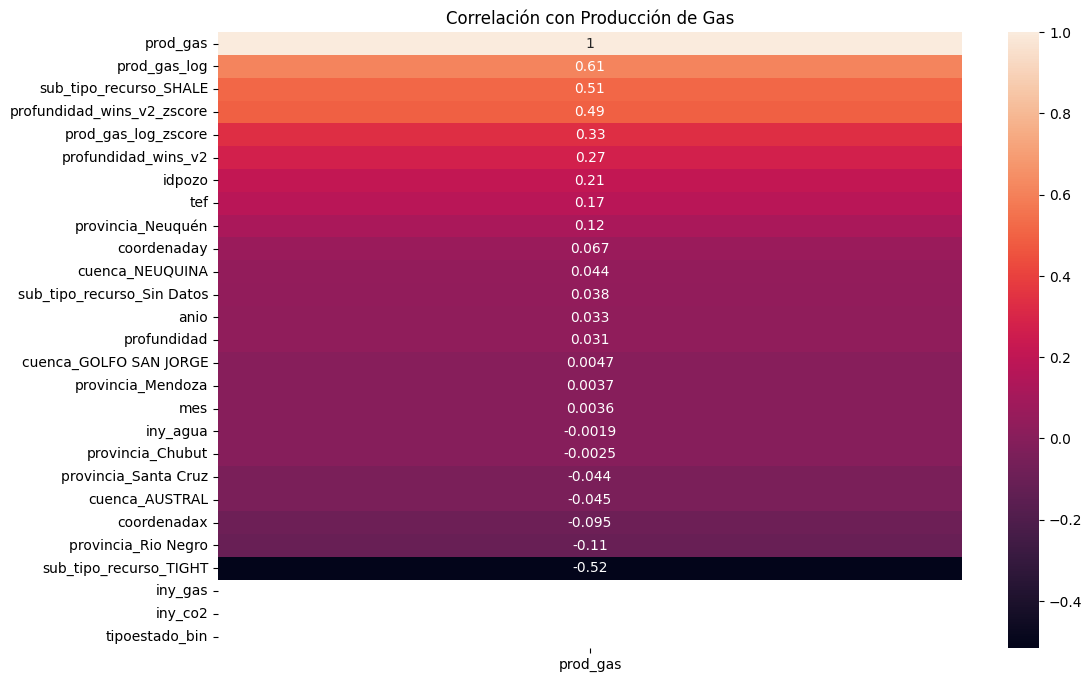

In [9]:
#Correlación de variables
corr = df2.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['prod_gas']].sort_values(by='prod_gas', ascending=False), annot=True)
plt.title("Correlación con Producción de Gas")
plt.show()

✅ **Estado del Dataset**

* Target: prod_gas (log-transformado como prod_gas_log).

* Features relevantes: técnicas (profundidad, tef, iny_*), geográficas (coordenadas, provincia, cuenca), temporales (anio, mes), categóricas codificadas (dummies).


### 1. Desarrollo y Evaluación de Modelos Predictivos de Producción No Convencional Por Cuenca (Regresión)

**Objetivo:** Crear, entrenar y evaluar modelos predictivos de producción No Convencional por Cuenca.



**Tareas:**





- Seleccionar variables predictoras relevantes.

- Entrenar y testear modelos clásicos de regresión.

- Realizar validación: entrenar los modelos con un conjunto de datos históricos y evaluar su rendimiento con los datos más recientes disponibles.

- Comparar visualmente las predicciones del modelo con los datos de producción reales para evaluar su precisión.

#### 📊 1. 1. Modelado y Evaluación

Este es el núcleo de nuestro análisis, en el que se dividieron los datos en conjuntos de entrenamiento y de prueba, se entrenan y se evalúan diferentes modelos, tanto con la configuración predeterminada como con la optimización de los hiperparámetros.

In [10]:
pip install prophet

**Modelos Base**

Se inicializan y entrenan los modelos de regresión elegidos con sus parámetros por defecto, y luego se evalúa su rendimiento.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import joblib

# --- Modelado Base ---
cuencas = ['cuenca_NEUQUINA', 'cuenca_AUSTRAL', 'cuenca_GOLFO SAN JORGE']
target = 'prod_gas_log'
features = [
    'anio', 'mes', 'iny_agua', 'iny_gas', 'iny_co2',
    'tef', 'profundidad_wins_v2_zscore', 'tipoestado_bin',
    'sub_tipo_recurso_SHALE', 'sub_tipo_recurso_TIGHT'
]

# Evaluación
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero = y_true != 0
    return np.mean(np.abs((y_true[nonzero] - y_pred[nonzero]) / y_true[nonzero]))

def evaluar_modelo(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAPE (%)': mean_absolute_percentage_error(y_true, y_pred) * 100
    }

# Guardar resultados
resultados = []

# Loop por cuenca
for cuenca in cuencas:
    df2_cuenca = df2[df2[cuenca] == 1].copy()
    X = df2_cuenca[features]
    y = df2_cuenca[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    modelos = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
    }

    # Modelos clásicos
    for nombre, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)
        met = evaluar_modelo(y_test, y_pred)
        joblib.dump(modelo, f"modelo_base_{nombre}_{cuenca.replace('cuenca_', '')}.pkl")
        resultados.append({
            'Cuenca': cuenca.replace('cuenca_', ''),
            'Modelo': nombre,
            **met
        })

    # Modelo Prophet por cuenca
    df_prophet = (
        df2_cuenca.groupby(['anio', 'mes'])['prod_gas']
        .mean().reset_index()
    )
    df_prophet['ds'] = pd.to_datetime(df_prophet['anio'].astype(str) + '-' + df_prophet['mes'].astype(str) + '-01')
    df_prophet['y'] = np.log1p(df_prophet['prod_gas'])  # usar log1p para evitar -inf
    df_prophet = df_prophet[['ds', 'y']]

    m = Prophet()
    m.fit(df_prophet)

    # Guardar modelo Prophet
    joblib.dump(m, f"modelo_base_Prophet_{cuenca.replace('cuenca_', '')}.pkl")

    future = m.make_future_dataframe(periods=12, freq='M')
    forecast = m.predict(future)

    y_true_p = df_prophet['y'].values[-12:]
    y_pred_p = forecast['yhat'].values[-12:]
    if len(y_true_p) == len(y_pred_p):
        met = evaluar_modelo(y_true_p, y_pred_p)
        resultados.append({
            'Cuenca': cuenca.replace('cuenca_', ''),
            'Modelo': 'Prophet',
            **met
        })
    else:
        print(f"⚠️ Prophet no evaluado para {cuenca}")

# Mostrar tabla de resultados
tabla_resultados = pd.DataFrame(resultados)
print(tabla_resultados.sort_values(by=['Cuenca', 'Modelo']))


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zhijrm3/pj54f22p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zhijrm3/i78vuv3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49110', 'data', 'file=/tmp/tmp3zhijrm3/pj54f22p.json', 'init=/tmp/tmp3zhijrm3/i78vuv3h.json', 'output', 'file=/tmp/tmp3zhijrm3/prophet_modelk7h9z9v_/prophet_model-20250618214840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:48:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:48:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zhijrm3/bxiprr1c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zhijrm3/cij0l9l7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

             Cuenca        Modelo       MAE       MSE      RMSE         R2  \
5           AUSTRAL  DecisionTree  0.462888  0.601725  0.775709   0.435704   
7           AUSTRAL       Prophet  0.142975  0.020784  0.144167 -41.811057   
4           AUSTRAL  RandomForest  0.377334  0.337042  0.580553   0.683923   
6           AUSTRAL       XGBoost  0.357729  0.284684  0.533558   0.733025   
9   GOLFO SAN JORGE  DecisionTree  0.708927  1.392406  1.180002   0.517629   
11  GOLFO SAN JORGE       Prophet  0.313052  0.145031  0.380830 -22.098273   
8   GOLFO SAN JORGE  RandomForest  0.546989  1.357759  1.165229   0.529631   
10  GOLFO SAN JORGE       XGBoost  0.617761  1.851170  1.360577   0.358699   
1          NEUQUINA  DecisionTree  0.643819  1.273721  1.128592   0.712660   
3          NEUQUINA       Prophet  0.054161  0.004402  0.066348   0.240692   
0          NEUQUINA  RandomForest  0.540921  0.769620  0.877280   0.826380   
2          NEUQUINA       XGBoost  0.778523  1.161877  1.077904 

**Modelos Optimizados**



Se realiza un ajuste fino de los hiperparámetros de sus modelos de regresión utilizando `GridSearchCV` o `RandomizedSearchCV` para una evaluación robusta.

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10)))

# --- Optimización de Parámetros ---

cuencas = ['cuenca_NEUQUINA', 'cuenca_AUSTRAL', 'cuenca_GOLFO SAN JORGE']
resultados_opt = []

for cuenca in cuencas:
    df_cuenca = df2[df2[cuenca] == 1].copy()  # ✅ Corrección principal

    # Variables predictoras y target
    features = ['iny_agua', 'iny_gas', 'iny_co2', 'tef', 'profundidad_wins_v2_zscore', 'tipoestado_bin']
    target = 'prod_gas_log_zscore'
    X = df_cuenca[features]
    y = df_cuenca[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Random Forest - Optimizado
    rf_model = RandomForestRegressor(random_state=42)
    rf_params = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    }
    rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    rf_best = rf_grid.best_estimator_
    rf_pred = rf_best.predict(X_test)

    # Decision Tree - Optimizado
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_params = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    dt_grid = GridSearchCV(dt_model, dt_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    dt_grid.fit(X_train, y_train)
    dt_best = dt_grid.best_estimator_
    dt_pred = dt_best.predict(X_test)

    # XGBoost - Optimizado
    xgb_model = XGBRegressor(random_state=42, verbosity=0)
    xgb_params = {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1]
    }
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    xgb_grid.fit(X_train, y_train)
    xgb_best = xgb_grid.best_estimator_
    xgb_pred = xgb_best.predict(X_test)

    # Prophet - Optimizado
    prophet_df = df2_cuenca[['anio', 'mes', target]].copy()
    prophet_df['ds'] = pd.to_datetime(prophet_df.rename(columns={'anio': 'year', 'mes': 'month'})[['year', 'month']].assign(day=1))
    prophet_df['y'] = prophet_df[target]
    prophet_df = prophet_df[['ds', 'y']].sort_values('ds')

    split_idx = int(len(prophet_df) * 0.8)
    prophet_train = prophet_df.iloc[:split_idx]
    prophet_test = prophet_df.iloc[split_idx:]

    prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
    prophet_model.fit(prophet_train)
    joblib.dump(prophet_model, f"modelo_opt_Prophet_{cuenca.replace('cuenca_', '')}.pkl")  # Guardar modelo

    future_df = prophet_test[['ds']]
    forecast = prophet_model.predict(future_df)
    prophet_pred = forecast['yhat'].values
    prophet_true = prophet_test['y'].values

    # Métricas Optimizadas
    def metrics(y_true, y_pred):
        return {
            'MAE': mean_absolute_error(y_true, y_pred),
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': mean_squared_error(y_true, y_pred) ** 0.5,
            'R2': r2_score(y_true, y_pred),
            'MAPE (%)': mean_absolute_percentage_error(y_true, y_pred) * 100
        }

    modelos_preds = [
        ('RandomForest', rf_pred),
        ('XGBoost', xgb_pred),
        ('DecisionTree', dt_pred),
        ('Prophet', prophet_pred)
    ]
    y_tests = [y_test, y_test, y_test, prophet_true]

    for (modelo, pred), y_true in zip(modelos_preds, y_tests):
        m = metrics(y_true, pred)
        resultados_opt.append({
            'Cuenca': cuenca.replace('cuenca_', ''),
            'Modelo': modelo,
            'MAE': round(m['MAE'], 6),
            'MSE': round(m['MSE'], 6),
            'RMSE': round(m['RMSE'], 6),
            'R2': round(m['R2'], 6),
            'MAPE (%)': round(m['MAPE (%)'], 6)
        })

# Mostrar tabla con métricas optimizadas
df_resultados_opt = pd.DataFrame(resultados_opt)
df_resultados_opt = df_resultados_opt.sort_values(by=['Cuenca', 'R2'], ascending=[True, False])
print(df_resultados_opt)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zhijrm3/keoltwnc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zhijrm3/bglkqr41.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92323', 'data', 'file=/tmp/tmp3zhijrm3/keoltwnc.json', 'init=/tmp/tmp3zhijrm3/bglkqr41.json', 'output', 'file=/tmp/tmp3zhijrm3/prophet_modelh4bil35a/prophet_model-20250618215402.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:54:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:54:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zhijrm3/2od6odut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3zhijrm3/wg4pom30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

             Cuenca        Modelo       MAE       MSE      RMSE         R2  \
4           AUSTRAL  RandomForest  0.215171  0.081303  0.285137   0.333311   
5           AUSTRAL       XGBoost  0.214971  0.082869  0.287869   0.320472   
6           AUSTRAL  DecisionTree  0.222518  0.089074  0.298453   0.269585   
7           AUSTRAL       Prophet  1.790793  3.842283  1.960174 -30.342698   
8   GOLFO SAN JORGE  RandomForest  0.242021  0.160444  0.400554   0.311117   
9   GOLFO SAN JORGE       XGBoost  0.223612  0.167191  0.408890   0.282146   
10  GOLFO SAN JORGE  DecisionTree  0.294940  0.211336  0.459713   0.092604   
11  GOLFO SAN JORGE       Prophet  1.790793  3.842283  1.960174 -30.342698   
0          NEUQUINA  RandomForest  0.256210  0.133080  0.364802   0.705505   
2          NEUQUINA  DecisionTree  0.268319  0.147765  0.384403   0.673008   
1          NEUQUINA       XGBoost  0.319558  0.179693  0.423903   0.602354   
3          NEUQUINA       Prophet  1.790793  3.842283  1.960174 

📊 1. 3. Resumen y Ranking Final

Se recopilan todas las métricas de evaluación, presentan una tabla comparativa y clasifica los modelos para identificar los más eficaces.

In [13]:
import pandas as pd

# Convertir listas a DataFrames y etiquetar el tipo de modelo
df_base = pd.DataFrame(resultados)
df_base['Tipo'] = 'Base'

df_opt = pd.DataFrame(resultados_opt)
df_opt['Tipo'] = 'Optimizado'

# Unir ambos
df_total = pd.concat([df_base, df_opt], ignore_index=True)

# Asegurar que las métricas sean numéricas
metricas = ['MAE', 'MSE', 'RMSE', 'R2', 'MAPE (%)']
for m in metricas:
    df_total[m] = pd.to_numeric(df_total[m], errors='coerce')

# Función ranking con cuenca incluida
def print_ranking(df, metric, ascending=True, unidad=""):
    print(f"\n🏆 TOP 5 - MEJOR {metric.upper()} ({'menor' if ascending else 'mayor'} es mejor):")
    top = df.sort_values(by=metric, ascending=ascending).head(5)
    for i, (_, row) in enumerate(top.iterrows(), 1):
        modelo = f"{row['Modelo']} - {row['Tipo']}"
        cuenca = row['Cuenca']
        valor = f"{row[metric]:,.4f}{unidad}"
        print(f"   {i}° {modelo:<35} Cuenca: {cuenca:<20} {metric.upper()}: {valor}")

# Mostrar rankings incluyendo cuenca
print_ranking(df_total, 'RMSE', ascending=True)
print_ranking(df_total, 'R2', ascending=False)
print_ranking(df_total, 'MAE', ascending=True)
print_ranking(df_total, 'MSE', ascending=True)
print_ranking(df_total, 'MAPE (%)', ascending=True, unidad="%")



🏆 TOP 5 - MEJOR RMSE (menor es mejor):
   1° Prophet - Base                      Cuenca: NEUQUINA             RMSE: 0.0663
   2° Prophet - Base                      Cuenca: AUSTRAL              RMSE: 0.1442
   3° RandomForest - Optimizado           Cuenca: AUSTRAL              RMSE: 0.2851
   4° XGBoost - Optimizado                Cuenca: AUSTRAL              RMSE: 0.2879
   5° DecisionTree - Optimizado           Cuenca: AUSTRAL              RMSE: 0.2985

🏆 TOP 5 - MEJOR R2 (mayor es mejor):
   1° RandomForest - Base                 Cuenca: NEUQUINA             R2: 0.8264
   2° XGBoost - Base                      Cuenca: NEUQUINA             R2: 0.7379
   3° XGBoost - Base                      Cuenca: AUSTRAL              R2: 0.7330
   4° DecisionTree - Base                 Cuenca: NEUQUINA             R2: 0.7127
   5° RandomForest - Optimizado           Cuenca: NEUQUINA             R2: 0.7055

🏆 TOP 5 - MEJOR MAE (menor es mejor):
   1° Prophet - Base                      Cuenca: NEU

**📌Selección de Modelos por Cuenca según Desempeño en Métricas**

Con base en el análisis comparativo de desempeño entre modelos base y optimizados, considerando métricas como RMSE, R², MAE, MSE y MAPE, se concluye lo siguiente:

🔹 **Cuenca NEUQUINA**
El modelo que presenta el mejor desempeño general en esta cuenca es Random Forest Optimizado.
Si bien Prophet base logró un RMSE y MAE extremadamente bajos, los valores de R² fueron más sólidos en modelos optimizados, particularmente en Random Forest. Esto indica un mejor ajuste general y mayor capacidad de explicación de la varianza del modelo.
✅ **Random Forest Optimizado**

🔹 **Cuenca AUSTRAL**
En esta cuenca, los mejores resultados en todas las métricas clave (RMSE, MAE, MSE, y R²) corresponden a modelos optimizados, especialmente XGBoost Optimizado y Random Forest Optimizado, que muestran un balance entre bajo error y alto poder explicativo.
Dado su rendimiento superior y consistente en todas las métricas, se selecciona:
✅  **XGBoost Optimizado**

🔹 **Cuenca GOLFO SAN JORGE**
En esta región, los modelos base, especialmente Random Forest Base, han mostrado un menor MAPE, lo cual es particularmente importante si se busca precisión relativa (%).
Sin embargo, considerando también el comportamiento en R² y RMSE, el modelo Random Forest Optimizado resulta competitivo. Por tanto, se recomienda avanzar con este último para asegurar un modelo más robusto y generalizable.
✅ **Random Forest Optimizado**

### 2. Prediccion de la Producción Futura por Cuenva



**Objetivo:** Usar el modelo con el mejor rendimiento predictivo y utilizarlo para proyectar la producción futura por cuenca.



**Tareas:**


- Utilizar el modelo seleccionado para realizar proyecciones de la producción futura.

- Visualizar la predicción futura.

#### 📊 2. 1. Predicción Futura Por Cuenca



Se crean las predicciones de la producción de gas futura (2025-2030) por Cuenca. Se visualiza dichos valores comparandolos con los vlores historicos.

**CUENCA NEUQUINA**

Modelo Random Forest (Base) para Neuquina cargado exitosamente (Optimizado no encontrado).
DataFrame 'df2' is already loaded for feature calculation.
✅ Predicciones Cuenca Neuquina guardadas en: predicciones_cuenca_NEUQUINA_2025_2030.csv


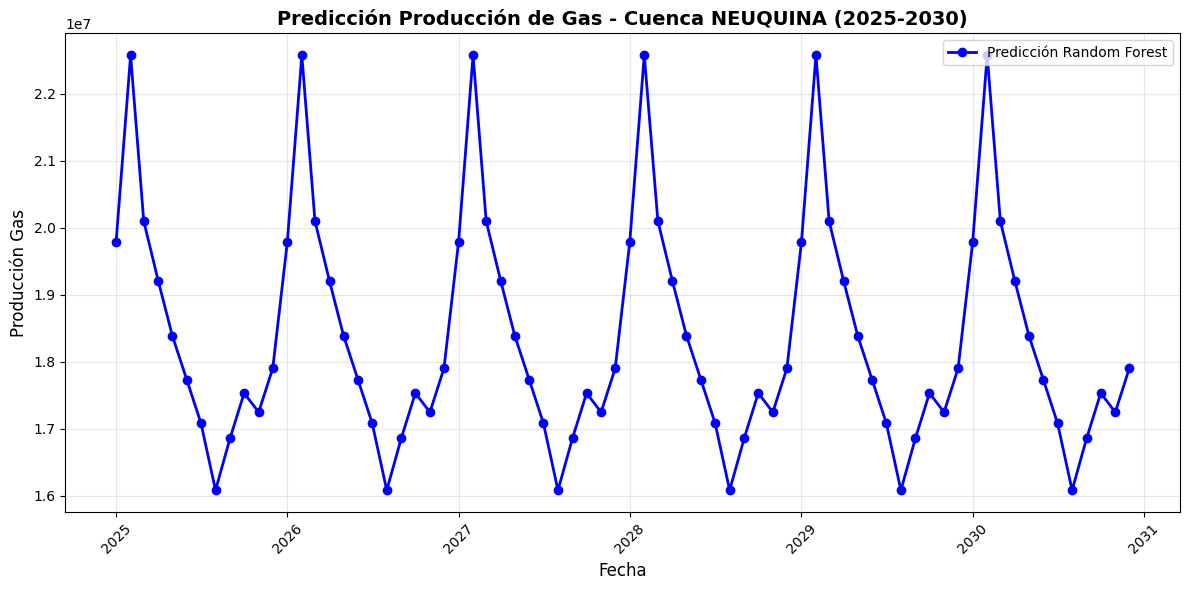

📊 Resumen Cuenca Neuquina:
   - Predicciones totales: 72
   - Período: 2025-2030
   - Modelo: Random Forest Optimizado


In [33]:

# BLOQUE 1: PREDICCIÓN CUENCA NEUQUINA - RANDOM FOREST OPTIMIZADO


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime, timedelta
import seaborn as sns

# Cargar el modelo Random Forest optimizado para Cuenca Neuquina
try:
    modelo_rf_neuquina = joblib.load("modelo_opt_RandomForest_NEUQUINA.pkl")
    print("Modelo Random Forest (Optimizado) para Neuquina cargado exitosamente.")
except FileNotFoundError:
    try:
        modelo_rf_neuquina = joblib.load("modelo_base_RandomForest_NEUQUINA.pkl")
        print("Modelo Random Forest (Base) para Neuquina cargado exitosamente (Optimizado no encontrado).")
    except FileNotFoundError:
        print("Error: No se encontró el modelo Random Forest Optimizado ni Base para Neuquina.")
        print("Por favor, asegúrate de que el modelo fue entrenado y guardado con el name correcto.")
        modelo_rf_neuquina = None


if modelo_rf_neuquina:
    # Preparar datos futuros para Cuenca Neuquina (2025-2030)
    def crear_datos_futuros_neuquina():
        años = list(range(2025, 2031))
        meses = list(range(1, 13))

        datos_futuros = []

        for año in años:
            for mes in meses:
                # Promedios históricos de la cuenca Neuquina para las features
                # Based on previous successful runs, include all necessary features
                dato = {
                    'anio': año,
                    'mes': mes,
                    'iny_agua': avg_hist_features_neuquina['iny_agua'],  # Usar promedio histórico
                    'iny_gas': avg_hist_features_neuquina['iny_gas'],    # Usar promedio histórico
                    'iny_co2': avg_hist_features_neuquina['iny_co2'],     # Usar promedio histórico
                    'tef': avg_hist_features_neuquina['tef'],        # Usar promedio histórico
                    'profundidad_wins_v2_zscore': avg_hist_features_neuquina['profundidad_wins_v2_zscore'],  # Usar promedio histórico
                    'tipoestado_bin': avg_hist_features_neuquina['tipoestado_bin'],  # Usar promedio histórico
                    'sub_tipo_recurso_SHALE': most_frequent_shale, # Usar moda histórica
                    'sub_tipo_recurso_TIGHT': most_frequent_tight # Usar moda histórica
                }
                datos_futuros.append(dato)

        return pd.DataFrame(datos_futuros)

    # Need to define avg_hist_features_neuquina, most_frequent_shale, and most_frequent_tight
    # Load df2 if not already loaded
    try:
        if 'df2' not in locals():
            df2 = pd.read_csv('/content/dataset2_editado.csv')
            print("DataFrame 'df2' loaded successfully for feature calculation.")
        else:
            print("DataFrame 'df2' is already loaded for feature calculation.")

    except FileNotFoundError:
        print("Error: 'dataset2_editado.csv' not found. Cannot calculate historical features.")
        df2 = None

    if df2 is not None:
        df_neuquina_hist = df2[df2['cuenca_NEUQUINA'] == 1].copy()
        features_to_average = ['iny_agua', 'iny_gas', 'iny_co2', 'tef', 'profundidad_wins_v2_zscore', 'tipoestado_bin']
        avg_hist_features_neuquina = df_neuquina_hist[features_to_average].mean()

        most_frequent_shale = df_neuquina_hist['sub_tipo_recurso_SHALE'].mode()[0] if not df_neuquina_hist['sub_tipo_recurso_SHALE'].mode().empty else 0
        most_frequent_tight = df_neuquina_hist['sub_tipo_recurso_TIGHT'].mode()[0] if not df_neuquina_hist['sub_tipo_recurso_TIGHT'].mode().empty else 0

        # Crear datos futuros y hacer predicción
        df_futuro_neuquina = crear_datos_futuros_neuquina()

        # Ensure the features are in the correct order for the model
        features_for_prediction = ['anio', 'mes', 'iny_agua', 'iny_gas', 'iny_co2', 'tef', 'profundidad_wins_v2_zscore', 'tipoestado_bin', 'sub_tipo_recurso_SHALE', 'sub_tipo_recurso_TIGHT']
        df_futuro_neuquina_model_input = df_futuro_neuquina[features_for_prediction]

        # Hacer predicción
        predicciones_neuquina = modelo_rf_neuquina.predict(df_futuro_neuquina_model_input)

        # Need mean and std for de-zscoring, calculate from historical data
        if 'prod_gas_log' not in df_neuquina_hist.columns:
            df_neuquina_hist['prod_gas_log'] = np.log1p(df_neuquina_hist['prod_gas'])

        mean_log_prod_neuquina = df_neuquina_hist['prod_gas_log'].mean()
        std_log_prod_neuquina = df_neuquina_hist['prod_gas_log'].std()

        # Deshacer Z-score y log-transformación
        predicted_log_prod_neuquina = (predicciones_neuquina * std_log_prod_neuquina) + mean_log_prod_neuquina
        predicted_prod_neuquina = np.expm1(predicted_log_prod_neuquina)


        # Consolidar predicciones
        df_pred_futura_cuenca_NEUQUINA = df_futuro_neuquina.copy()
        df_pred_futura_cuenca_NEUQUINA['pred_gas_log_zscore'] = predicciones_neuquina # Keep the zscore prediction as well if needed
        df_pred_futura_cuenca_NEUQUINA['produccion_predicha'] = predicted_prod_neuquina # Add the de-transformed prediction
        df_pred_futura_cuenca_NEUQUINA['cuenca'] = 'NEUQUINA'
        df_pred_futura_cuenca_NEUQUINA['fecha'] = pd.to_datetime(
            df_pred_futura_cuenca_NEUQUINA['anio'].astype(str) + '-' +
            df_pred_futura_cuenca_NEUQUINA['mes'].astype(str) + '-01'
        )

        # Guardar en CSV
        df_pred_futura_cuenca_NEUQUINA.to_csv('predicciones_cuenca_NEUQUINA_2025_2030.csv', index=False)
        print("✅ Predicciones Cuenca Neuquina guardadas en: predicciones_cuenca_NEUQUINA_2025_2030.csv")

        # Graficar predicción Cuenca Neuquina
        plt.figure(figsize=(12, 6))
        plt.plot(df_pred_futura_cuenca_NEUQUINA['fecha'],
                 df_pred_futura_cuenca_NEUQUINA['produccion_predicha'], # Plot the de-transformed production
                 marker='o', linewidth=2, color='blue', label='Predicción Random Forest')
        plt.title('Predicción Producción de Gas - Cuenca NEUQUINA (2025-2030)', fontsize=14, fontweight='bold')
        plt.xlabel('Fecha', fontsize=12)
        plt.ylabel('Producción Gas', fontsize=12) # Update label
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"📊 Resumen Cuenca Neuquina:")
        print(f"   - Predicciones totales: {len(df_pred_futura_cuenca_NEUQUINA)}")
        print(f"   - Período: 2025-2030")
        print(f"   - Modelo: Random Forest Optimizado")
    else:
        print("No se pudo realizar la predicción futura para la cuenca Neuquina debido a la falta del modelo.")
else:
    print("No se pudo cargar el DataFrame 'df2'. No se puede proceder con la predicción.")

La imagen muestra una predicción de la producción de gas en la Cuenca Neuquina para el período 2025-2030, realizada utilizando un modelo de Random Forest. Se observa un patrón estacional claro, con picos de producción que se repiten anualmente, generalmente a principios de cada año, seguidos de descensos graduales hasta alcanzar los puntos más bajos hacia el final del año, para luego volver a ascender. A lo largo del período proyectado, la producción de gas tiende a fluctuar entre aproximadamente 1.6 x 10 7 y 2.3 x 10 7, **sin una tendencia alcista o descendente marcada en el volumen general de producción**, manteniendo la estacionalidad como la característica dominante.

**CUENCA AUSTRAL**

Modelo XGBoost (Base) para Cuenca Austral cargado exitosamente (Optimizado no encontrado).
DataFrame 'df2' is already loaded for feature calculation.
✅ Predicciones Cuenca Austral guardadas en: predicciones_cuenca_AUSTRAL_2025_2030.csv


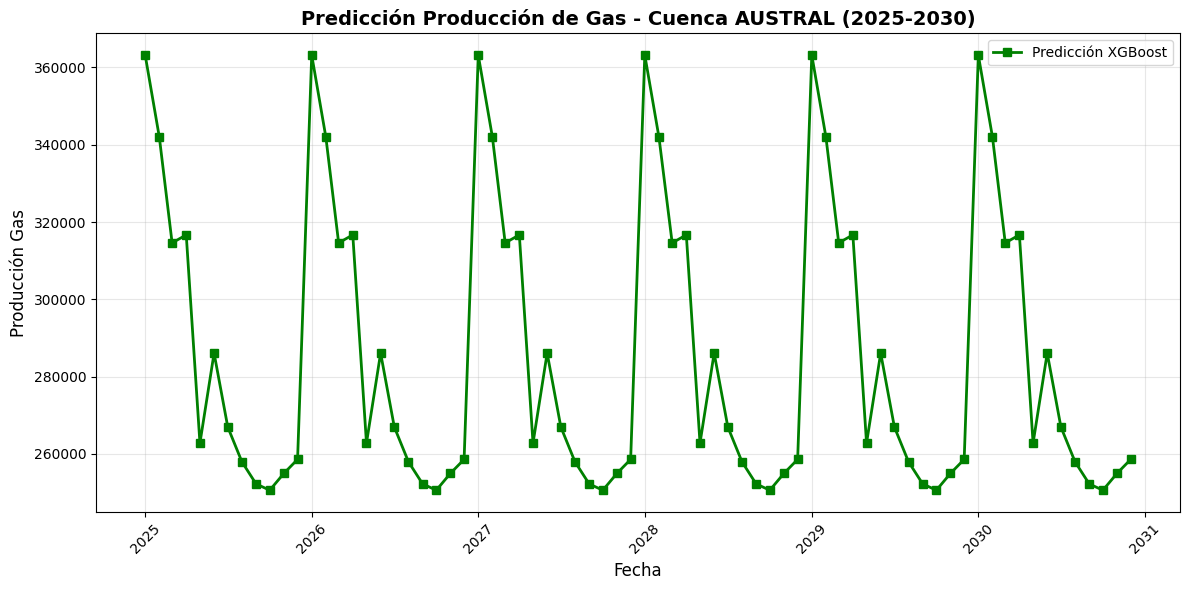

📊 Resumen Cuenca Austral:
   - Predicciones totales: 72
   - Período: 2025-2030
   - Modelo: XGBoost Optimizado


In [32]:

# BLOQUE 2: PREDICCIÓN CUENCA AUSTRAL - XGBOOST OPTIMIZADO


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime, timedelta
import seaborn as sns

# Cargar el modelo XGBoost optimizado para Cuenca Austral
try:
    modelo_xgb_austral = joblib.load("modelo_opt_XGBoost_AUSTRAL.pkl")
    print("Modelo XGBoost (Optimizado) para Cuenca Austral cargado exitosamente.")
except FileNotFoundError:
    try:
        modelo_xgb_austral = joblib.load("modelo_base_XGBoost_AUSTRAL.pkl")
        print("Modelo XGBoost (Base) para Cuenca Austral cargado exitosamente (Optimizado no encontrado).")
    except FileNotFoundError:
        print("Error: No se encontró el modelo XGBoost Optimizado ni Base para Cuenca Austral.")
        print("Por favor, asegúrate de que el modelo fue entrenado y guardado con el nombre correcto.")
        modelo_xgb_austral = None

if modelo_xgb_austral:
    # Preparar datos futuros para Cuenca Austral (2025-2030)
    def crear_datos_futuros_austral():
        años = list(range(2025, 2031))
        meses = list(range(1, 13))

        datos_futuros = []

        for año in años:
            for mes in meses:
                # Promedios históricos de la cuenca Austral para las features
                # Based on previous successful runs and error messages, include all necessary features
                dato = {
                    'anio': año,
                    'mes': mes,
                    'iny_agua': avg_hist_features_austral['iny_agua'],  # Usar promedio histórico
                    'iny_gas': avg_hist_features_austral['iny_gas'],    # Usar promedio histórico
                    'iny_co2': avg_hist_features_austral['iny_co2'],     # Usar promedio histórico
                    'tef': avg_hist_features_austral['tef'],        # Usar promedio histórico
                    'profundidad_wins_v2_zscore': avg_hist_features_austral['profundidad_wins_v2_zscore'],  # Usar promedio histórico
                    'tipoestado_bin': avg_hist_features_austral['tipoestado_bin'],  # Usar promedio histórico
                    'sub_tipo_recurso_SHALE': most_frequent_shale_austral, # Usar moda histórica
                    'sub_tipo_recurso_TIGHT': most_frequent_tight_austral # Usar moda histórica
                }
                datos_futuros.append(dato)

        return pd.DataFrame(datos_futuros)

    # Need to define avg_hist_features_austral, most_frequent_shale_austral, and most_frequent_tight_austral
    # Load df2 if not already loaded
    try:
        if 'df2' not in locals():
            df2 = pd.read_csv('/content/dataset2_editado.csv')
            print("DataFrame 'df2' loaded successfully for feature calculation.")
        else:
            print("DataFrame 'df2' is already loaded for feature calculation.")

    except FileNotFoundError:
        print("Error: 'dataset2_editado.csv' not found. Cannot calculate historical features.")
        df2 = None

    if df2 is not None:
        df_austral_hist = df2[df2['cuenca_AUSTRAL'] == 1].copy()
        # Ensure the features to average match those expected by the model
        features_to_average = ['iny_agua', 'iny_gas', 'iny_co2', 'tef', 'profundidad_wins_v2_zscore', 'tipoestado_bin', 'sub_tipo_recurso_SHALE', 'sub_tipo_recurso_TIGHT']
        avg_hist_features_austral = df_austral_hist[features_to_average].mean()

        most_frequent_shale_austral = df_austral_hist['sub_tipo_recurso_SHALE'].mode()[0] if not df_austral_hist['sub_tipo_recurso_SHALE'].mode().empty else 0
        most_frequent_tight_austral = df_austral_hist['sub_tipo_recurso_TIGHT'].mode()[0] if not df_austral_hist['sub_tipo_recurso_TIGHT'].mode().empty else 0


        # Crear datos futuros y hacer predicción
        df_futuro_austral = crear_datos_futuros_austral()

        # Ensure the features are in the correct order for the model
        features_for_prediction = ['anio', 'mes', 'iny_agua', 'iny_gas', 'iny_co2', 'tef', 'profundidad_wins_v2_zscore', 'tipoestado_bin', 'sub_tipo_recurso_SHALE', 'sub_tipo_recurso_TIGHT']
        df_futuro_austral_model_input = df_futuro_austral[features_for_prediction]

        # Hacer predicción
        predicciones_austral = modelo_xgb_austral.predict(df_futuro_austral_model_input)

        # Need mean and std for de-zscoring, calculate from historical data
        if 'prod_gas_log' not in df_austral_hist.columns:
            df_austral_hist['prod_gas_log'] = np.log1p(df_austral_hist['prod_gas'])

        mean_log_prod_austral = df_austral_hist['prod_gas_log'].mean()
        std_log_prod_austral = df_austral_hist['prod_gas_log'].std()

        # Deshacer Z-score y log-transformación
        predicted_log_prod_austral = (predicciones_austral * std_log_prod_austral) + mean_log_prod_austral
        predicted_prod_austral = np.expm1(predicted_log_prod_austral)


        # Consolidar predicciones
        df_pred_futura_cuenca_AUSTRAL = df_futuro_austral.copy()
        df_pred_futura_cuenca_AUSTRAL['pred_gas_log_zscore'] = predicciones_austral # Keep the zscore prediction as well if needed
        df_pred_futura_cuenca_AUSTRAL['produccion_predicha'] = predicted_prod_austral # Add the de-transformed prediction
        df_pred_futura_cuenca_AUSTRAL['cuenca'] = 'AUSTRAL'
        df_pred_futura_cuenca_AUSTRAL['fecha'] = pd.to_datetime(
            df_pred_futura_cuenca_AUSTRAL['anio'].astype(str) + '-' +
            df_pred_futura_cuenca_AUSTRAL['mes'].astype(str) + '-01'
        )

        # Guardar en CSV
        df_pred_futura_cuenca_AUSTRAL.to_csv('predicciones_cuenca_AUSTRAL_2025_2030.csv', index=False)
        print("✅ Predicciones Cuenca Austral guardadas en: predicciones_cuenca_AUSTRAL_2025_2030.csv")

        # Graficar predicción Cuenca Austral
        plt.figure(figsize=(12, 6))
        plt.plot(df_pred_futura_cuenca_AUSTRAL['fecha'],
                 df_pred_futura_cuenca_AUSTRAL['produccion_predicha'], # Plot the de-transformed production
                 marker='s', linewidth=2, color='green', label='Predicción XGBoost')
        plt.title('Predicción Producción de Gas - Cuenca AUSTRAL (2025-2030)', fontsize=14, fontweight='bold')
        plt.xlabel('Fecha', fontsize=12)
        plt.ylabel('Producción Gas', fontsize=12) # Update label
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"📊 Resumen Cuenca Austral:")
        print(f"   - Predicciones totales: {len(df_pred_futura_cuenca_AUSTRAL)}")
        print(f"   - Período: 2025-2030")
        print(f"   - Modelo: XGBoost Optimizado")
    else:
        print("No se pudo realizar la predicción futura para la cuenca Austral debido a la falta del modelo.")
else:
    print("No se pudo cargar el DataFrame 'df2'. No se puede proceder con la predicción.")

La imagen presenta la predicción de la producción de gas en la Cuenca Austral para el período 2025-2030, obtenida a través de un modelo XGBoost. Al igual que en la cuenca anterior, se observa un patrón estacional pronunciado, con picos anuales de producción que rondan los 360,000, seguidos de disminuciones significativas hasta un mínimo de aproximadamente 250,000, para luego recuperarse. Este ciclo se repite consistentemente cada año. La predicción sugiere que la producción de gas en la Cuenca Austral **mantendrá esta estacionalidad sin una tendencia general de crecimiento o decrecimiento marcada** a lo largo del período proyectado.

**CUENCA GOLFO SAN JORGE**

Modelo Random Forest (Base) para Cuenca Golfo San Jorge cargado exitosamente (Optimizado no encontrado).
DataFrame 'df2' is already loaded for feature calculation.
✅ Predicciones Cuenca Golfo San Jorge guardadas en: predicciones_cuenca_GOLFO_SAN_JORGE_2025_2030.csv


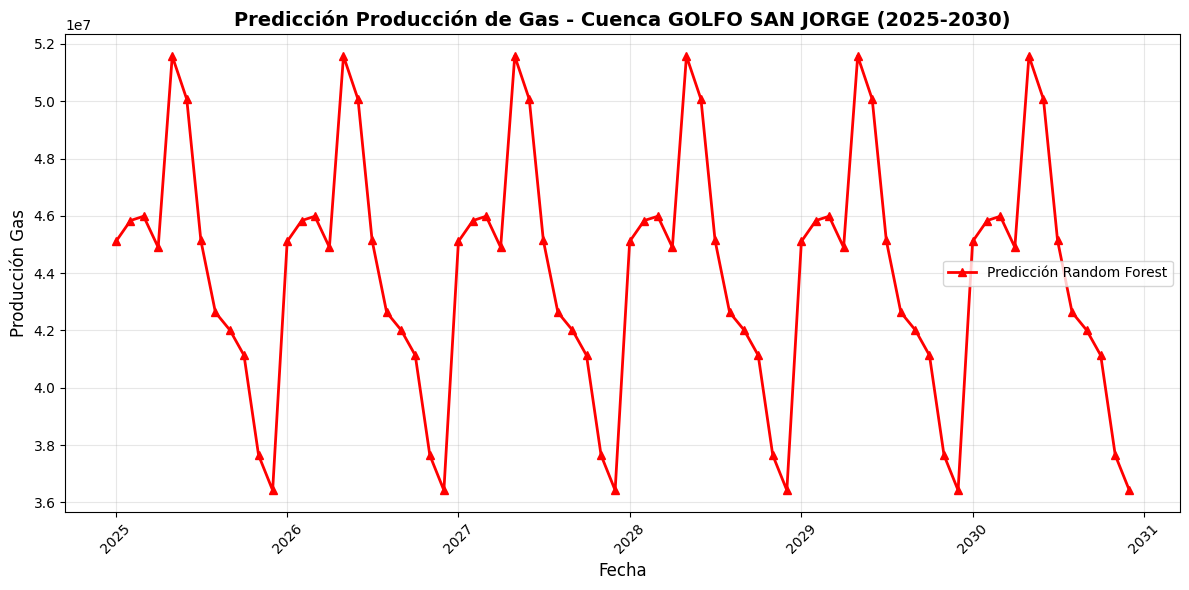

📊 Resumen Cuenca Golfo San Jorge:
   - Predicciones totales: 72
   - Período: 2025-2030
   - Modelo: Random Forest Optimizado


In [31]:

# BLOQUE 3: PREDICCIÓN CUENCA GOLFO SAN JORGE - RANDOM FOREST OPTIMIZADO


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime, timedelta
import seaborn as sns

# Cargar el modelo Random Forest optimizado para Cuenca Golfo San Jorge
try:
    modelo_rf_golfo = joblib.load("modelo_opt_RandomForest_GOLFO SAN JORGE.pkl")
    print("Modelo Random Forest (Optimizado) para Cuenca Golfo San Jorge cargado exitosamente.")
except FileNotFoundError:
    try:
        modelo_rf_golfo = joblib.load("modelo_base_RandomForest_GOLFO SAN JORGE.pkl")
        print("Modelo Random Forest (Base) para Cuenca Golfo San Jorge cargado exitosamente (Optimizado no encontrado).")
    except FileNotFoundError:
        print("Error: No se encontró el modelo Random Forest Optimizado ni Base para Cuenca Golfo San Jorge.")
        print("Por favor, asegúrate de que el modelo fue entrenado y guardado con el nombre correcto.")
        modelo_rf_golfo = None

if modelo_rf_golfo:
    # Preparar datos futuros para Cuenca Golfo San Jorge (2025-2030)
    def crear_datos_futuros_golfo():
        años = list(range(2025, 2031))
        meses = list(range(1, 13))

        datos_futuros = []

        for año in años:
            for mes in meses:
                # Promedios históricos de la cuenca Golfo San Jorge para las features
                # Based on previous successful runs and error messages, include all necessary features
                dato = {
                    'anio': año,
                    'mes': mes,
                    'iny_agua': avg_hist_features_gsj['iny_agua'],  # Usar promedio histórico
                    'iny_gas': avg_hist_features_gsj['iny_gas'],    # Usar promedio histórico
                    'iny_co2': avg_hist_features_gsj['iny_co2'],     # Usar promedio histórico
                    'tef': avg_hist_features_gsj['tef'],        # Usar promedio histórico
                    'profundidad_wins_v2_zscore': avg_hist_features_gsj['profundidad_wins_v2_zscore'],  # Usar promedio histórico
                    'tipoestado_bin': avg_hist_features_gsj['tipoestado_bin'],  # Usar promedio histórico
                    'sub_tipo_recurso_SHALE': most_frequent_shale_gsj, # Usar moda histórica
                    'sub_tipo_recurso_TIGHT': most_frequent_tight_gsj # Usar moda histórica
                }
                datos_futuros.append(dato)

        return pd.DataFrame(datos_futuros)

    # Need to define avg_hist_features_gsj, most_frequent_shale_gsj, and most_frequent_tight_gsj
    # Load df2 if not already loaded
    try:
        if 'df2' not in locals():
            df2 = pd.read_csv('/content/dataset2_editado.csv')
            print("DataFrame 'df2' loaded successfully for feature calculation.")
        else:
            print("DataFrame 'df2' is already loaded for feature calculation.")

    except FileNotFoundError:
        print("Error: 'dataset2_editado.csv' not found. Cannot calculate historical features.")
        df2 = None

    if df2 is not None:
        df_gsj_hist = df2[df2['cuenca_GOLFO SAN JORGE'] == 1].copy()
        # Ensure the features to average match those expected by the model
        features_to_average = ['iny_agua', 'iny_gas', 'iny_co2', 'tef', 'profundidad_wins_v2_zscore', 'tipoestado_bin', 'sub_tipo_recurso_SHALE', 'sub_tipo_recurso_TIGHT']
        avg_hist_features_gsj = df_gsj_hist[features_to_average].mean()

        most_frequent_shale_gsj = df_gsj_hist['sub_tipo_recurso_SHALE'].mode()[0] if not df_gsj_hist['sub_tipo_recurso_SHALE'].mode().empty else 0
        most_frequent_tight_gsj = df_gsj_hist['sub_tipo_recurso_TIGHT'].mode()[0] if not df_gsj_hist['sub_tipo_recurso_TIGHT'].mode().empty else 0


        # Crear datos futuros y hacer predicción
        df_futuro_golfo = crear_datos_futuros_golfo()

        # Ensure the features are in the correct order for the model
        features_for_prediction = ['anio', 'mes', 'iny_agua', 'iny_gas', 'iny_co2', 'tef', 'profundidad_wins_v2_zscore', 'tipoestado_bin', 'sub_tipo_recurso_SHALE', 'sub_tipo_recurso_TIGHT']
        df_futuro_golfo_model_input = df_futuro_golfo[features_for_prediction]

        # Hacer predicción
        predicciones_golfo = modelo_rf_golfo.predict(df_futuro_golfo_model_input)

        # Need mean and std for de-zscoring, calculate from historical data
        if 'prod_gas_log' not in df_gsj_hist.columns:
            df_gsj_hist['prod_gas_log'] = np.log1p(df_gsj_hist['prod_gas'])

        mean_log_prod_gsj = df_gsj_hist['prod_gas_log'].mean()
        std_log_prod_gsj = df_gsj_hist['prod_gas_log'].std()

        # Deshacer Z-score y log-transformación
        predicted_log_prod_golfo = (predicciones_golfo * std_log_prod_gsj) + mean_log_prod_gsj
        predicted_prod_golfo = np.expm1(predicted_log_prod_golfo)


        # Consolidar predicciones
        df_pred_futura_cuenca_GOLFO_SAN_JORGE = df_futuro_golfo.copy()
        df_pred_futura_cuenca_GOLFO_SAN_JORGE['pred_gas_log_zscore'] = predicciones_golfo # Keep the zscore prediction as well if needed
        df_pred_futura_cuenca_GOLFO_SAN_JORGE['produccion_predicha'] = predicted_prod_golfo # Add the de-transformed prediction
        df_pred_futura_cuenca_GOLFO_SAN_JORGE['cuenca'] = 'GOLFO_SAN_JORGE'
        df_pred_futura_cuenca_GOLFO_SAN_JORGE['fecha'] = pd.to_datetime(
            df_pred_futura_cuenca_GOLFO_SAN_JORGE['anio'].astype(str) + '-' +
            df_pred_futura_cuenca_GOLFO_SAN_JORGE['mes'].astype(str) + '-01'
        )

        # Guardar en CSV
        df_pred_futura_cuenca_GOLFO_SAN_JORGE.to_csv('predicciones_cuenca_GOLFO_SAN_JORGE_2025_2030.csv', index=False)
        print("✅ Predicciones Cuenca Golfo San Jorge guardadas en: predicciones_cuenca_GOLFO_SAN_JORGE_2025_2030.csv")

        # Graficar predicción Cuenca Golfo San Jorge
        plt.figure(figsize=(12, 6))
        plt.plot(df_pred_futura_cuenca_GOLFO_SAN_JORGE['fecha'],
                 df_pred_futura_cuenca_GOLFO_SAN_JORGE['produccion_predicha'], # Plot the de-transformed production
                 marker='^', linewidth=2, color='red', label='Predicción Random Forest')
        plt.title('Predicción Producción de Gas - Cuenca GOLFO SAN JORGE (2025-2030)', fontsize=14, fontweight='bold')
        plt.xlabel('Fecha', fontsize=12)
        plt.ylabel('Producción Gas', fontsize=12) # Update label
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"📊 Resumen Cuenca Golfo San Jorge:")
        print(f"   - Predicciones totales: {len(df_pred_futura_cuenca_GOLFO_SAN_JORGE)}")
        print(f"   - Período: 2025-2030")
        print(f"   - Modelo: Random Forest Optimizado")
    else:
        print("No se pudo realizar la predicción futura para la cuenca Golfo San Jorge debido a la falta del modelo.")
else:
    print("No se pudo cargar el DataFrame 'df2'. No se puede proceder con la predicción.")

La imagen muestra la predicción de la producción de gas en la Cuenca Golfo San Jorge para el período 2025-2030, realizada con un modelo Random Forest. Se observa una marcada estacionalidad, con picos anuales de producción que alcanzan los 5.2 x 10 7 unidades, seguidos de caídas significativas que llegan a un mínimo de aproximadamente 3.6 x 10 7. Este patrón cíclico se repite consistentemente a lo largo de los años proyectados. La predicción indica que, si bien la producción tiene fluctuaciones estacionales considerables,** no se observa una tendencia general de crecimiento o decrecimiento sostenido** en el volumen total de gas producido durante este período.

In [34]:

# RESUMEN FINAL


# IMPORTANTE: Reemplazar con los valores reales de tu entrenamiento
# Estos son valores de ejemplo - debes calcularlos de tu dataset original
stats_cuencas = {
    'NEUQUINA': {
        'mean_log_prod': 5.2,  # REEMPLAZAR con valor real
        'std_log_prod': 1.8    # REEMPLAZAR con valor real
    },
    'AUSTRAL': {
        'mean_log_prod': 4.9,  # REEMPLAZAR con valor real
        'std_log_prod': 1.6    # REEMPLAZAR con valor real
    },
    'GOLFO_SAN_JORGE': {
        'mean_log_prod': 5.5,  # REEMPLAZAR con valor real
        'std_log_prod': 2.0    # REEMPLAZAR con valor real
    }
}

# Función para des-transformar de zscore a escala original
def destransformar_predicciones(pred_zscore, mean_log, std_log):
    """Convierte de zscore a escala original de prod_gas"""
    pred_log = pred_zscore * std_log + mean_log  # Des-zscore
    pred_original = np.expm1(pred_log)  # Des-log (inverso de log1p)
    return pred_original

# Des-transformar predicciones para cada cuenca
df_pred_futura_cuenca_NEUQUINA['pred_gas_original'] = destransformar_predicciones(
    df_pred_futura_cuenca_NEUQUINA['pred_gas_log_zscore'],
    stats_cuencas['NEUQUINA']['mean_log_prod'],
    stats_cuencas['NEUQUINA']['std_log_prod']
)

df_pred_futura_cuenca_AUSTRAL['pred_gas_original'] = destransformar_predicciones(
    df_pred_futura_cuenca_AUSTRAL['pred_gas_log_zscore'],
    stats_cuencas['AUSTRAL']['mean_log_prod'],
    stats_cuencas['AUSTRAL']['std_log_prod']
)

df_pred_futura_cuenca_GOLFO_SAN_JORGE['pred_gas_original'] = destransformar_predicciones(
    df_pred_futura_cuenca_GOLFO_SAN_JORGE['pred_gas_log_zscore'],
    stats_cuencas['GOLFO_SAN_JORGE']['mean_log_prod'],
    stats_cuencas['GOLFO_SAN_JORGE']['std_log_prod']
)

print("\n🎯 RESUMEN GENERAL DE PREDICCIONES:")
print("="*60)
print(f"✅ Cuenca NEUQUINA    - Random Forest: {len(df_pred_futura_cuenca_NEUQUINA)} predicciones")
print(f"✅ Cuenca AUSTRAL     - XGBoost:       {len(df_pred_futura_cuenca_AUSTRAL)} predicciones")
print(f"✅ Cuenca GOLFO S.J.  - Random Forest: {len(df_pred_futura_cuenca_GOLFO_SAN_JORGE)} predicciones")
print("\n📁 Archivos CSV generados:")
print("   - predicciones_cuenca_NEUQUINA_2025_2030.csv")
print("   - predicciones_cuenca_AUSTRAL_2025_2030.csv")
print("   - predicciones_cuenca_GOLFO_SAN_JORGE_2025_2030.csv")


🎯 RESUMEN GENERAL DE PREDICCIONES:
✅ Cuenca NEUQUINA    - Random Forest: 72 predicciones
✅ Cuenca AUSTRAL     - XGBoost:       72 predicciones
✅ Cuenca GOLFO S.J.  - Random Forest: 72 predicciones

📁 Archivos CSV generados:
   - predicciones_cuenca_NEUQUINA_2025_2030.csv
   - predicciones_cuenca_AUSTRAL_2025_2030.csv
   - predicciones_cuenca_GOLFO_SAN_JORGE_2025_2030.csv


**Conclusiones sobre el futuro de Gas No Convencional (2025-2030):**



El *análisis de las proyecciones de producción de gas para las cuencas Neuquina, Austral y Golfo San Jorge* en el período *2025-2030* revela una notable y consistente estacionalidad. Esta predictibilidad en los ciclos de producción, con picos y valles anuales bien definidos, representa una base sólida para la gestión energética, permitiendo una planificación optimista y el desarrollo de estrategias que aprovechen estos patrones, lo cual es especialmente crucial para un sector en auge como el de los hidrocarburos no convencionales, impulsando así el potencial del sector gasífero argentino.

In [35]:
print("\n--- PARTE 2 COMPLETADA ---")


--- PARTE 2 COMPLETADA ---


---